In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.api import SARIMAX
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from pmdarima.arima import ndiffs, nsdiffs
from sklearn.model_selection import TimeSeriesSplit
import itertools

from functions import *
%matplotlib inline

In [53]:
import warnings
warnings.filterwarnings('ignore')

# Step 1: Get the data

In [54]:
#import data in question
_30day_pop_tot = pd.read_csv("../Data/_30_day_adp.csv", index_col = 0)
#specify data types for start and end date
_30day_pop_tot['Start Date'] = _30day_pop_tot['Start Date'].astype('datetime64[ns]')
_30day_pop_tot['End Date'] = _30day_pop_tot['End Date'].astype('datetime64[ns]')

_30day_pop_tot.head()

Start Date   End Date     ADP
0 2016-05-05 2016-06-03  9808.0
1 2016-06-04 2016-07-03  9807.0
2 2016-07-04 2016-08-02  9743.0
3 2016-08-03 2016-09-01  9792.0
4 2016-09-02 2016-10-01  9865.0

In [55]:
joined_doc_ivs_df = pd.read_csv("../Data/_30_day_IVs.csv", index_col = 0)
#specify data types for start and end date
joined_doc_ivs_df['Start Date'] = joined_doc_ivs_df['Start Date'].astype('datetime64[ns]')
joined_doc_ivs_df['End Date'] = joined_doc_ivs_df['End Date'].astype('datetime64[ns]')
joined_doc_ivs_df.head()

Start Date   End Date  admission_count  discharge_count
0 2016-05-05 2016-06-03             5110             5149
1 2016-06-04 2016-07-03             4920             4755
2 2016-07-04 2016-08-02             4607             4705
3 2016-08-03 2016-09-01             4834             4719
4 2016-09-02 2016-10-01             4687             4737

In [56]:
crime_data = pd.read_csv("../Data/_30_day_crime_counts.csv", index_col = 0)
#specify data types for start and end date
crime_data['Start Date'] = crime_data['Start Date'].astype('datetime64[ns]')
crime_data['End Date'] = crime_data['End Date'].astype('datetime64[ns]')

#get arrest data
arrest_data = pd.read_csv("../Data/_30_day_arrest_counts.csv", index_col = 0)
#specify data types for start and end date
arrest_data['Start Date'] = arrest_data['Start Date'].astype('datetime64[ns]')
arrest_data['End Date'] = arrest_data['End Date'].astype('datetime64[ns]')


In [57]:
print(len(crime_data),len(arrest_data),len(joined_doc_ivs_df),len(_30day_pop_tot))

99 99 101 102


In [58]:
#determine how many predictions we will make for each group of variables based on the length of ADP signal
n_steps_crime = 12 + len(_30day_pop_tot) - len(crime_data)
n_steps_arr = 12 + len(_30day_pop_tot) - len(arrest_data)
n_steps_adm = 12 + len(_30day_pop_tot) - len(joined_doc_ivs_df)
n_steps_adp = 12

print(n_steps_crime,n_steps_arr,n_steps_adm,n_steps_adp)

15 15 13 12


In [59]:
#join all variables of interest into one dataframe
crime_cols = ['Start Date', 'End Date', 'total_felony_crimes',
              'violent_felony_crimes','nonviolent_felony_crimes', 'total_misdemeanor_crimes']
arr_cols = ['Start Date', 'End Date', 'total_felony_arrest',
            'violent_felony_arrest','nonviolent_felony_arrest', 'total_misdemeanor_arrest']

#join adp and crime data
joined_df = _30day_pop_tot.merge(crime_data[crime_cols],
                                 how = 'left',
                                 left_on= ['Start Date', 'End Date'],
                                 right_on= ['Start Date', 'End Date'])
#join arrests
joined_df = joined_df.merge(arrest_data[arr_cols],
                                 how = 'left',
                                 left_on= ['Start Date', 'End Date'],
                                 right_on= ['Start Date', 'End Date'])
#join admission count
joined_df = joined_df.merge(joined_doc_ivs_df[['Start Date', 'End Date','admission_count']],
                            how = 'left',
                            left_on= ['Start Date', 'End Date'],
                            right_on= ['Start Date', 'End Date']
                            )
#make everything transform everything into natural log so we can ensure our predictions & CI remain positive
# joined_df[joined_df.columns.to_list()[2:]] = np.log(joined_df[joined_df.columns.to_list()[2:]])
joined_df.head()

Start Date   End Date     ADP  total_felony_crimes  violent_felony_crimes   
0 2016-05-05 2016-06-03  9808.0              12726.0                 3229.0  \
1 2016-06-04 2016-07-03  9807.0              12717.0                 3361.0   
2 2016-07-04 2016-08-02  9743.0              12877.0                 3583.0   
3 2016-08-03 2016-09-01  9792.0              13264.0                 3514.0   
4 2016-09-02 2016-10-01  9865.0              12549.0                 3302.0   

   nonviolent_felony_crimes  total_misdemeanor_crimes  total_felony_arrest   
0                    9497.0                   23261.0               8424.0  \
1                    9356.0                   22877.0               7482.0   
2                    9294.0                   21861.0               7595.0   
3                    9750.0                   22588.0               8069.0   
4                    9247.0                   21660.0               7565.0   

   violent_felony_arrest  nonviolent_felony_arrest  total_misdemeanor_arrest   
0                 2357.0                    6067.0                   18603.0  \
1                 2244.0                    5238.0                   17114.0   
2                 2437.0                    5158.0                   15139.0   
3                 2429.0                    5640.0                   17217.0   
4                 2206.0                    5359.0                   16367.0   

   admission_count  
0           5110.0  
1           4920.0  
2           4607.0  
3           4834.0  
4           4687.0

In [60]:
joined_df.tail()

Start Date   End Date     ADP  total_felony_crimes  violent_felony_crimes   
97  2024-04-23 2024-05-22  6314.0              14793.0                 3929.0  \
98  2024-05-23 2024-06-21  6351.0              15065.0                 4297.0   
99  2024-06-22 2024-07-21  6394.0                  NaN                    NaN   
100 2024-07-22 2024-08-20  6417.0                  NaN                    NaN   
101 2024-08-21 2024-09-19  6496.0                  NaN                    NaN   

     nonviolent_felony_crimes  total_misdemeanor_crimes  total_felony_arrest   
97                    10864.0                   23909.0               9034.0  \
98                    10768.0                   24731.0               9529.0   
99                        NaN                       NaN                  NaN   
100                       NaN                       NaN                  NaN   
101                       NaN                       NaN                  NaN   

     violent_felony_arrest  nonviolent_felony_arrest   
97                  2968.0                    6066.0  \
98                  3259.0                    6270.0   
99                     NaN                       NaN   
100                    NaN                       NaN   
101                    NaN                       NaN   

     total_misdemeanor_arrest  admission_count  
97                    11939.0           1939.0  
98                    12521.0           2039.0  
99                        NaN           1866.0  
100                       NaN           2059.0  
101                       NaN              NaN

In [61]:
joined_df.columns

Index(['Start Date', 'End Date', 'ADP', 'total_felony_crimes',
       'violent_felony_crimes', 'nonviolent_felony_crimes',
       'total_misdemeanor_crimes', 'total_felony_arrest',
       'violent_felony_arrest', 'nonviolent_felony_arrest',
       'total_misdemeanor_arrest', 'admission_count'],
      dtype='object')

## Step 2: Time Series Analysis

I will log-transform all of my series before analyzing and during the fit process. I am doing this to ensure all predicted values remain non-negative since we are handling population count data. I will then define two UDFs that conducts a grid search & rolling window cross validation technique to find the SARIMA paramters that minimize OOS mean absolute error.

Another important tool to evaluate the model is the analysis of the residual test statistics in the results summary.

Now we print the summaries of each model and evaluate Prob(Q) and Prob(JB) applying, respectively, the following tests:

**Ljung–Box test:**

Null hypothesis: There are no correlations in the residuals.

**Jarque–Bera test:**

Null hypothesis: Residuals are normally distributed.

In [62]:
# Ensure non-negative values by applying a log transformation
def log_transform(series):
    return np.log1p(series)

def inverse_log_transform(series):
    return np.expm1(series)

In [63]:
def time_series_cv(y, order, seasonal_order, n_splits, exog=None):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mae_scores = []

    for train_index, test_index in tscv.split(y):
        train_y, test_y = y[train_index], y[test_index]
        train_exog = exog.iloc[train_index] if exog is not None else None
        test_exog = exog.iloc[test_index] if exog is not None else None
        
        model = SARIMAX(train_y, exog=train_exog, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)
        
        predictions = results.predict(start=test_index[0], end=test_index[-1], exog=test_exog)
        mae = mean_absolute_error(inverse_log_transform(test_y), inverse_log_transform(predictions))
        mae_scores.append(mae)
        
    return results, np.mean(mae_scores)

def grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits, exog=None):
    best_score, best_params = float("inf"), None
    
    d_value = ndiffs(y.dropna(), test='adf')
    D_value = nsdiffs(y.dropna(), m=s)
    pdq = list(itertools.product(p_values, [d_value], q_values))
    seasonal_pdq = list(itertools.product(P_values, [D_value], Q_values, [s]))
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                results, mae_score = time_series_cv(y, order=param, seasonal_order=param_seasonal, n_splits=n_splits, exog=exog)
                if mae_score < best_score:
                    best_score, best_params = mae_score, (param, param_seasonal)
                    best_result = results
            except:
                continue
                
    print(best_result.summary())
    return best_result, best_params, best_score


### Crime Metrics

In [64]:
# Define the crime variables
crime_vars = ['total_felony_crimes', 'violent_felony_crimes', 'nonviolent_felony_crimes', 'total_misdemeanor_crimes']
crime_df = joined_df[['End Date']+crime_vars].dropna()
crime_df.set_index('End Date', inplace=True)

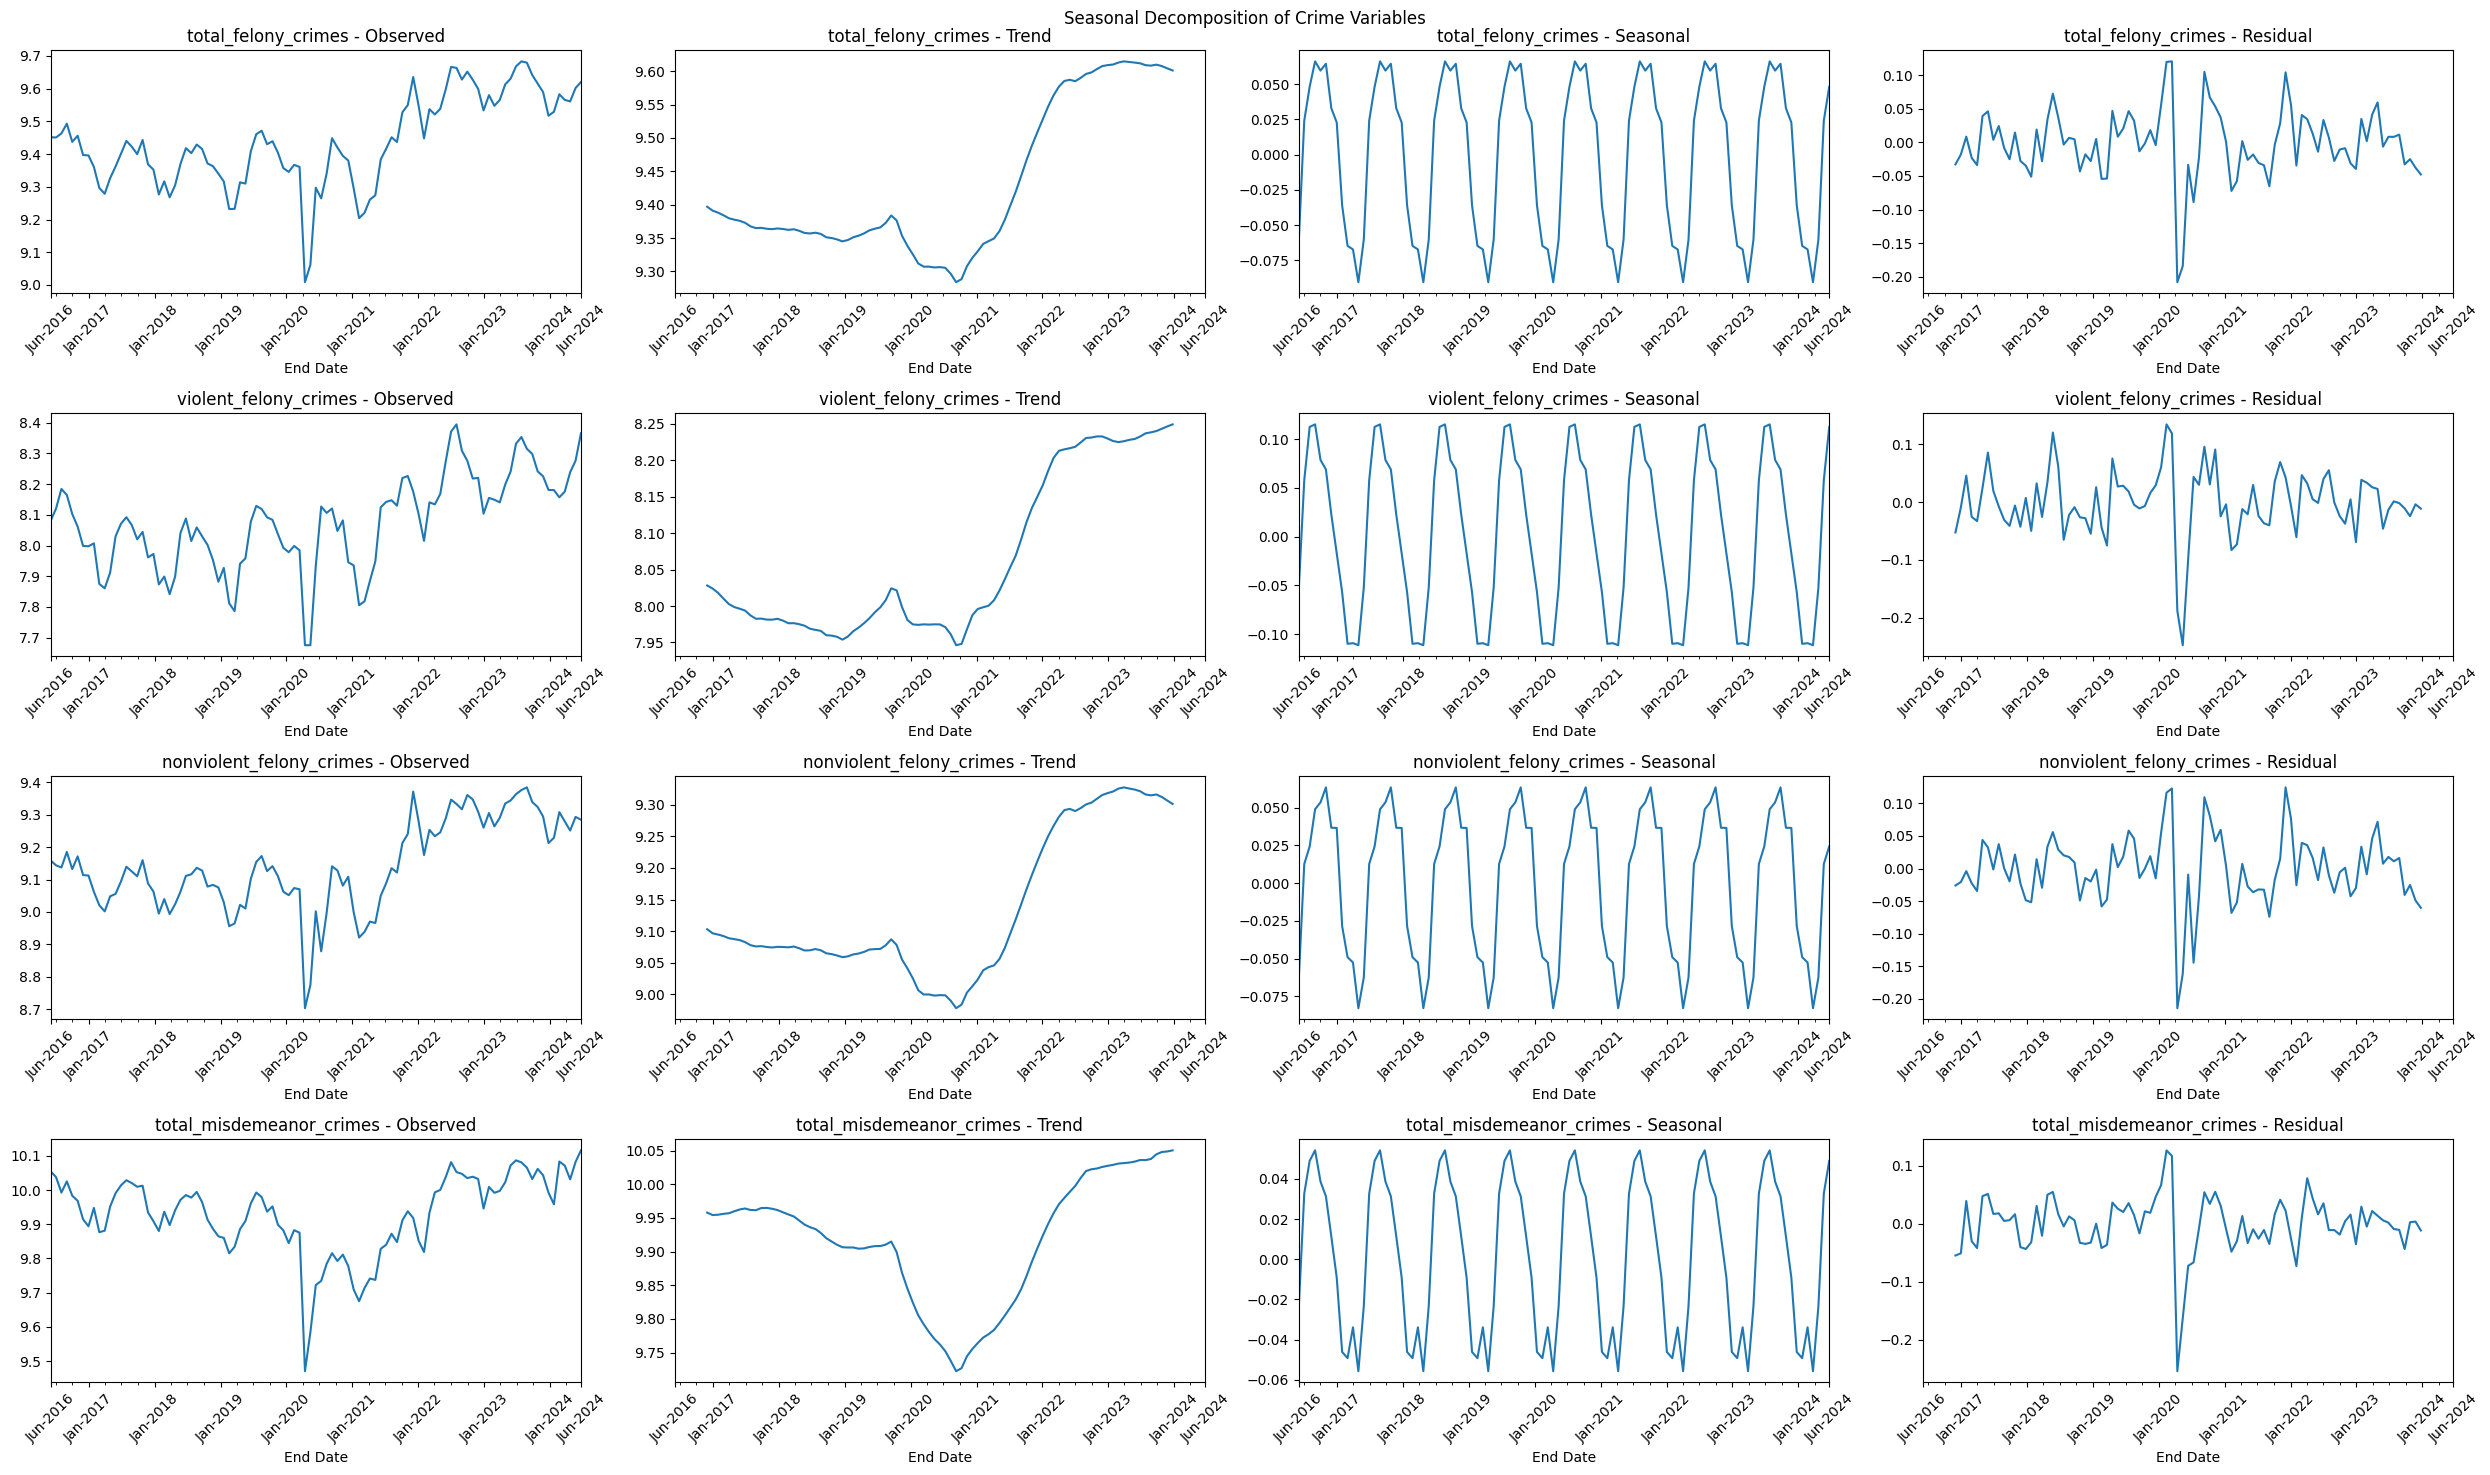

In [65]:
#plot seasonal decompose of crime vars

# Set up the figure with a 4x4 grid of subplots
fig, axes = plt.subplots(len(crime_vars), 4, figsize=(25, 15))

# Iterate through each crime variable
for i, var in enumerate(crime_vars):
    # Perform seasonal decomposition
    result = seasonal_decompose(log_transform(crime_df[var].dropna()), model='additive', period=12)  # Adjust 'period' according to your data
    
    # Plot each component in a separate subplot
    result.observed.plot(ax=axes[i, 0], legend=False, title=f'{var} - Observed')
    result.trend.plot(ax=axes[i, 1], legend=False, title=f'{var} - Trend')
    result.seasonal.plot(ax=axes[i, 2], legend=False, title=f'{var} - Seasonal')
    result.resid.plot(ax=axes[i, 3], legend=False, title=f'{var} - Residual')

    for j in range(4):
        axes[i, j].set_xlabel('End Date')
        axes[i, j].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b-%Y'))
        axes[i, j].tick_params(axis='x', rotation=45)

# Adjust layout
plt.suptitle('Seasonal Decomposition of Crime Variables')
plt.tight_layout()
plt.show()

In [66]:
for i, var in enumerate(crime_vars):
    signal = log_transform(crime_df[var].dropna())
    #determine non-seasonal and seasonal differencing orders
    d = ndiffs(signal, test='adf',alpha=0.01)
    D = nsdiffs(signal, m = 12, max_D=2)
    print(f'The difference cofficient for {var} is {d} and the seasonal difference is {D}')

The difference cofficient for total_felony_crimes is 1 and the seasonal difference is 0
The difference cofficient for violent_felony_crimes is 0 and the seasonal difference is 0
The difference cofficient for nonviolent_felony_crimes is 1 and the seasonal difference is 0
The difference cofficient for total_misdemeanor_crimes is 1 and the seasonal difference is 0


Based on the outputs below, the only signal without a differencing coefficient should be violent felony crimes.

In [67]:
# Define the ranges for the parameters. We are going to limit the max number for out params to limit over fitting
p_values = range(0, 4)
q_values = range(0, 4)
P_values = range(0, 2)
Q_values = range(0, 2)
s = 12  # Season length, e.g., 12 for yearly seasonality in monthly data

n_splits = 10  # Define the number of splits for TimeSeriesSplit

In [68]:
crime_cv_results = {}

#iterate through the vars
for var in crime_vars:
    print(f'Fitting {var} variable')
    y = crime_df[var].dropna()
    y = log_transform(y)
    # Perform grid search with time series cross-validation
    best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits)
    crime_cv_results[var] = {'result': best_result, 'model params': best_params, 'mae': best_score}
    print(f'Best SARIMAX parameters: {best_params} with MAE: {best_score}')

Fitting total_felony_crimes variable
                                     SARIMAX Results                                      
Dep. Variable:                total_felony_crimes   No. Observations:                   90
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 119.425
Date:                            Fri, 20 Sep 2024   AIC                           -228.851
Time:                                    09:38:11   BIC                           -216.408
Sample:                                06-03-2016   HQIC                          -223.835
                                     - 09-25-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7421      0.241     -3.080      0.002      -1.214      -0.27

In [69]:
crime_cv_results

{'total_felony_crimes': {'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13293b3f850>,
  'model params': ((1, 1, 1), (1, 0, 1, 12)),
  'mae': 876.131219081454},
 'violent_felony_crimes': {'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13293c9c3d0>,
  'model params': ((1, 0, 0), (1, 0, 1, 12)),
  'mae': 217.1528416790115},
 'nonviolent_felony_crimes': {'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1329397cc10>,
  'model params': ((2, 1, 2), (1, 0, 0, 12)),
  'mae': 686.7504917762063},
 'total_misdemeanor_crimes': {'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13293de7410>,
  'model params': ((0, 1, 3), (1, 0, 0, 12)),
  'mae': 1320.4564318262762}}

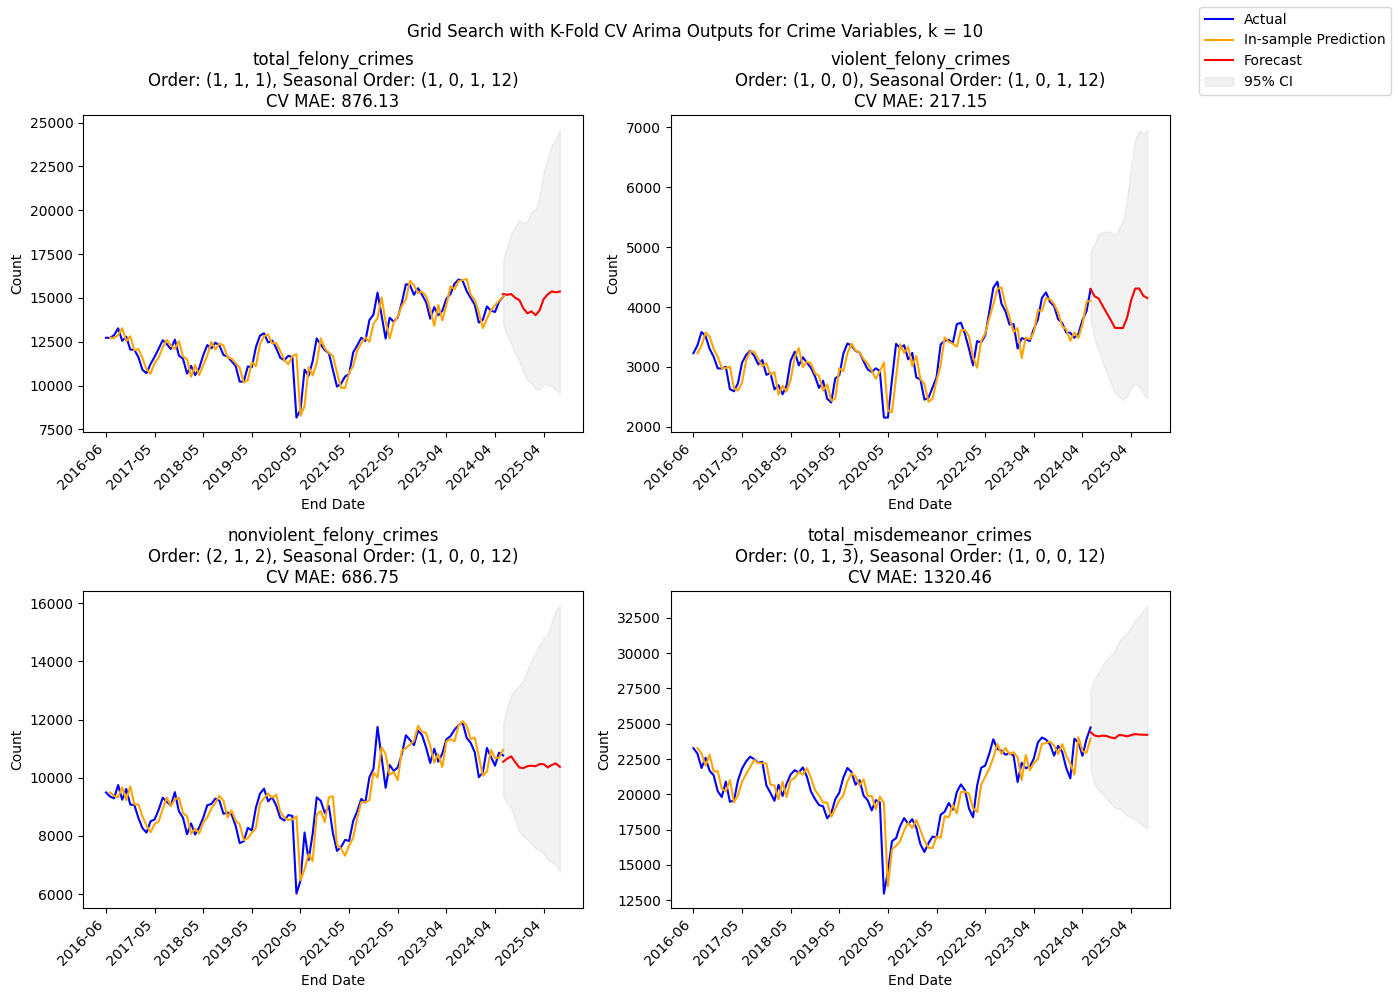

In [70]:
#plot outputs
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plot each crime variable
for i, var in enumerate(crime_vars):
    ax = axes[i]
    data = crime_df[var].dropna()
    y = log_transform(data)
    order = crime_cv_results[var]['model params'][0]
    seasonal_order = crime_cv_results[var]['model params'][1]
    cv_mae = crime_cv_results[var]['mae']

    model = SARIMAX(y, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
        
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    # Generate out-of-sample forecast_exog
    forecast_log = results.get_forecast(steps=n_steps_crime)
    y_forecast_log = forecast_log.predicted_mean
    conf_int_log = forecast_log.conf_int()

    # Bias-adjusted mean forecast back-transformation
    forecast = inverse_log_transform(y_forecast_log)
    #store in dictionary
    crime_cv_results[var]['predictions'] = forecast.values
    # Back-transform confidence intervals
    lower_bound = inverse_log_transform(conf_int_log.iloc[:, 0])
    upper_bound = inverse_log_transform(conf_int_log.iloc[:, 1])

    mae = mean_absolute_error(data,y_pred)

    # Plot the actual data
    ax.plot(data.index, data, label='Actual', color='blue')

    # Plot the in-sample prediction
    ax.plot(data.index[1:], y_pred[1:], label='In-sample Prediction', color='orange')

    # Plot the forecast
    future_dates = pd.date_range(start=data.index[-1], periods=n_steps_crime, freq='30D')
    ax.plot(future_dates, forecast, label='Forecast', color='red')

    # Plot the confidence intervals
    ax.fill_between(future_dates, lower_bound, upper_bound, color='grey', alpha=0.1, label='95% CI')
    
    # Set title and labels, including model parameters
    title = f"{var}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}"
    ax.set_title(title)
    ax.set_xlabel('End Date')
    ax.set_ylabel('Count')

    # Set x-ticks and rotate labels
    dates = pd.date_range(start=data.index[0], periods=len(data)+n_steps_crime, freq='30D')

    ax.set_xticks(dates[::12])
    ax.set_xticklabels(dates[::12].strftime('%Y-%m'), rotation=45, ha='right')

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle(f"Grid Search with K-Fold CV Arima Outputs for Crime Variables, k = {n_splits}")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend
# plt.savefig("../Outputs/grid_search_kfold_cv_arrest_predictions.png", bbox_inches = 'tight')
plt.show()

Now let's plot the residual plots for each of these models

Computed the residuals for total_felony_crimes
Done plotting subplots for total_felony_crimes
Computed the residuals for violent_felony_crimes
Done plotting subplots for violent_felony_crimes
Computed the residuals for nonviolent_felony_crimes
Done plotting subplots for nonviolent_felony_crimes
Computed the residuals for total_misdemeanor_crimes
Done plotting subplots for total_misdemeanor_crimes


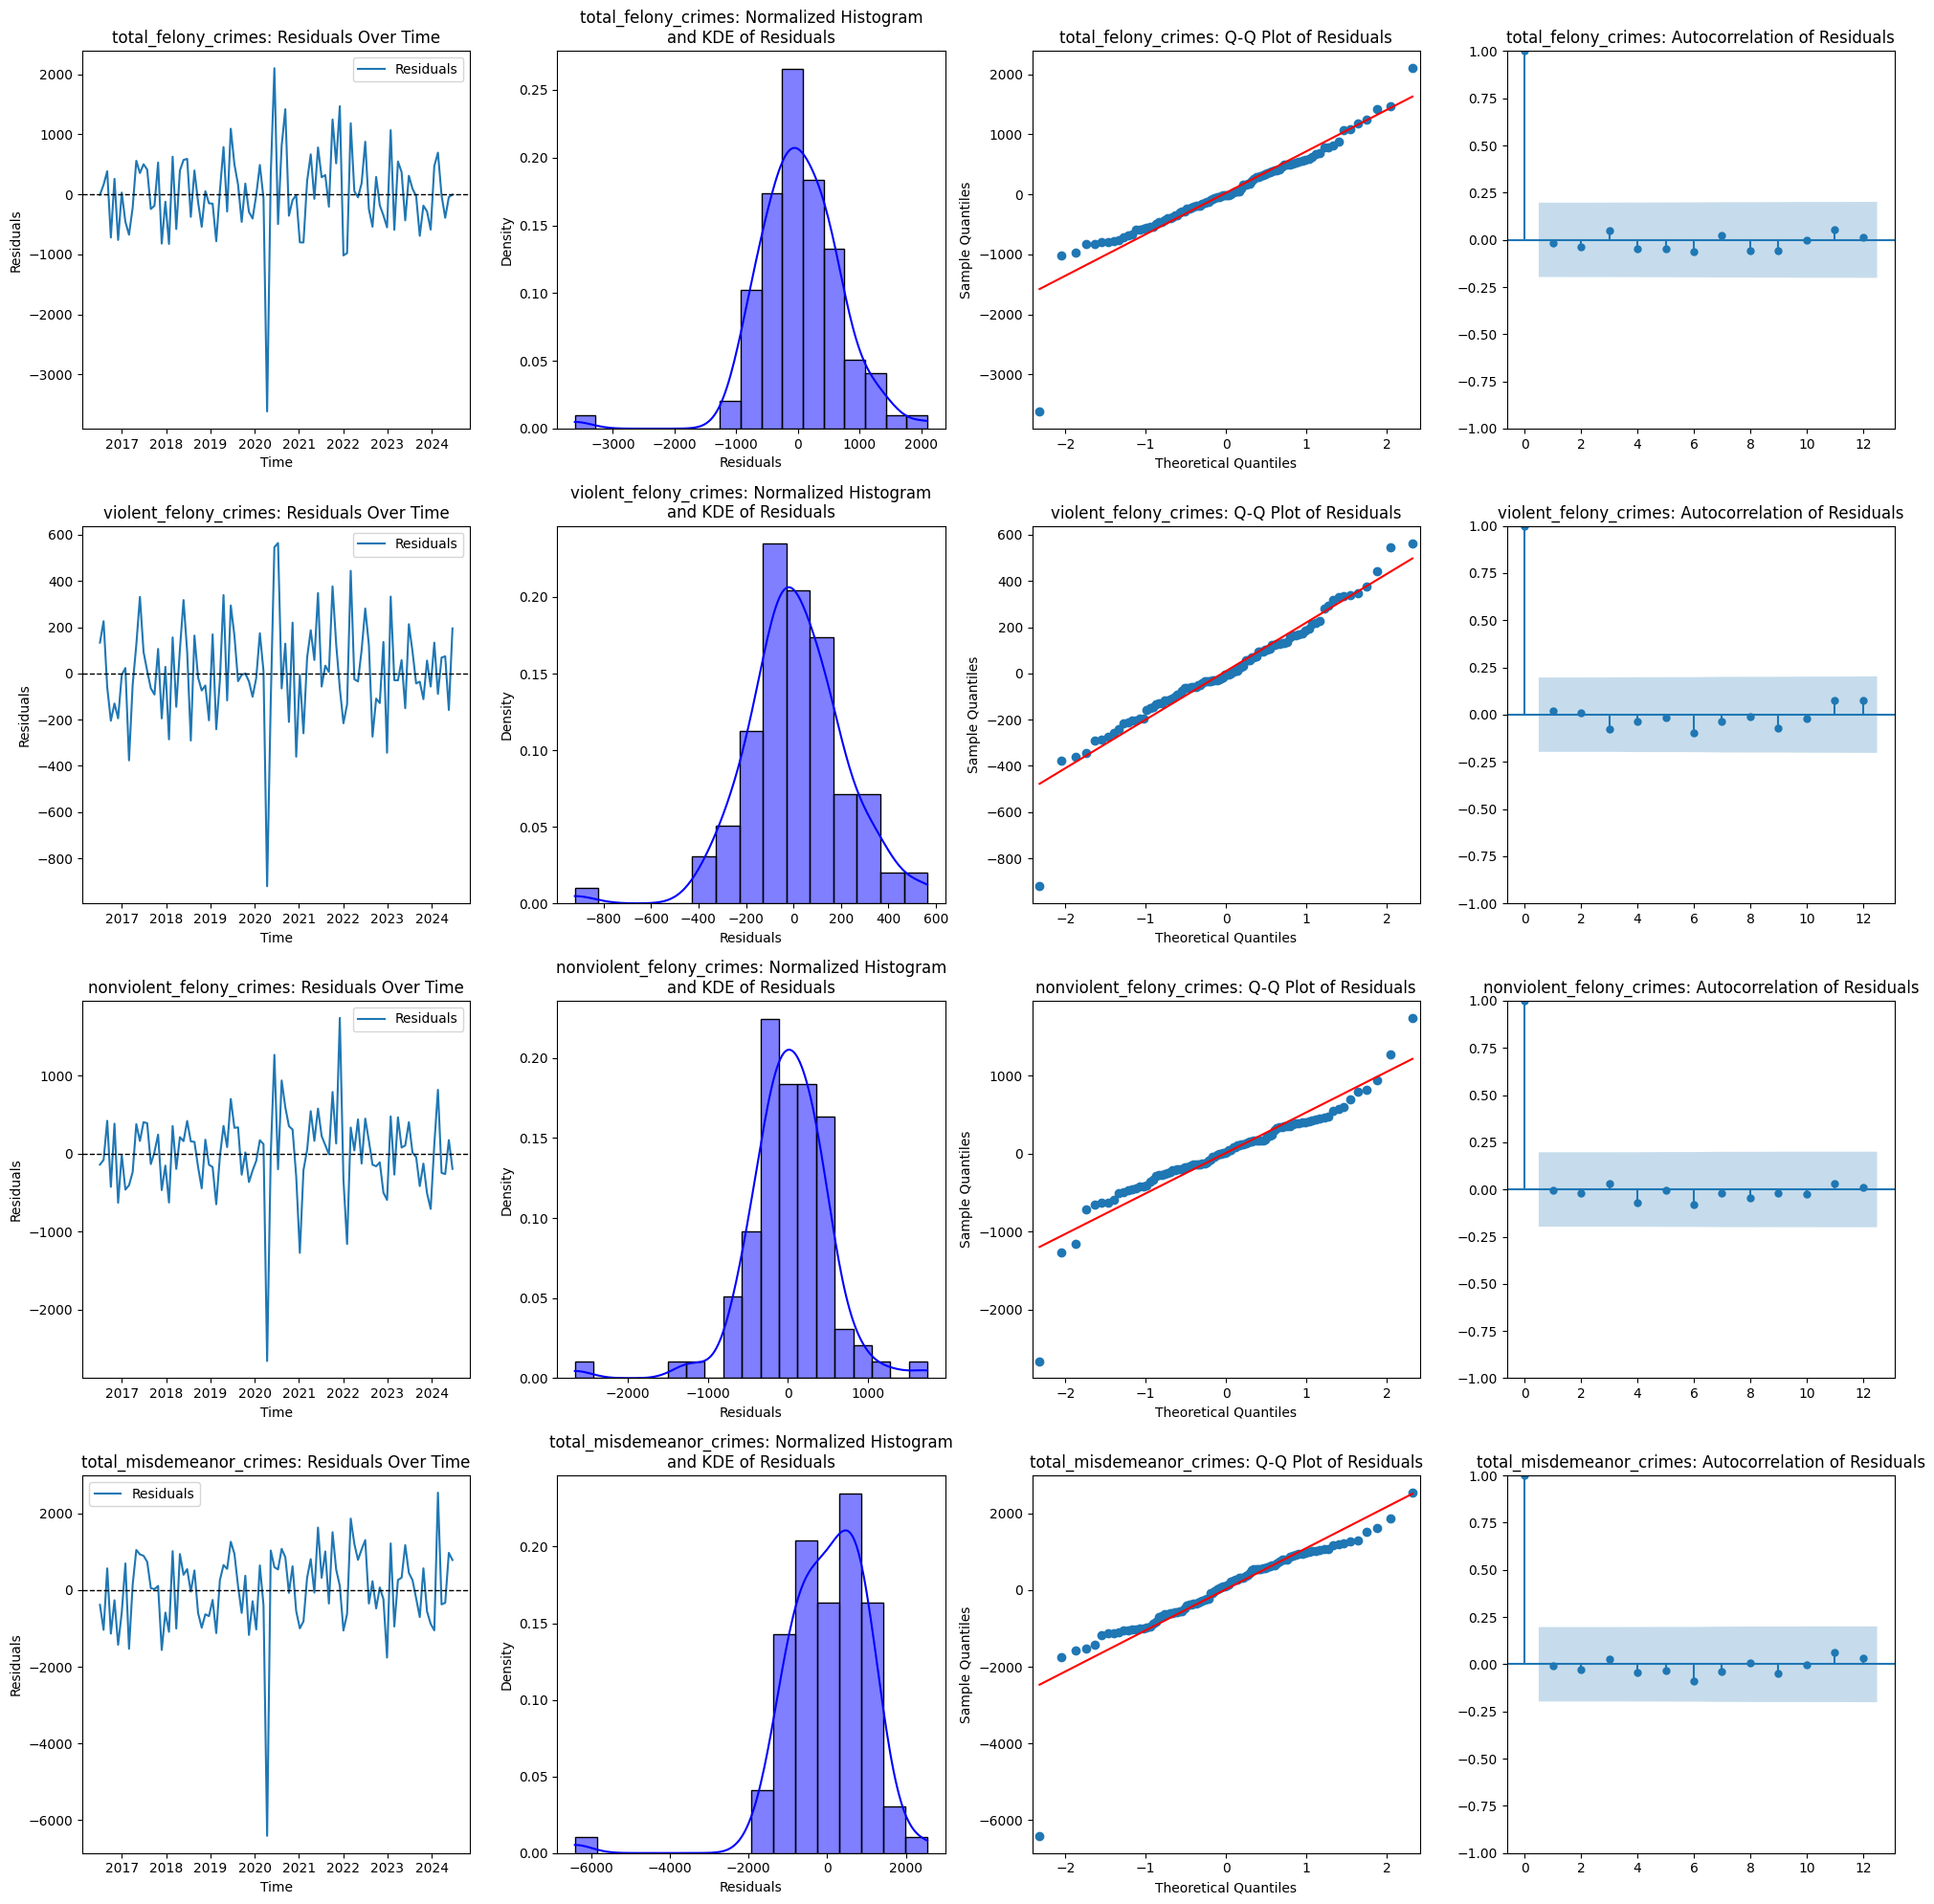

In [71]:
# Create auto_arima model
#iterate through crime variables and store output in new dictionary
auto_arima_dict = {}
fig, axs = plt.subplots(len(crime_vars), 4, figsize=(20, 5 * len(crime_vars)))

for i, var in enumerate(crime_vars):
    data = crime_df[var].dropna()
    y = log_transform(data)
    order = crime_cv_results[var]['model params'][0]
    seasonal_order = crime_cv_results[var]['model params'][1]
    cv_mae = crime_cv_results[var]['mae']

    model = SARIMAX(y, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
        
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    # Calculate residuals
    residuals = crime_df[var].dropna() - y_pred
    
    #plot residual diagnostics
    print(f'Computed the residuals for {var}')
    # Residuals over time
    axs[i, 0].plot(residuals.index[1:], residuals[1:], label='Residuals')
    axs[i, 0].axhline(0, linestyle='--', color='black', linewidth=1)
    axs[i, 0].set_title(f'{var}: Residuals Over Time')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('Residuals')
    axs[i, 0].legend()
    
    # Histogram and KDE plot of residuals
    sns.histplot(residuals[1:], kde=True,stat='probability', ax=axs[i, 1], color='blue')
    axs[i, 1].set_title(f'{var}: Normalized Histogram\nand KDE of Residuals')
    axs[i, 1].set_xlabel('Residuals')
    axs[i, 1].set_ylabel('Density')
    
    # Q-Q plot of residuals
    sm.qqplot(residuals[1:], line='s', ax=axs[i, 2])
    axs[i, 2].set_title(f'{var}: Q-Q Plot of Residuals')
    
    # ACF plot of residuals
    sm.graphics.tsa.plot_acf(residuals, lags=12, ax=axs[i, 3])
    axs[i, 3].set_title(f'{var}: Autocorrelation of Residuals')
    print(f'Done plotting subplots for {var}')
# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

I like these results. There seems to be a bit of over fitting based on the QQ plot but I think it is suitable for our use case. Now we will do the same but with the arrest variables and use the crime variables as exogenous vars.

### Arrest Metrics

In [72]:
#specify arrest vars and data
# Define the crime variables
arrest_vars = {
    'total_felony_arrest': 'total_felony_crimes',
    'violent_felony_arrest': 'violent_felony_crimes',
    'nonviolent_felony_arrest': 'nonviolent_felony_crimes',
    'total_misdemeanor_arrest': 'total_misdemeanor_crimes'
}
arrest_df = joined_df[['End Date']+list(arrest_vars.keys())].dropna()
arrest_df.set_index('End Date', inplace=True)

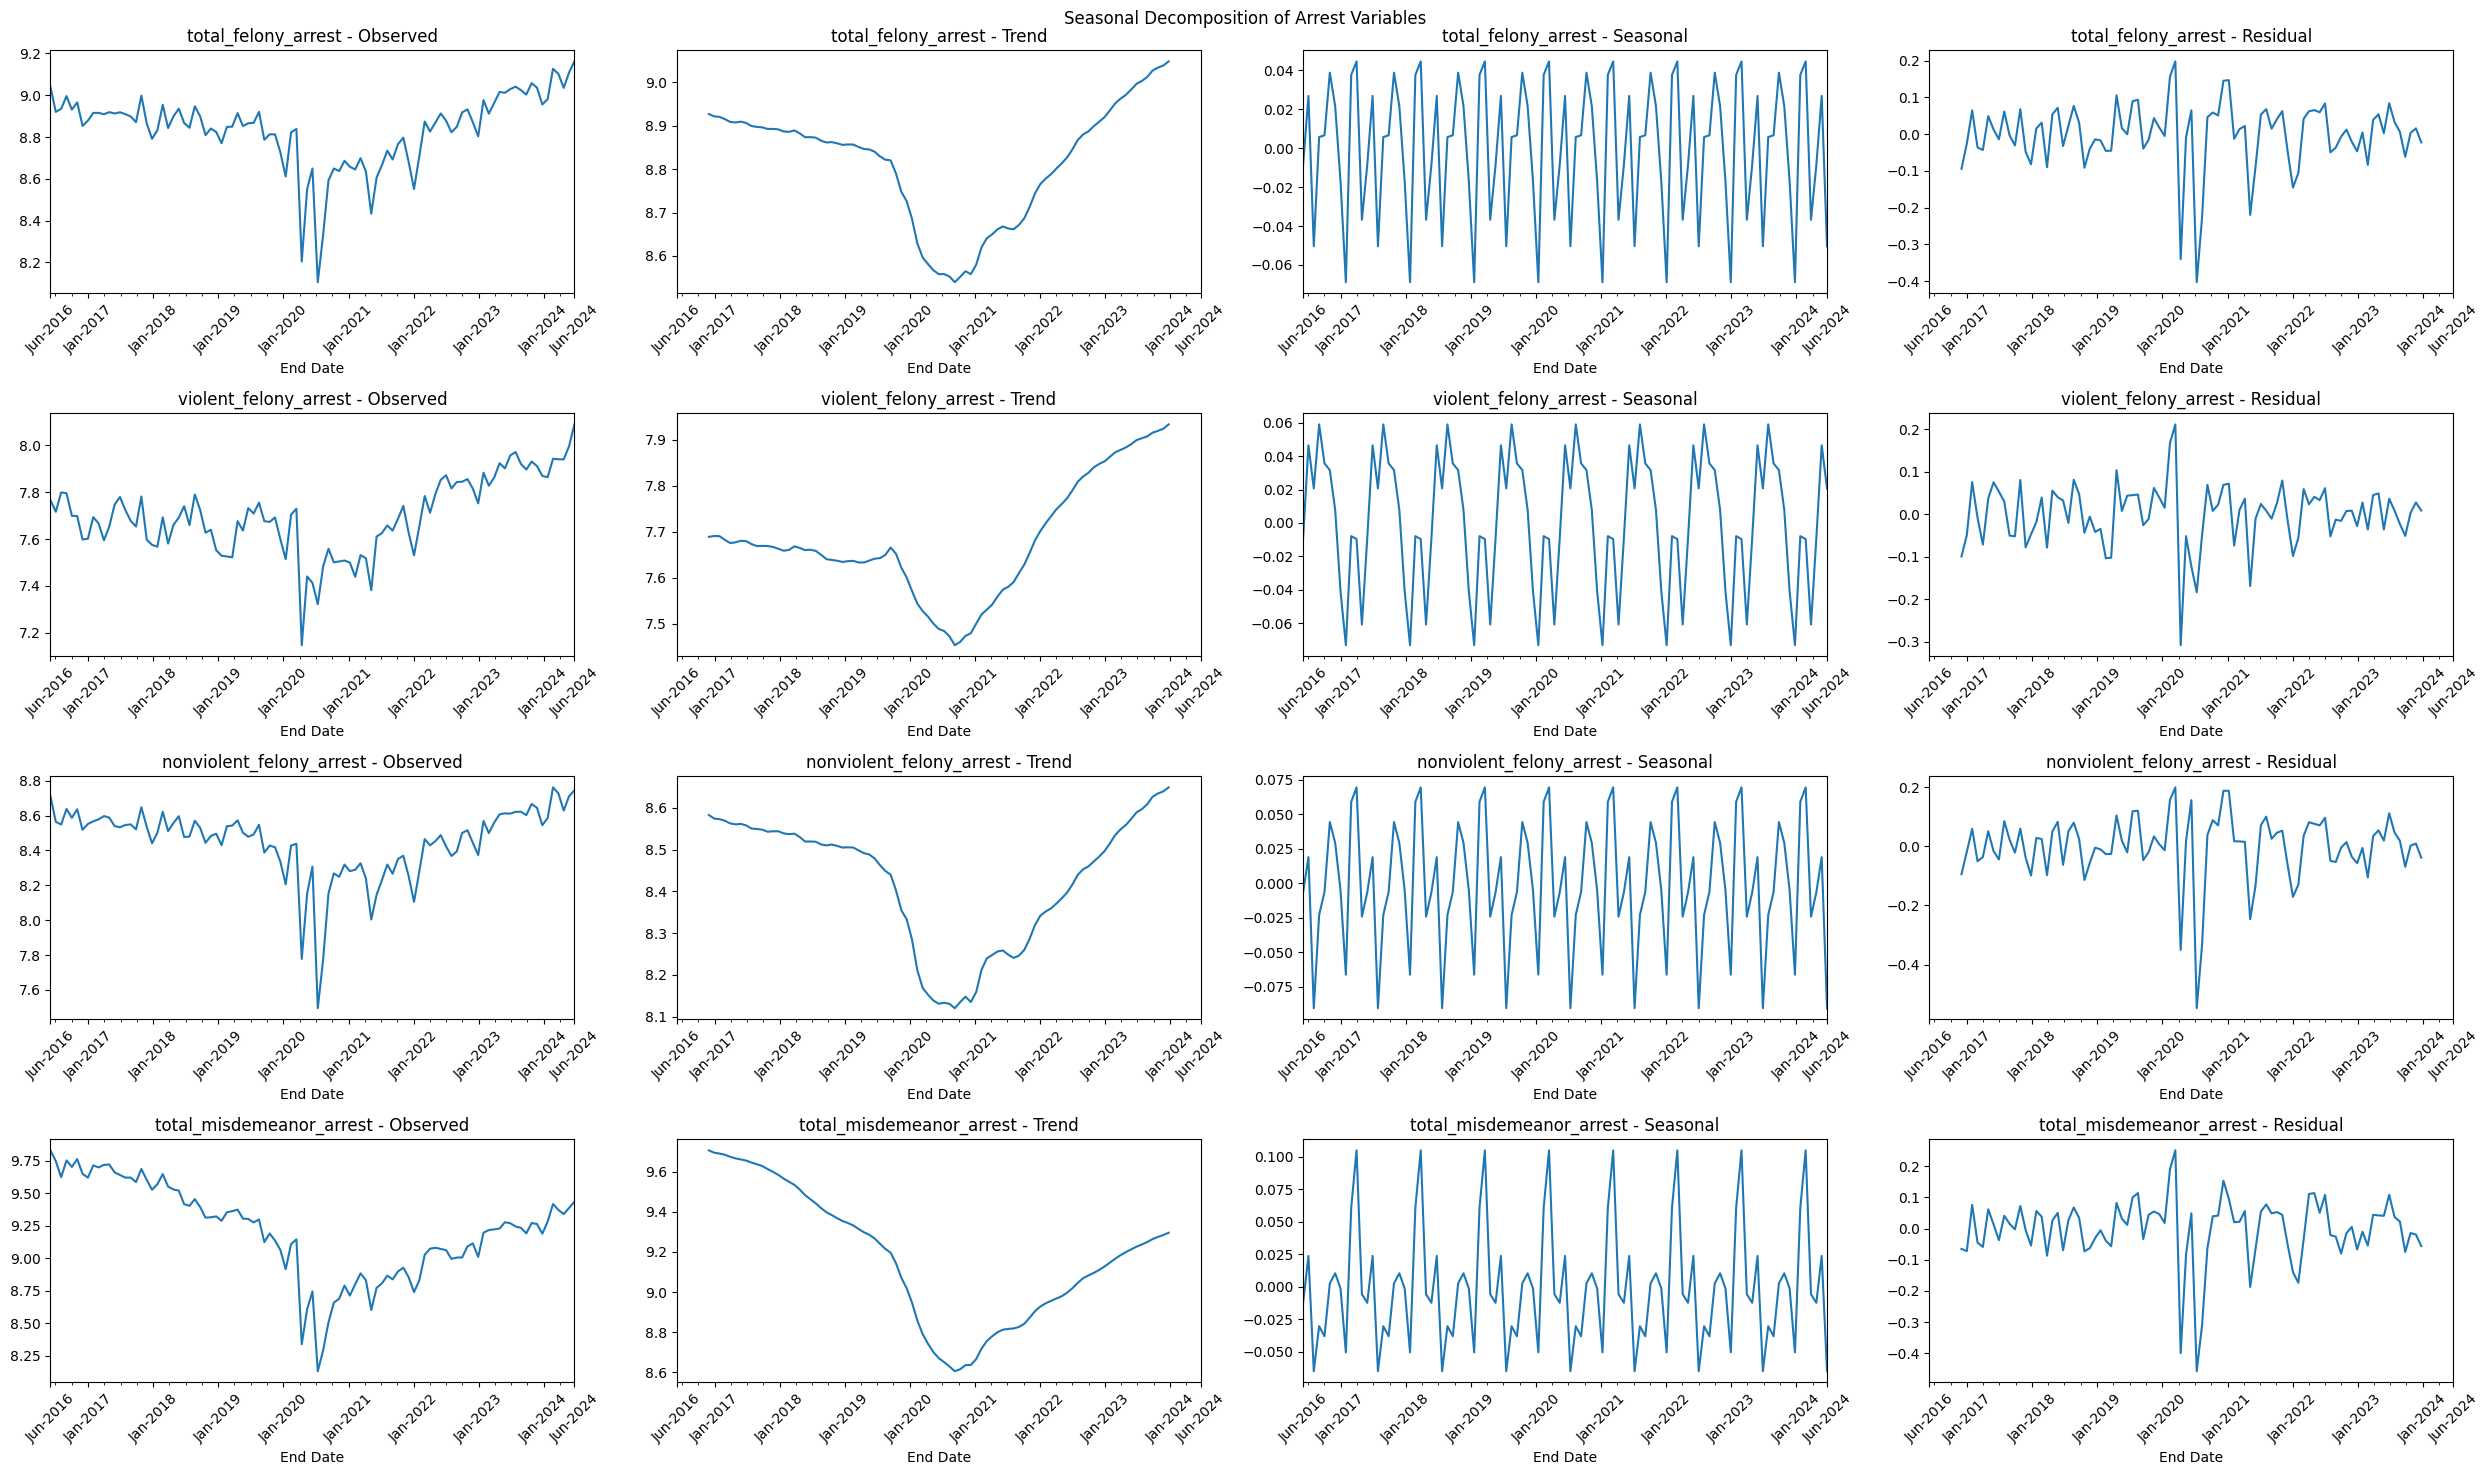

In [73]:

# Set up the figure with a 4x4 grid of subplots
fig, axes = plt.subplots(len(arrest_vars), 4, figsize=(25, 15))

# Iterate through each crime variable
for i, var in enumerate(arrest_vars):
    # Perform seasonal decomposition
    result = seasonal_decompose(log_transform(arrest_df[var].dropna()), model='additive', period=12)  # Adjust 'period' according to your data
    
    # Plot each component in a separate subplot
    result.observed.plot(ax=axes[i, 0], legend=False, title=f'{var} - Observed')
    result.trend.plot(ax=axes[i, 1], legend=False, title=f'{var} - Trend')
    result.seasonal.plot(ax=axes[i, 2], legend=False, title=f'{var} - Seasonal')
    result.resid.plot(ax=axes[i, 3], legend=False, title=f'{var} - Residual')

    for j in range(4):
        axes[i, j].set_xlabel('End Date')
        axes[i, j].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b-%Y'))
        axes[i, j].tick_params(axis='x', rotation=45)

# Adjust layout
plt.suptitle('Seasonal Decomposition of Arrest Variables')
plt.tight_layout()
plt.show()

In [74]:
# Find and evaluate SARIMA models for each arrest variable with exogenous crime variables
arrest_cv_models = {}

for arrest_var, exog_var in arrest_vars.items():
    y = log_transform(arrest_df[arrest_var].dropna())
    exog = log_transform(crime_df[exog_var].dropna())
    
    # Ensure the exog variable has the same index as the target variable
    exog = exog.loc[y.index]
    
    best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits, exog=exog)
    
    arrest_cv_models[arrest_var] = {'exog' : exog_var, 'result': best_result, 'model params': best_params, 'mae': best_score}
    print(f"Best model for {arrest_var}: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                                      SARIMAX Results                                      
Dep. Variable:                 total_felony_arrest   No. Observations:                   90
Model:             SARIMAX(2, 1, 1)x(1, 0, [], 12)   Log Likelihood                  89.287
Date:                             Fri, 20 Sep 2024   AIC                           -166.574
Time:                                     09:59:06   BIC                           -151.642
Sample:                                 06-03-2016   HQIC                          -160.555
                                      - 09-25-2023                                         
Covariance Type:                               opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
total_felony_crimes     0.9158      0.090     10.223      0.000       0.740       1.091


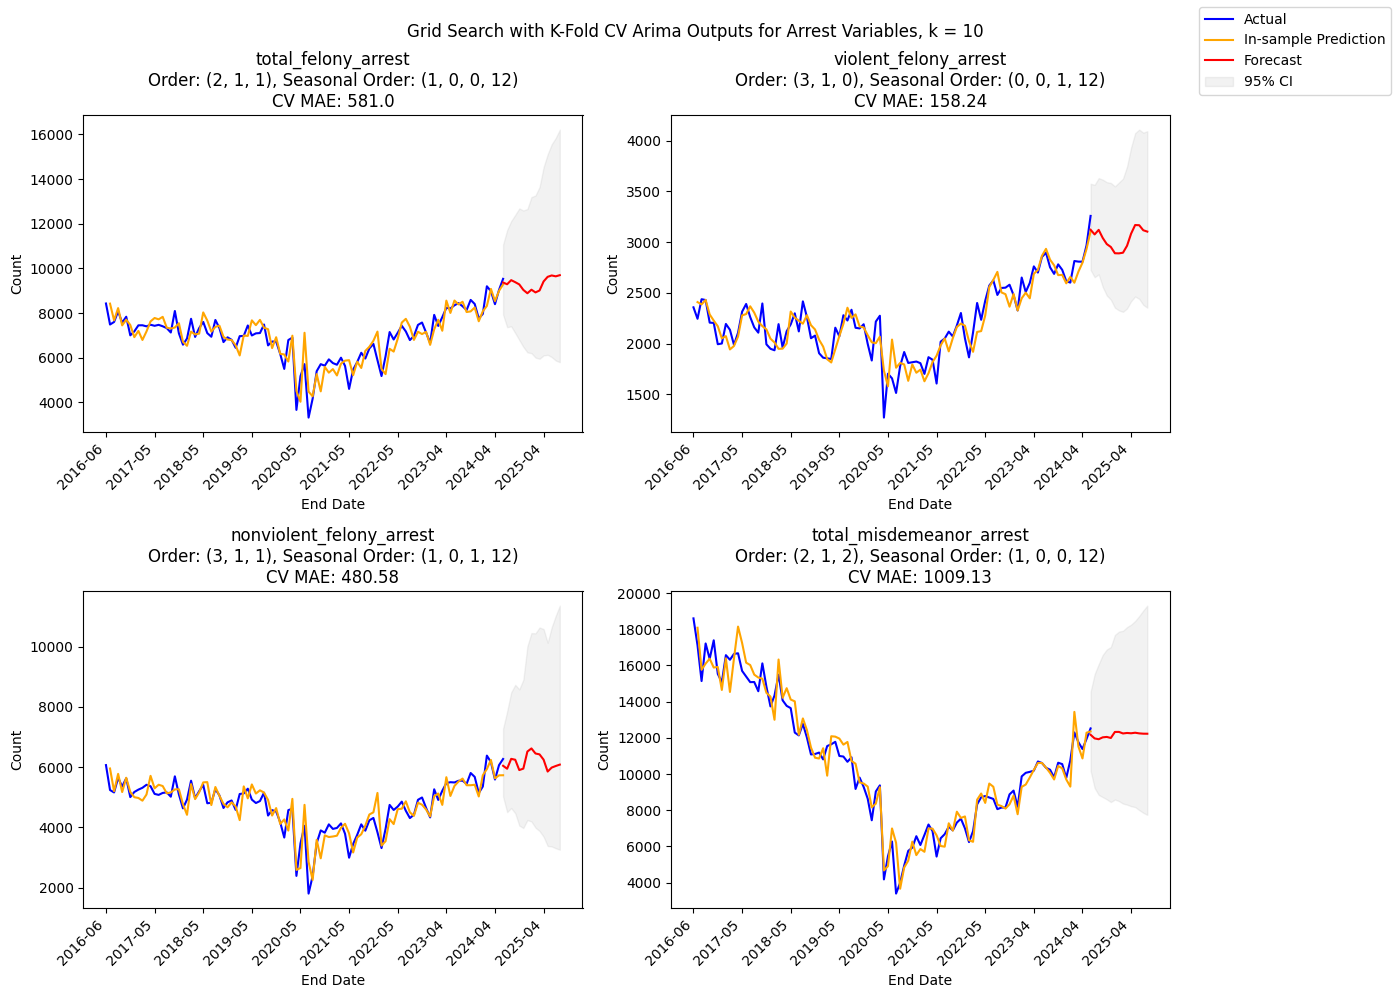

In [75]:
#plot
#plot outputs
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plot each crime arrest_variable

for i, (arrest_var, exog_var) in enumerate(arrest_vars.items()):
    ax = axes[i]
    data = arrest_df[arrest_var].dropna()
    exog = log_transform(crime_df[exog_var].dropna())
    y = log_transform(data)
    # Ensure the exog arrest_variable has the same index as the target arrest_variable
    exog = exog.loc[y.index]

    order = arrest_cv_models[arrest_var]['model params'][0]
    seasonal_order = arrest_cv_models[arrest_var]['model params'][1]
    cv_mae = arrest_cv_models[arrest_var]['mae']

    model = SARIMAX(y,exog = exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    
    #get exog_preds
    exog_forecast = crime_cv_results[exog_var]['predictions']
    exog_forecast_log = log_transform(exog_forecast)
    
    #now predict target var
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    # Generate out-of-sample forecast_exog
    forecast_log = results.get_forecast(steps=n_steps_arr, exog = exog_forecast_log)
    y_forecast_log = forecast_log.predicted_mean
    conf_int_log = forecast_log.conf_int()

    # Bias-adjusted mean forecast back-transformation
    forecast = inverse_log_transform(y_forecast_log)

    # Back-transform confidence intervals
    lower_bound = inverse_log_transform(conf_int_log.iloc[:, 0])
    upper_bound = inverse_log_transform(conf_int_log.iloc[:, 1])

    IS_mae = mean_absolute_error(data.iloc[1:],y_pred.iloc[1:])

    # Plot the actual data
    ax.plot(data.index, data, label='Actual', color='blue')

    # Plot the in-sample prediction
    ax.plot(data.index[1:], y_pred[1:], label='In-sample Prediction', color='orange')

    # Plot the forecast
    future_dates = pd.date_range(start=data.index[-1], periods=n_steps_arr, freq='30D')
    ax.plot(future_dates, forecast, label='Forecast', color='red')

    # Plot the confidence intervals
    ax.fill_between(future_dates, lower_bound, upper_bound, color='grey', alpha=0.1, label='95% CI')
    
    # Set title and labels, including model parameters
    title = f"{arrest_var}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}"
    ax.set_title(title)
    ax.set_xlabel('End Date')
    ax.set_ylabel('Count')

    # Set x-ticks and rotate labels
    dates = pd.date_range(start=data.index[0], periods=len(data)+n_steps_arr, freq='30D')

    ax.set_xticks(dates[::12])
    ax.set_xticklabels(dates[::12].strftime('%Y-%m'), rotation=45, ha='right')

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle(f"Grid Search with K-Fold CV Arima Outputs for Arrest Variables, k = {n_splits}")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend
# plt.savefig("../Outputs/grid_search_kfold_cv_arrest_predictions.png", bbox_inches = 'tight')
plt.show()

Let's plot the residual diagnostics

Computed the residuals for total_felony_arrest
Done plotting subplots for total_felony_arrest
Computed the residuals for violent_felony_arrest
Done plotting subplots for violent_felony_arrest
Computed the residuals for nonviolent_felony_arrest
Done plotting subplots for nonviolent_felony_arrest
Computed the residuals for total_misdemeanor_arrest
Done plotting subplots for total_misdemeanor_arrest


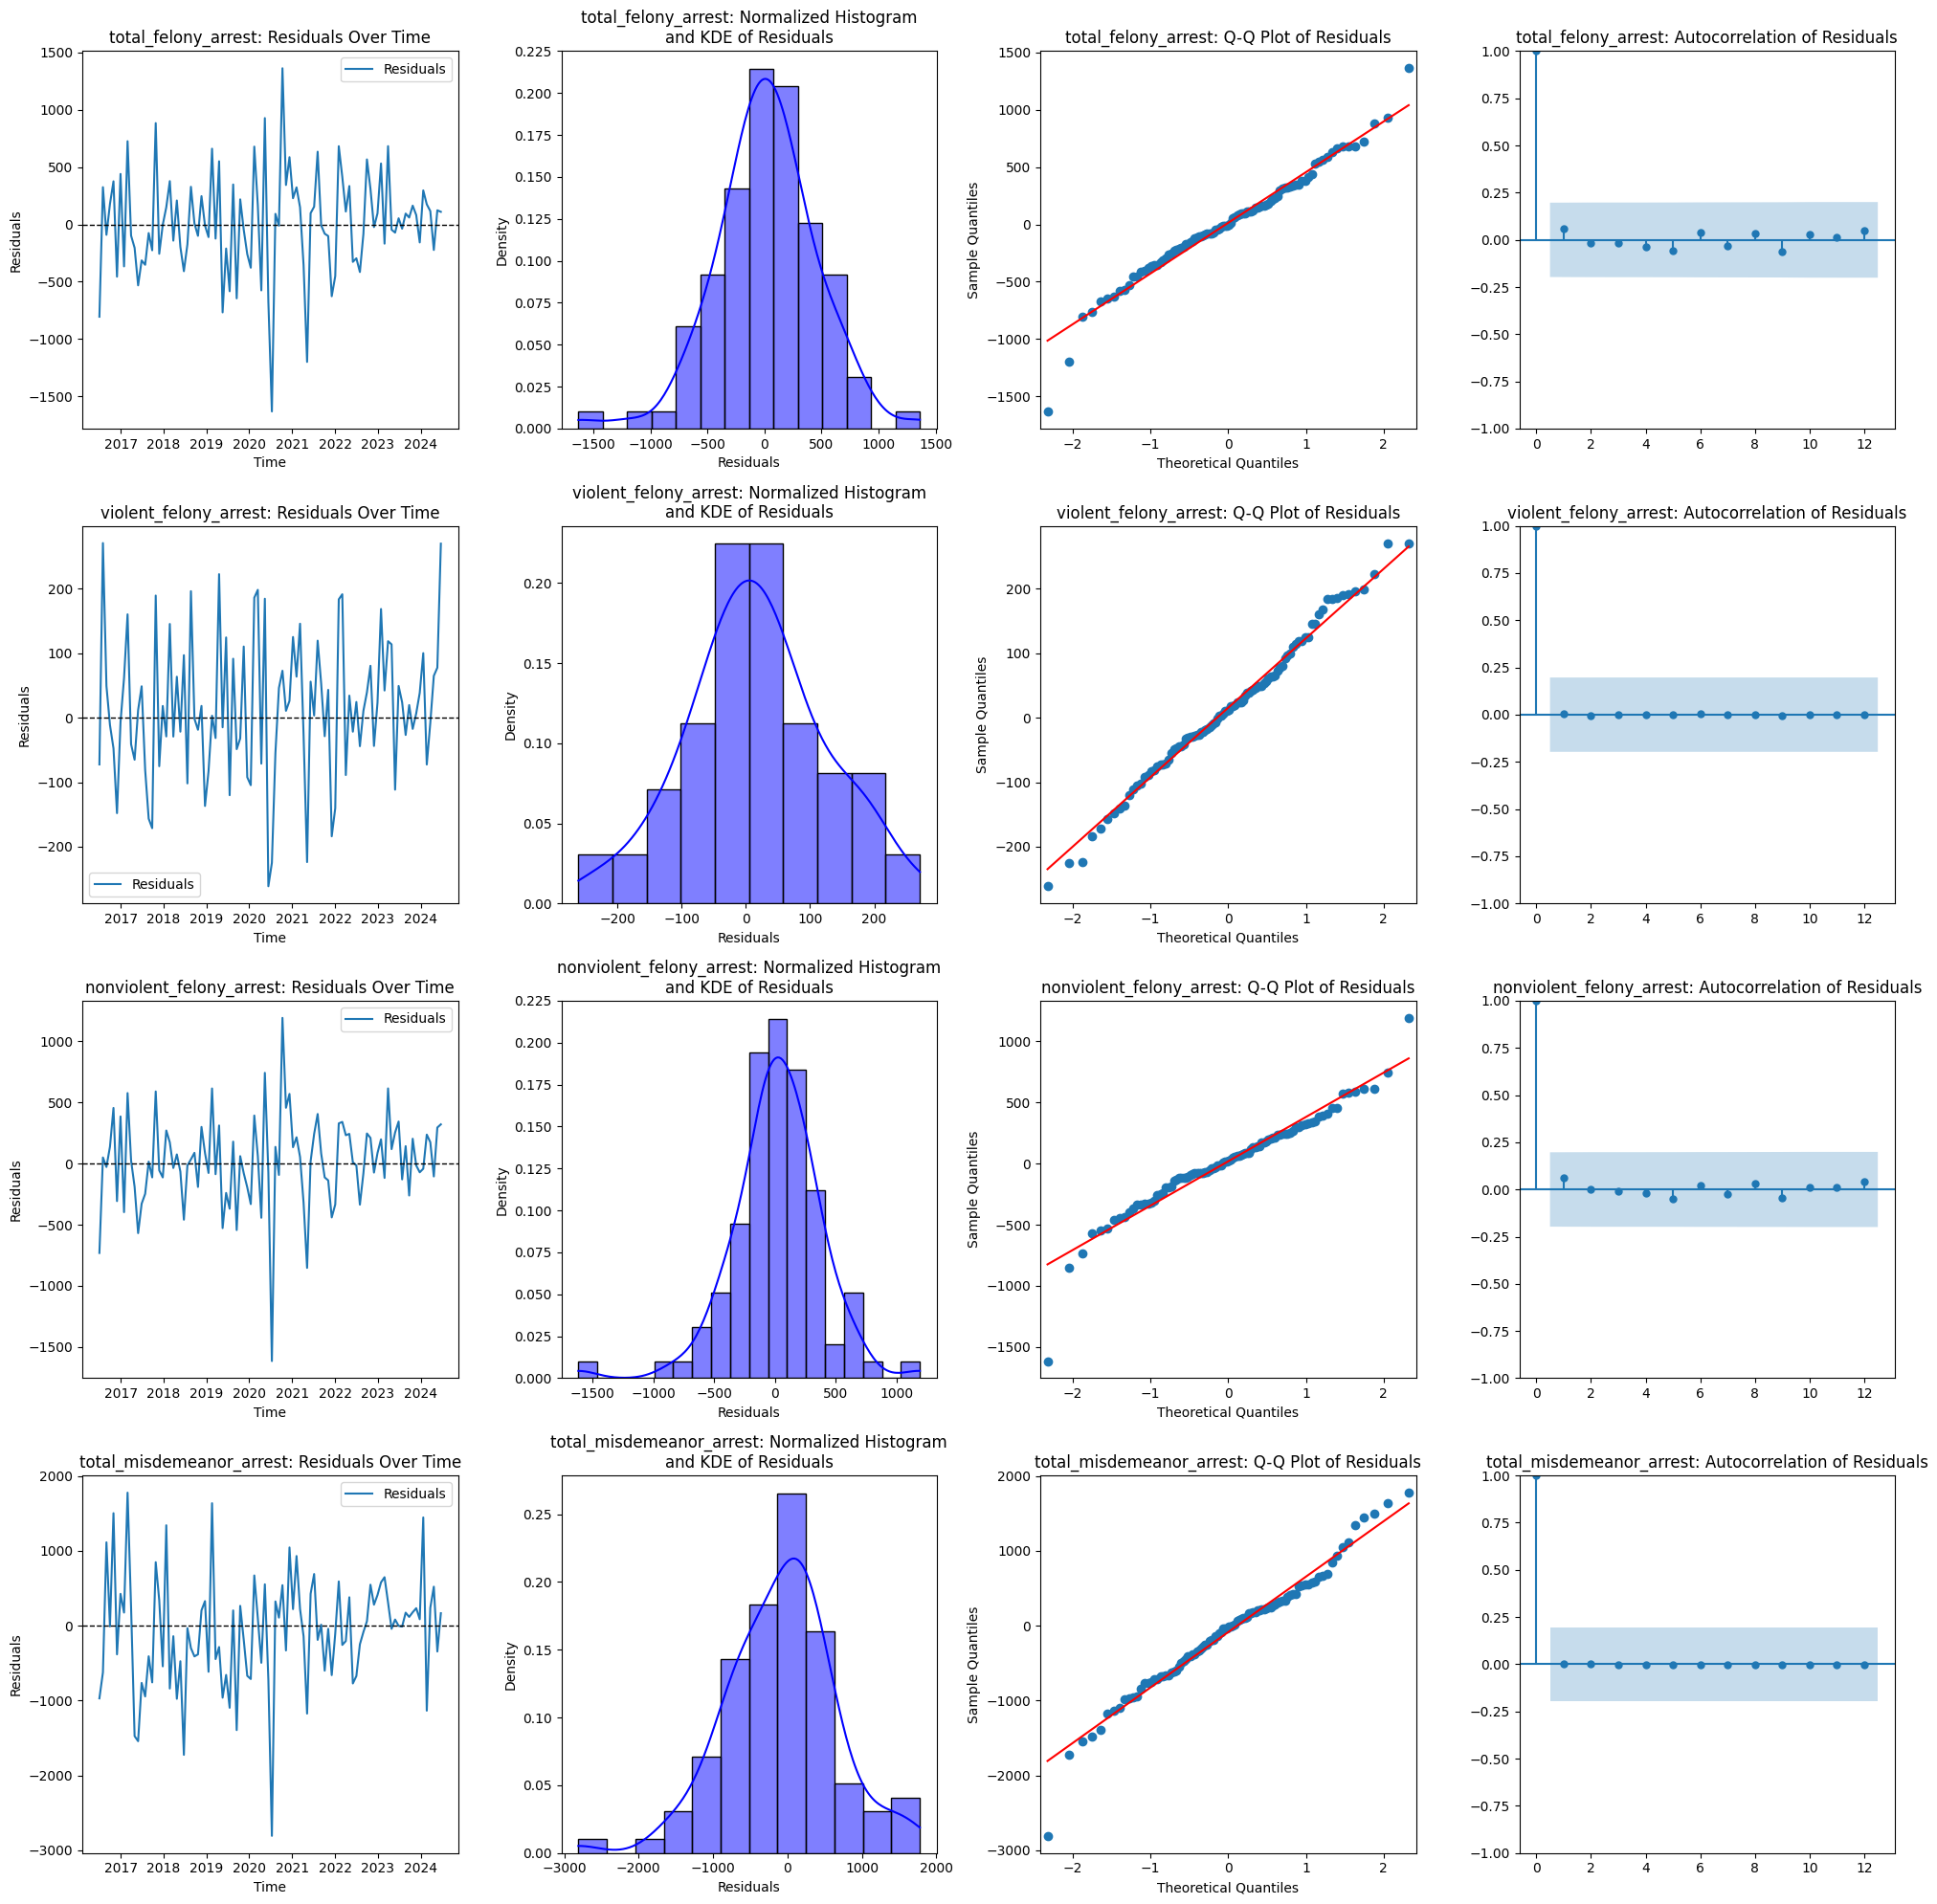

In [76]:
fig, axs = plt.subplots(len(arrest_vars), 4, figsize=(20, 5 * len(arrest_vars)))

    
for i, (arrest_var,crime_var) in enumerate(arrest_vars.items()):
    data = arrest_df[arrest_var].dropna()
    y = log_transform(data)

    exog = log_transform(crime_df[exog_var].dropna())
    # Ensure the exog arrest_variable has the same index as the target arrest_variable
    exog = exog.loc[y.index]

    order = arrest_cv_models[arrest_var]['model params'][0]
    seasonal_order = arrest_cv_models[arrest_var]['model params'][1]

    model = SARIMAX(y, exog = exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
        
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    # Calculate residuals
    residuals = arrest_df[arrest_var].dropna() - y_pred

    #plot residual diagnostics
    print(f'Computed the residuals for {arrest_var}')
    # Residuals over time
    axs[i, 0].plot(residuals.index[1:], residuals[1:], label='Residuals')
    axs[i, 0].axhline(0, linestyle='--', color='black', linewidth=1)
    axs[i, 0].set_title(f'{arrest_var}: Residuals Over Time')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('Residuals')
    axs[i, 0].legend()
    
    # Histogram and KDE plot of residuals
    sns.histplot(residuals[1:], kde=True,stat='probability', ax=axs[i, 1], color='blue')
    axs[i, 1].set_title(f'{arrest_var}: Normalized Histogram\nand KDE of Residuals')
    axs[i, 1].set_xlabel('Residuals')
    axs[i, 1].set_ylabel('Density')
    
    # Q-Q plot of residuals
    sm.qqplot(residuals[1:], line='s', ax=axs[i, 2])
    axs[i, 2].set_title(f'{arrest_var}: Q-Q Plot of Residuals')
    
    # ACF plot of residuals
    sm.graphics.tsa.plot_acf(residuals, lags=12, ax=axs[i, 3])
    axs[i, 3].set_title(f'{arrest_var}: Autocorrelation of Residuals')
    print(f'Done plotting subplots for {arrest_var}')
# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

### Repeat the arrest methods without any exogenous variables

I am curious to see whether including the historical 30-day crime counts in our model is benefitting our models

In [77]:
# Find and evaluate SARIMA models for each arrest variable with NO exogenous crime variables
for arrest_var in arrest_vars.keys():
    y = log_transform(arrest_df[arrest_var].dropna())
    
    best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits)
    
    arrest_cv_models[arrest_var+'_no_exog'] = {'exog' : None, 'result': best_result, 'model params': best_params, 'mae': best_score}
    print(f"Best model for {arrest_var}: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                                SARIMAX Results                                
Dep. Variable:     total_felony_arrest   No. Observations:                   90
Model:                SARIMAX(1, 1, 0)   Log Likelihood                  60.848
Date:                 Fri, 20 Sep 2024   AIC                           -117.697
Time:                         10:20:17   BIC                           -112.719
Sample:                     06-03-2016   HQIC                          -115.690
                          - 09-25-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2792      0.084     -3.312      0.001      -0.444      -0.114
sigma2         0.0149      0.001     16.088      0.000       0.013       0.017
Ljung-Box (L1) (Q):                   2.31  

In [78]:
arrest_cv_models

{'total_felony_arrest': {'exog': 'total_felony_crimes',
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x132934c8810>,
  'model params': ((2, 1, 1), (1, 0, 0, 12)),
  'mae': 581.0019672110514},
 'violent_felony_arrest': {'exog': 'violent_felony_crimes',
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13297e11fd0>,
  'model params': ((3, 1, 0), (0, 0, 1, 12)),
  'mae': 158.24334737303067},
 'nonviolent_felony_arrest': {'exog': 'nonviolent_felony_crimes',
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13297d28950>,
  'model params': ((3, 1, 1), (1, 0, 1, 12)),
  'mae': 480.5801077172613},
 'total_misdemeanor_arrest': {'exog': 'total_misdemeanor_crimes',
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1329757bf50>,
  'model params': ((2, 1, 2), (1, 0, 0, 12)),
  'mae': 1009.1253123093469},
 'total_felony_arrest_no_exog': {'exog': None,
  'result': <statsmodels.tsa.statespace.sarimax

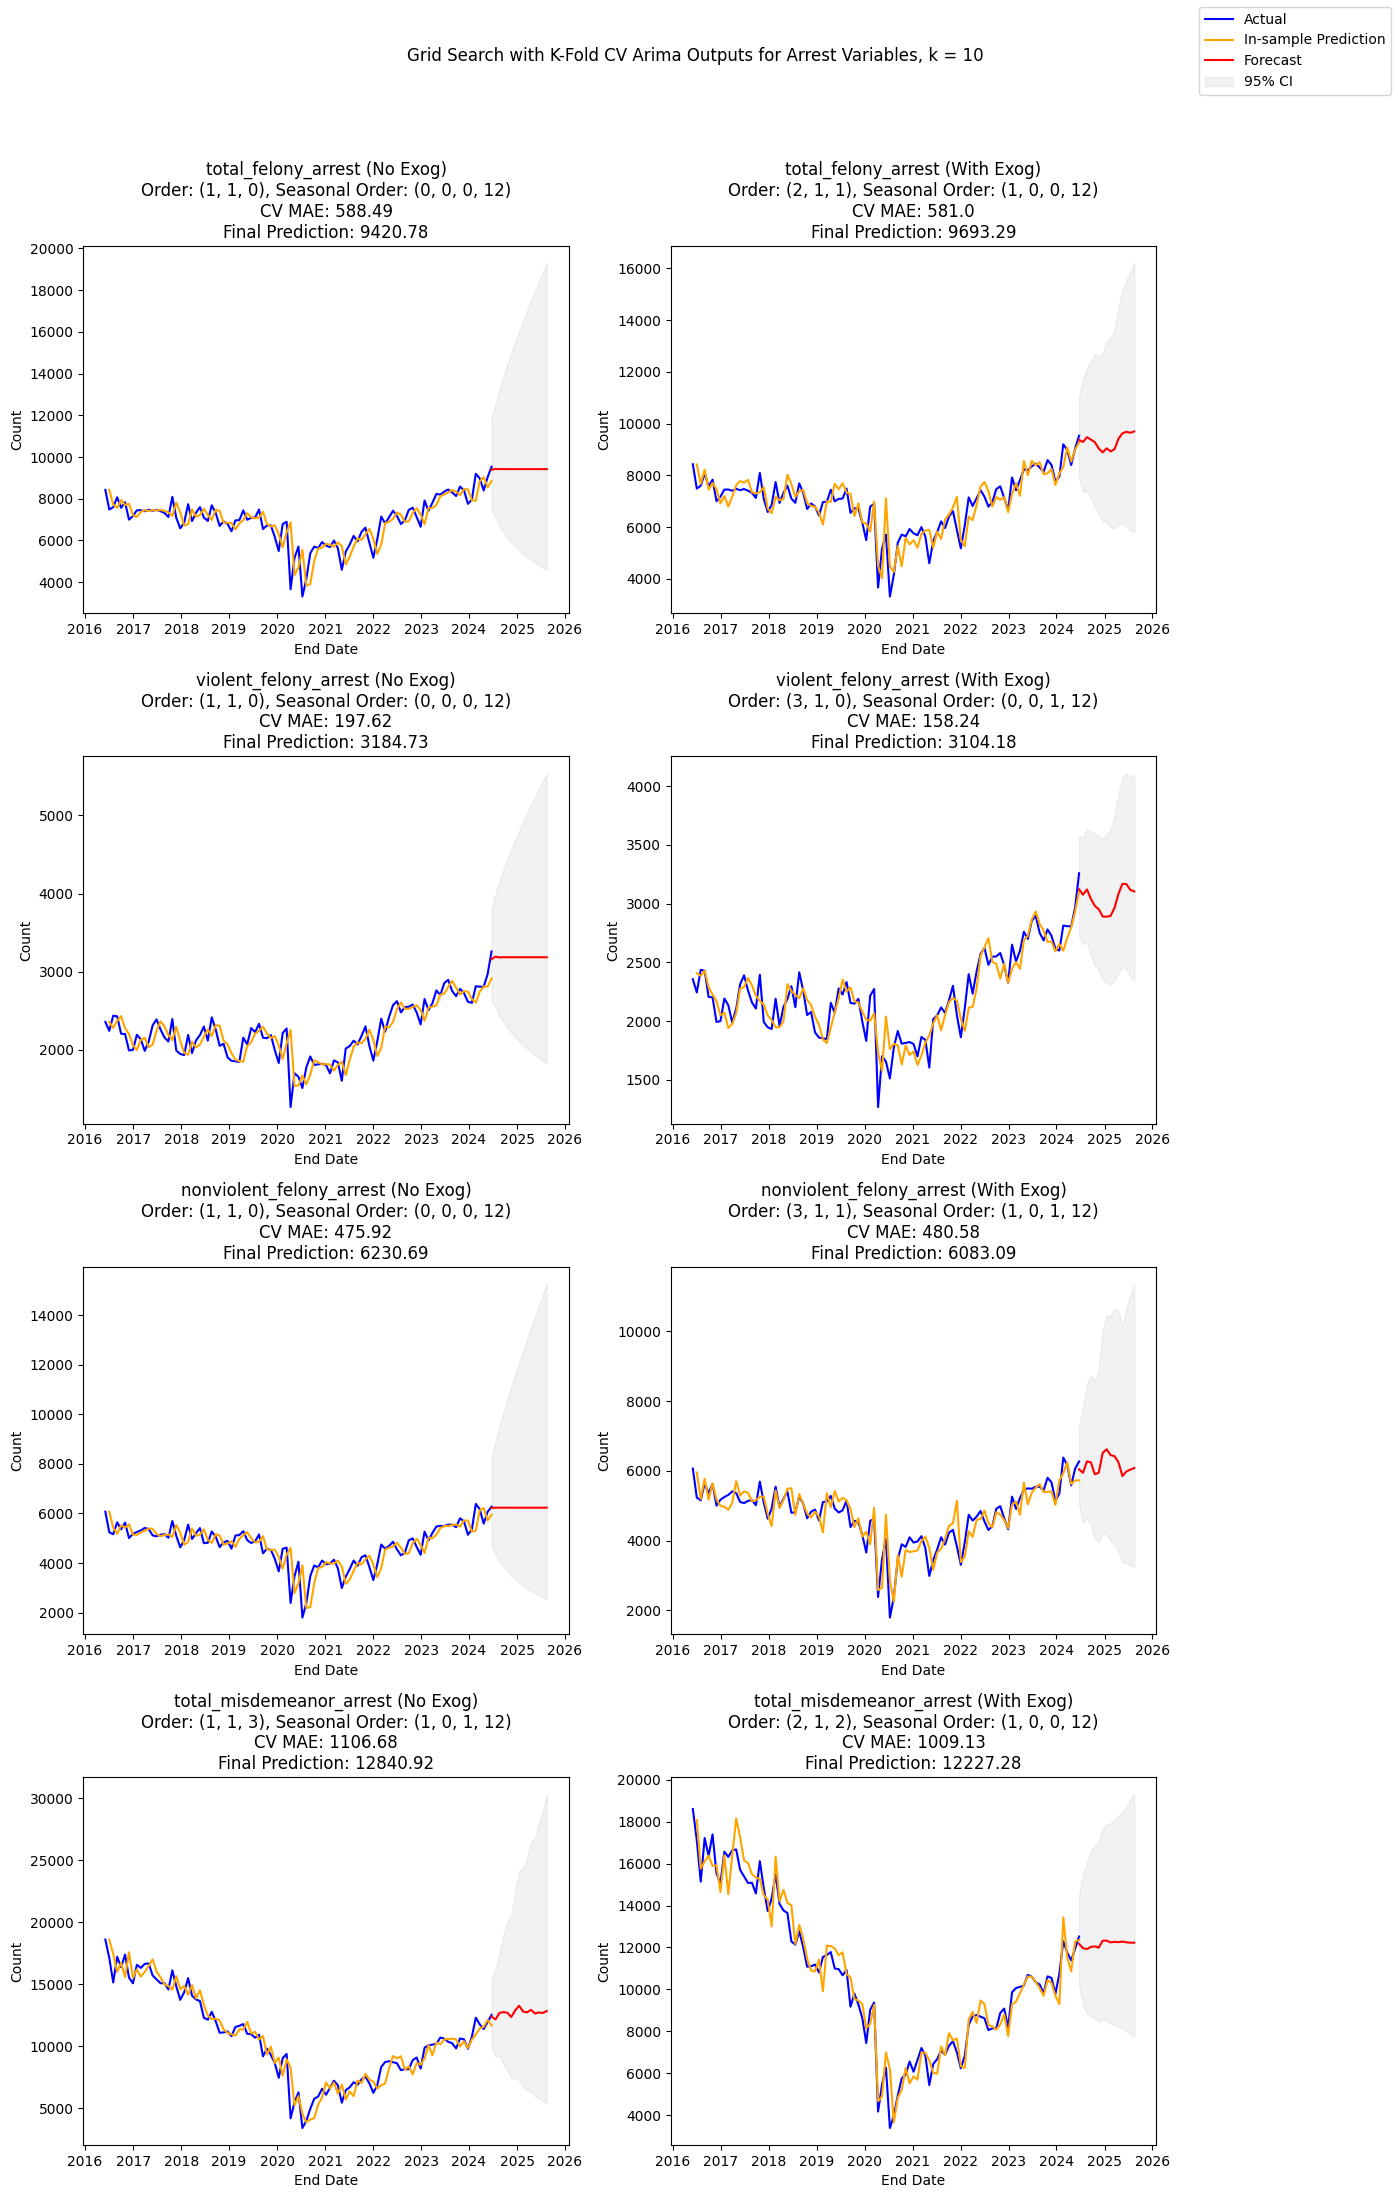

In [79]:
# Define your list of arrest variables

# Set up the subplots (4x2 grid)
fig, axes = plt.subplots(4, 2, figsize=(14, 22))
axes = axes.flatten()

# Iterate over each arrest variable
for i, (arrest_var, exog_var) in enumerate(arrest_vars.items()):
    # Access the models with and without exogenous variables
    model_with_exog = arrest_cv_models[arrest_var]
    model_without_exog = arrest_cv_models[arrest_var + '_no_exog']
    
    # Retrieve data and predictions
    data = arrest_df[arrest_var].dropna()
    y = log_transform(data)
    #exog variable
    exog = log_transform(crime_df[exog_var].dropna())

    # Ensure the exog arrest_variable has the same index as the target arrest_variable
    exog = exog.loc[y.index]

    # Plot without exogenous variables (left column)
    ax_no_exog = axes[i * 2]
    model_no_exog = SARIMAX(y,order=model_without_exog['model params'][0], seasonal_order=model_without_exog['model params'][1])
    results_no_exog = model_no_exog.fit(disp=False)
    predictions_no_exog = results_no_exog.predict(start=y.index[0], end=y.index[-1])
    y_pred_no_exog = inverse_log_transform(predictions_no_exog)
    #get forecast
    forecast_no_exog = results_no_exog.get_forecast(steps=n_steps_arr).predicted_mean
    conf_int_no_exog = results_no_exog.get_forecast(steps=n_steps_arr).conf_int()
    #save to dictionary
    arrest_cv_models[arrest_var + '_no_exog']['predictions'] = inverse_log_transform(forecast_no_exog.values)
    
    # Back-transform confidence intervals
    lower_bound_no_exog = inverse_log_transform(conf_int_no_exog.iloc[:, 0])
    upper_bound_no_exog = inverse_log_transform(conf_int_no_exog.iloc[:, 1])

    ax_no_exog.plot(data.index, data, label='Actual', color='blue')
    ax_no_exog.plot(data.index[1:], y_pred_no_exog[1:], label='In-sample Prediction', color='orange')
    ax_no_exog.plot(pd.date_range(start=data.index[-1], periods=n_steps_arr, freq='30D'), inverse_log_transform(forecast_no_exog), label='Forecast', color='red')
    ax_no_exog.fill_between(pd.date_range(start=data.index[-1], periods=n_steps_arr, freq='30D'), lower_bound_no_exog, upper_bound_no_exog, color='grey', alpha=0.1, label='95% CI')
    ax_no_exog.set_title(f"{arrest_var} (No Exog)\nOrder: {model_without_exog['model params'][0]}, Seasonal Order: {model_without_exog['model params'][1]}\nCV MAE: {round(model_without_exog['mae'], 2)}\nFinal Prediction: {round(inverse_log_transform(forecast_no_exog)[-1],2)}")
    ax_no_exog.set_xlabel('End Date')
    ax_no_exog.set_ylabel('Count')

    # Plot with exogenous variables (right column)
    ax_with_exog = axes[i * 2 + 1]
    model = SARIMAX(y,exog = exog, order=model_with_exog['model params'][0], seasonal_order=model_with_exog['model params'][1])
    results = model.fit(disp=False)
    predictions_with_exog = results.predict(start=y.index[0], end=y.index[-1], exog=log_transform(crime_df[exog_var].dropna()))
    y_pred_with_exog = inverse_log_transform(predictions_with_exog)
    #forecast
    forecast_with_exog = results.get_forecast(steps=n_steps_arr, exog=log_transform(crime_cv_results[exog_var]['predictions'])).predicted_mean
    conf_int_with_exog = results.get_forecast(steps=n_steps_arr, exog=log_transform(crime_cv_results[exog_var]['predictions'])).conf_int()
    #save to dictionary
    arrest_cv_models[arrest_var]['predictions'] = inverse_log_transform(forecast_with_exog.values)
    
    # Back-transform confidence intervals
    lower_bound_with_exog = inverse_log_transform(conf_int_with_exog.iloc[:, 0])
    upper_bound_with_exog = inverse_log_transform(conf_int_with_exog.iloc[:, 1])

    ax_with_exog.plot(data.index, data, label='Actual', color='blue')
    ax_with_exog.plot(data.index[1:], y_pred_with_exog[1:], label='In-sample Prediction', color='orange')
    ax_with_exog.plot(pd.date_range(start=data.index[-1], periods=n_steps_arr, freq='30D'), inverse_log_transform(forecast_with_exog), label='Forecast', color='red')
    ax_with_exog.fill_between(pd.date_range(start=data.index[-1], periods=n_steps_arr, freq='30D'), lower_bound_with_exog, upper_bound_with_exog, color='grey', alpha=0.1, label='95% CI')
    ax_with_exog.set_title(f"{arrest_var} (With Exog)\nOrder: {model_with_exog['model params'][0]}, Seasonal Order: {model_with_exog['model params'][1]}\nCV MAE: {round(model_with_exog['mae'], 2)}\nFinal Prediction: {round(inverse_log_transform(forecast_with_exog)[-1],2)}")
    ax_with_exog.set_xlabel('End Date')
    ax_with_exog.set_ylabel('Count')

# Create a single legend
handles, labels = ax_with_exog.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle(f"Grid Search with K-Fold CV Arima Outputs for Arrest Variables, k = {n_splits}")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, .95])  # Leave space on the right for the legend
plt.show()

Since all the exogenous variables are statistically significant in predicting the arrest counts, we will keep these models as opposed to the models without exogenous variables.

# Next Step: Finding the optimal model for DOC admission counts

We want to find the optimal ARIMA parameters and the optimal combination of exogenous variables.

In [80]:
#list of exog combos to test
adm_model_exog = [None,
                  ['total_felony_arrest','total_misdemeanor_arrest'],
                  ['total_misdemeanor_arrest','violent_felony_arrest','nonviolent_felony_arrest'],
                  ['violent_felony_arrest','nonviolent_felony_arrest'],
                  'violent_felony_arrest']

# Find and evaluate SARIMA models for each arrest variable with exogenous crime variables
adm_cv_models = {}
y = log_transform(joined_df['admission_count'].dropna())
    
for i,model_vars in enumerate(adm_model_exog):
    exog = joined_df[model_vars].dropna() if model_vars is not None else None
    
    # Ensure the exog variable has the same index as the target variable
    if model_vars is not None:
        # Ensure exog is a DataFrame even if only one variable is selected
        if isinstance(exog, pd.Series):
            exog = exog.to_frame()

        # See how many points we may need to add to the exog signal
        diff_n = len(y) - len(exog)
        missing_data = pd.DataFrame(columns=exog.columns)
        for var in exog.columns:
            missing_data[var] = arrest_cv_models[var]['predictions'][0:diff_n]
        exog = pd.concat([exog, missing_data], ignore_index=True)

        # Ensure the exog variable has the same index as the target variable
        exog = log_transform(exog.loc[y.index])
        
    best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits, exog=exog)
    
    adm_cv_models[f'model_{i}'] = {'exog_vars': model_vars,'result': best_result, 'model params': best_params, 'mae': best_score}
    print(f"Best model for {model_vars}: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                               SARIMAX Results                                
Dep. Variable:        admission_count   No. Observations:                   92
Model:               SARIMAX(3, 1, 1)   Log Likelihood                  53.563
Date:                Fri, 20 Sep 2024   AIC                            -97.125
Time:                        10:37:09   BIC                            -84.571
Sample:                             0   HQIC                           -92.060
                                 - 92                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0682      0.300      0.228      0.820      -0.520       0.656
ar.L2         -0.3007      0.117     -2.570      0.010      -0.530      -0.071
ar.L3          0.3073      0.139      2.212      0.0

In [81]:
adm_cv_models

{'model_0': {'exog_vars': None,
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x132978c3450>,
  'model params': ((3, 1, 1), (0, 0, 0, 12)),
  'mae': 231.43825442705923},
 'model_1': {'exog_vars': ['total_felony_arrest', 'total_misdemeanor_arrest'],
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13297886990>,
  'model params': ((0, 1, 0), (0, 0, 0, 12)),
  'mae': 149.97231239073048},
 'model_2': {'exog_vars': ['total_misdemeanor_arrest',
   'violent_felony_arrest',
   'nonviolent_felony_arrest'],
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1329869dfd0>,
  'model params': ((0, 1, 1), (0, 0, 0, 12)),
  'mae': 143.25943367157498},
 'model_3': {'exog_vars': ['violent_felony_arrest',
   'nonviolent_felony_arrest'],
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x132983ba690>,
  'model params': ((2, 1, 3), (0, 0, 0, 12)),
  'mae': 198.70384224867092},
 'model_4': {'exog_vars': 'vio

Computed the residuals for admission count model with exogenous variables: None
Done plotting subplots for None
Computed the residuals for admission count model with exogenous variables: ['total_felony_arrest', 'total_misdemeanor_arrest']
Done plotting subplots for ['total_felony_arrest', 'total_misdemeanor_arrest']
Computed the residuals for admission count model with exogenous variables: ['total_misdemeanor_arrest', 'violent_felony_arrest', 'nonviolent_felony_arrest']
Done plotting subplots for ['total_misdemeanor_arrest', 'violent_felony_arrest', 'nonviolent_felony_arrest']
Computed the residuals for admission count model with exogenous variables: ['violent_felony_arrest', 'nonviolent_felony_arrest']
Done plotting subplots for ['violent_felony_arrest', 'nonviolent_felony_arrest']
Computed the residuals for admission count model with exogenous variables: violent_felony_arrest
Done plotting subplots for violent_felony_arrest


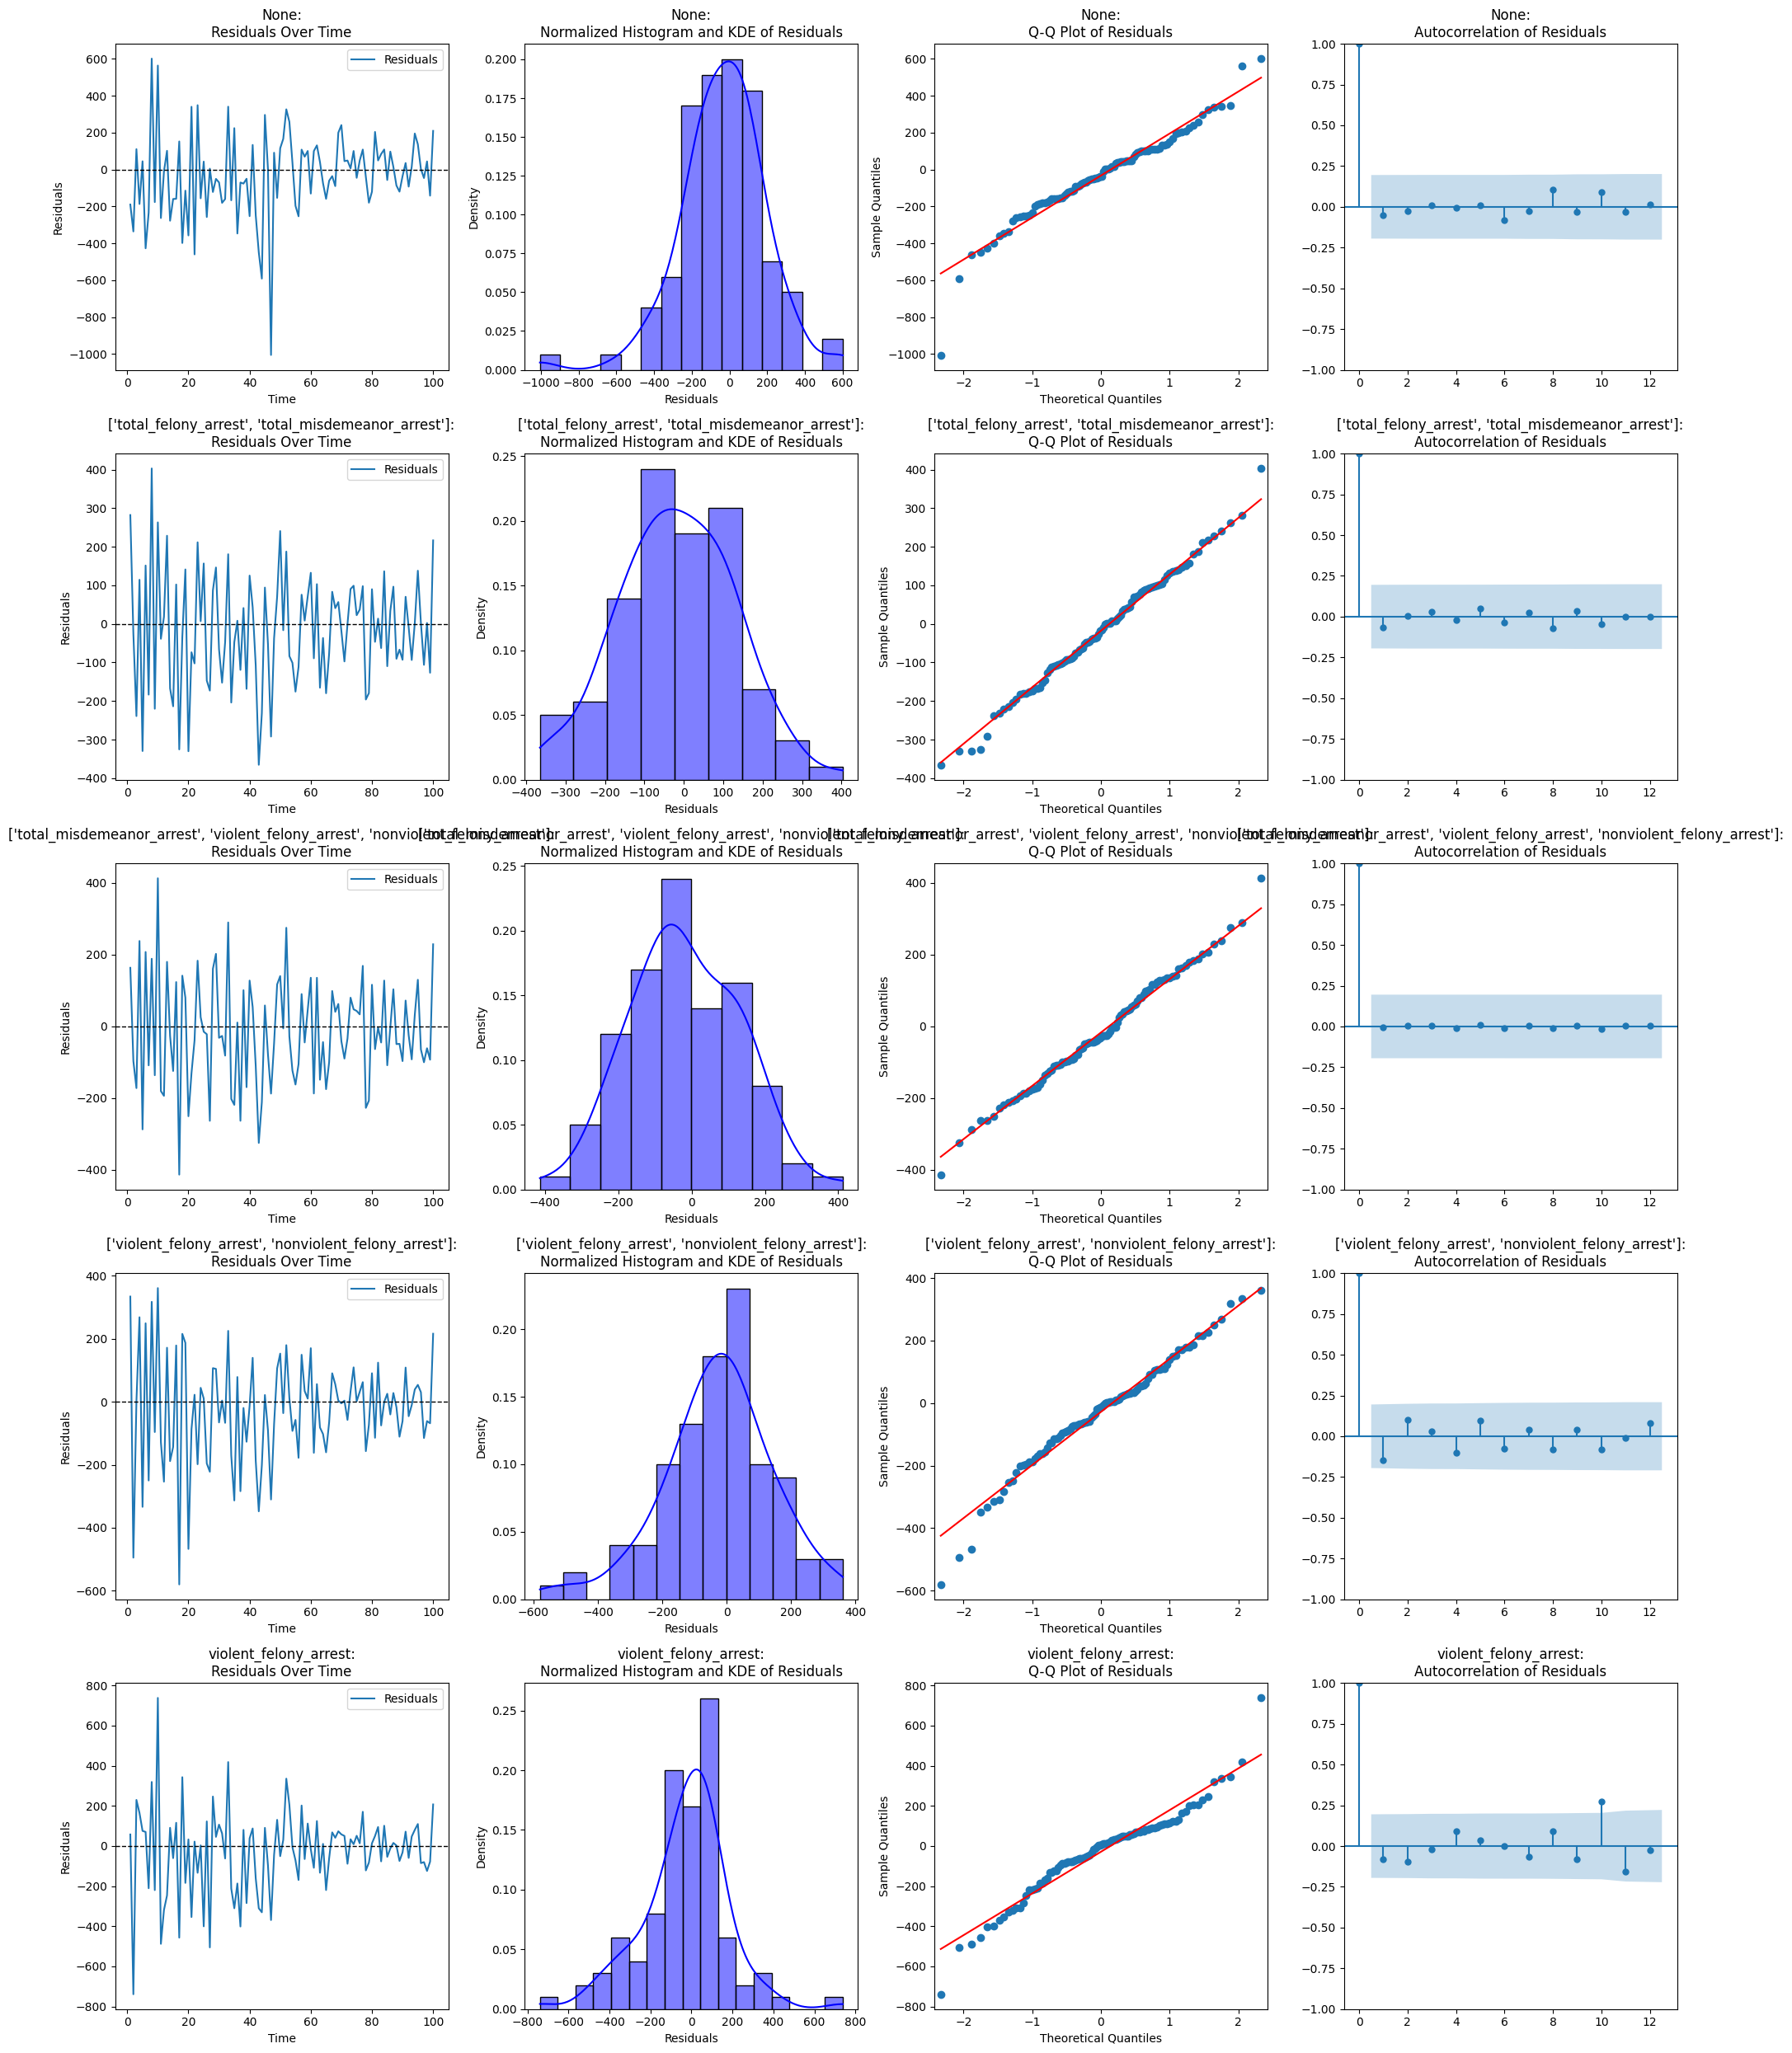

In [82]:
#plot the residual diagnostics
fig, axs = plt.subplots(len(adm_model_exog), 4, figsize=(20, 5 * len(adm_model_exog)))

y = log_transform(joined_df['admission_count'].dropna())
    
for i,model_vars in enumerate(adm_model_exog):
    exog = joined_df[model_vars].dropna() if model_vars is not None else None
    
    if model_vars is not None:
        # Ensure exog is a DataFrame even if only one variable is selected
        if isinstance(exog, pd.Series):
            exog = exog.to_frame()

        # See how many points we may need to add to the exog signal
        diff_n = len(y) - len(exog)
        missing_data = pd.DataFrame(columns=exog.columns)
        for var in exog.columns:
            missing_data[var] = arrest_cv_models[var]['predictions'][0:diff_n]
        exog = pd.concat([exog, missing_data], ignore_index=True)

        # Ensure the exog variable has the same index as the target variable
        exog = log_transform(exog.loc[y.index])   

    order = adm_cv_models[f'model_{i}']['model params'][0]
    seasonal_order = adm_cv_models[f'model_{i}']['model params'][1]

    model = SARIMAX(y, exog = exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
        
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    # Calculate residuals
    residuals = joined_df['admission_count'].dropna() - y_pred

    #plot residual diagnostics
    print(f'Computed the residuals for admission count model with exogenous variables: {model_vars}')
    # Residuals over time
    axs[i, 0].plot(residuals.index[1:], residuals[1:], label='Residuals')
    axs[i, 0].axhline(0, linestyle='--', color='black', linewidth=1)
    axs[i, 0].set_title(f'{model_vars}:\nResiduals Over Time')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('Residuals')
    axs[i, 0].legend()
    
    # Histogram and KDE plot of residuals
    sns.histplot(residuals[1:], kde=True,stat='probability', ax=axs[i, 1], color='blue')
    axs[i, 1].set_title(f'{model_vars}:\nNormalized Histogram and KDE of Residuals')
    axs[i, 1].set_xlabel('Residuals')
    axs[i, 1].set_ylabel('Density')
    
    # Q-Q plot of residuals
    sm.qqplot(residuals[1:], line='s', ax=axs[i, 2])
    axs[i, 2].set_title(f'{model_vars}:\nQ-Q Plot of Residuals')
    
    # ACF plot of residuals
    sm.graphics.tsa.plot_acf(residuals, lags=12, ax=axs[i, 3])
    axs[i, 3].set_title(f'{model_vars}:\nAutocorrelation of Residuals')
    print(f'Done plotting subplots for {model_vars}')
# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

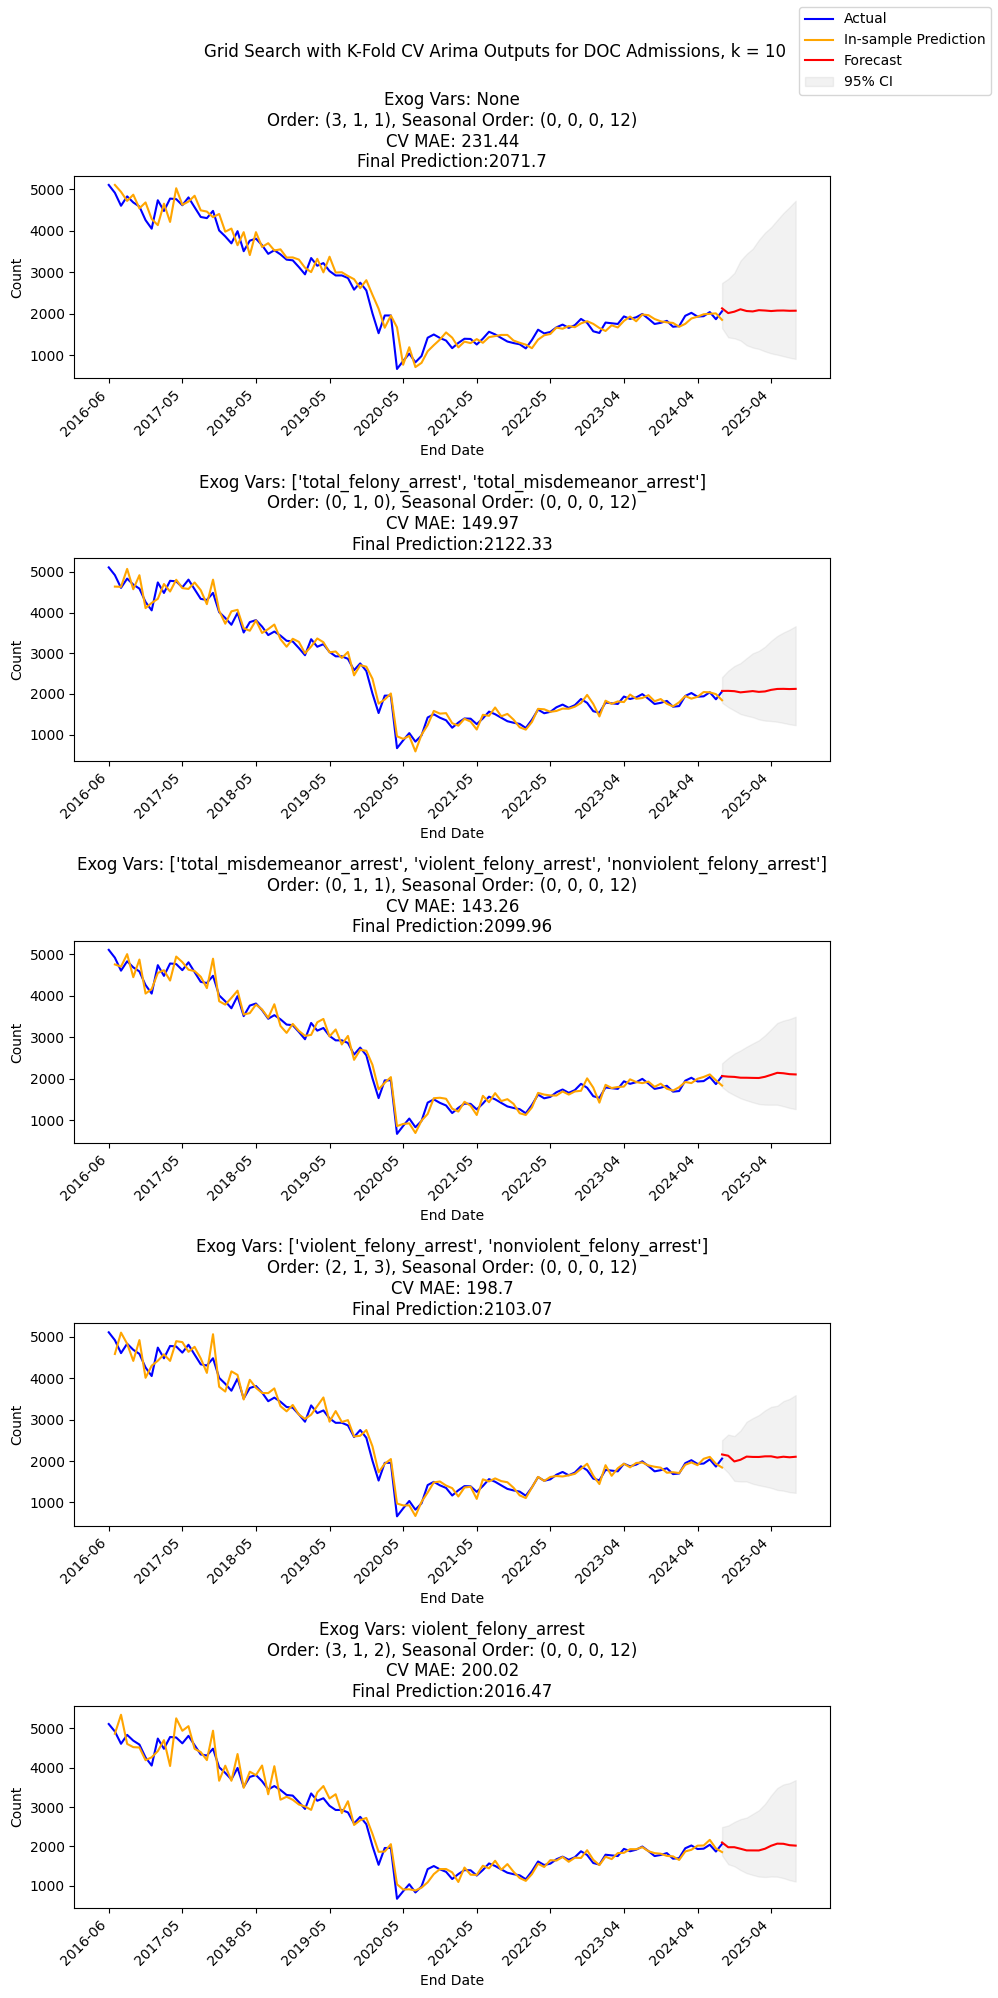

In [83]:
# Set up the subplots
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
axes = axes.flatten()

data = joined_df[['End Date','admission_count']].dropna()
y = log_transform(data['admission_count'])

for i,model_vars in enumerate(adm_model_exog):
    ax = axes[i]

    exog = joined_df[model_vars].dropna() if model_vars is not None else None
    
    if model_vars is not None:
        # Ensure exog is a DataFrame even if only one variable is selected
        if isinstance(exog, pd.Series):
            exog = exog.to_frame()
            
        # See how many points we may need to add to the exog signal
        diff_n = len(y) - len(exog)
        missing_data = pd.DataFrame(columns=exog.columns)
        future_exog = pd.DataFrame(columns = exog.columns, index = np.arange(len(exog),len(exog)+n_steps_adm))
    
        for var in exog.columns:
            missing_data[var] = arrest_cv_models[var]['predictions'][0:diff_n]
            future_exog[var] = arrest_cv_models[var]['predictions'][diff_n:]
        exog = pd.concat([exog, missing_data], ignore_index=True)
        # Ensure the exog variable has the same index as the target variable
        exog = log_transform(exog.loc[y.index])   
        future_exog = log_transform(future_exog)
    else: 
        future_exog = None

        
    order = adm_cv_models[f'model_{i}']['model params'][0]
    seasonal_order = adm_cv_models[f'model_{i}']['model params'][1]
    cv_mae = adm_cv_models[f'model_{i}']['mae']
    
    model = SARIMAX(y, exog = exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    #in sample
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    #predictions
    forecast_log = results.get_forecast(steps=n_steps_adm, exog=future_exog)
    forecast_mean_log = forecast_log.predicted_mean
    conf_int_log = forecast_log.conf_int()

    # Bias-adjusted mean forecast back-transformation
    forecast = inverse_log_transform(forecast_mean_log)
    adm_cv_models[f'model_{i}']['prediction'] = forecast.values
    # Back-transform confidence intervals
    lower_bound = inverse_log_transform(conf_int_log.iloc[:, 0])
    upper_bound = inverse_log_transform(conf_int_log.iloc[:, 1])

    IS_mae = mean_absolute_error(data['admission_count'].iloc[1:],y_pred.iloc[1:])

    # Plot the actual data
    ax.plot(data['End Date'], data['admission_count'], label='Actual', color='blue')

    # Plot the in-sample prediction
    ax.plot(data['End Date'].iloc[1:], y_pred[1:], label='In-sample Prediction', color='orange')

    # Plot the forecast
    future_dates = pd.date_range(start=data['End Date'].iloc[-1], periods=n_steps_adm, freq='30D')
    ax.plot(future_dates, forecast, label='Forecast', color='red')

    # Plot the confidence intervals
    ax.fill_between(future_dates, lower_bound, upper_bound, color='grey', alpha=0.1, label='95% CI')
    
    # Set title and labels, including model parameters
    title = f"Exog Vars: {model_vars}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}\nFinal Prediction:{round(forecast.values[-1],2)}"
    ax.set_title(title)
    ax.set_xlabel('End Date')
    ax.set_ylabel('Count')

    # Set x-ticks and rotate labels
    dates = pd.date_range(start=data['End Date'].iloc[0], periods=len(data)+n_steps_adm, freq='30D')

    ax.set_xticks(dates[::12])
    ax.set_xticklabels(dates[::12].strftime('%Y-%m'), rotation=45, ha='right')

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle(f"Grid Search with K-Fold CV Arima Outputs for DOC Admissions, k = {n_splits}")

# Adjust layout
plt.tight_layout(rect=[0, 0, .85, .98])  # Leave space on the right for the legend
# plt.savefig("../Outputs/grid_search_kfold_cv_arrest_predictions.png", bbox_inches = 'tight')
plt.show()

In [84]:
adm_cv_models

{'model_0': {'exog_vars': None,
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x132978c3450>,
  'model params': ((3, 1, 1), (0, 0, 0, 12)),
  'mae': 231.43825442705923,
  'prediction': array([2128.08934108, 2014.07233836, 2048.04473124, 2106.083963  ,
         2063.89633566, 2054.34899945, 2084.24045145, 2076.14214133,
         2063.59284214, 2074.43137403, 2076.46272296, 2069.42795455,
         2071.69984877])},
 'model_1': {'exog_vars': ['total_felony_arrest', 'total_misdemeanor_arrest'],
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x13297886990>,
  'model params': ((0, 1, 0), (0, 0, 0, 12)),
  'mae': 149.97231239073048,
  'prediction': array([2072.44386997, 2073.58897941, 2066.00034043, 2036.60854244,
         2052.24800355, 2068.31756054, 2048.44846236, 2059.50855212,
         2097.85036004, 2120.50050216, 2123.08101182, 2117.6628695 ,
         2122.33030722])},
 'model_2': {'exog_vars': ['total_misdemeanor_arrest',
   'violen

Based on the finds above, the model that minimizes the out of sample MAE for predicting 30 day jail admission counts is the model that includes violent and nonviolent felony arrests only. Followed closely by the model that uses no exogenous variables.

# Predicting Jail Population

We are going to repeat the methods in the above section but for 30-day average daily jail population (ADP). We will conduct a grid search rolling window cross validation technique to find the optimal SARIMA parameters based on minimal out of sample mean absolute error. We will also iterate through a combination of exogenous variables to see which, in combination with the SARIMA parameters, are the optimal model. My idea for the combinations of exogenous variables are as follows:

1. None

2. admission counts (with prediction values from no exog vars, NVF & VF arrest counts, and total misd and felony arrests)

3. arrest counts

In [85]:
y = joined_df[['End Date','ADP']].dropna()
y.set_index('End Date', inplace=True)
y = log_transform(y)

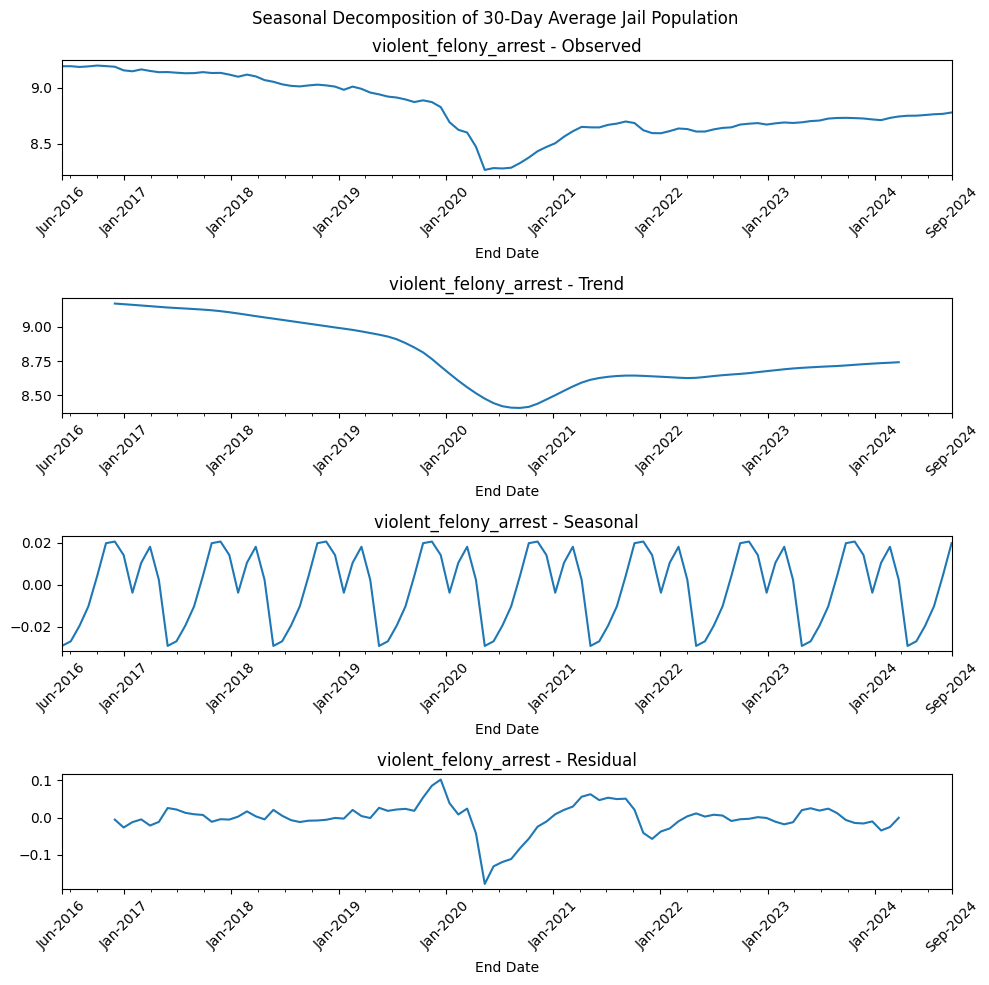

In [86]:
#first lets seasonal decompose
fig, axes = plt.subplots(4,1, figsize=(10, 10))

# Perform seasonal decomposition
result = seasonal_decompose(y, model='additive', period=12)  # Adjust 'period' according to your data
    
# Plot each component in a separate subplot
result.observed.plot(ax=axes[0], legend=False, title=f'{var} - Observed')
result.trend.plot(ax=axes[1], legend=False, title=f'{var} - Trend')
result.seasonal.plot(ax=axes[2], legend=False, title=f'{var} - Seasonal')
result.resid.plot(ax=axes[3], legend=False, title=f'{var} - Residual')

for j in range(4):
    axes[j].set_xlabel('End Date')
    axes[j].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b-%Y'))
    axes[j].tick_params(axis='x', rotation=45)

# Adjust layout
plt.suptitle('Seasonal Decomposition of 30-Day Average Jail Population')
plt.tight_layout()
plt.show()

In [87]:
#check d value of the signal
d = ndiffs(y, test='adf')
print(d)

2


In [88]:
#print adf test stats
from statsmodels.tsa.stattools import adfuller

result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

result = adfuller(y.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

result = adfuller(y.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.096337
p-value: 0.245990
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583
ADF Statistic: -3.218829
p-value: 0.018920
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583
ADF Statistic: -12.107504
p-value: 0.000000
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583


In [89]:
adp_cv_results = {}
y = log_transform(joined_df['ADP'].dropna())
#first lets grid search with no exog vars    
best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits)

adp_cv_results[f'model_0'] = {'exog_vars': None,'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with no Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   93
Model:               SARIMAX(1, 2, 2)   Log Likelihood                 185.171
Date:                Fri, 20 Sep 2024   AIC                           -362.343
Time:                        11:10:27   BIC                           -352.299
Sample:                             0   HQIC                          -358.291
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1444      0.238     -0.606      0.544      -0.611       0.322
ma.L1         -0.2085      0.194     -1.076      0.282      -0.588       0.171
ma.L2         -0.3916      0.095     -4.105      0.0

By default, the grid_search_sarimax function uses d=2. However I also want to use d = 1 with no exogenous variables to compare outputs.

In [90]:
#redefine the function to allow for d and D inputs
def grid_search_sarimax_v2(y, p_values, q_values, P_values, Q_values, s, n_splits, exog=None, d=None, D=None):
    best_score, best_params = float("inf"), None
    
    # If d or D are not provided, use ndiffs and nsdiffs to determine them
    d_value = d if d is not None else ndiffs(y.dropna(), test='adf')
    D_value = D if D is not None else nsdiffs(y.dropna(), m=s)
    
    pdq = list(itertools.product(p_values, [d_value], q_values))
    seasonal_pdq = list(itertools.product(P_values, [D_value], Q_values, [s]))
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                results, mae_score = time_series_cv(y, order=param, seasonal_order=param_seasonal, n_splits=n_splits, exog=exog)
                if mae_score < best_score:
                    best_score, best_params = mae_score, (param, param_seasonal)
                    best_result = results
            except Exception as e:
                continue
                
    print(best_result.summary())
    return best_result, best_params, best_score

In [91]:
#first lets grid search with no exog vars    
#change p values for ARIMA model to start at 1 for d=1 bc the signal with be under differenced
p_values_d1 = range(1, 4)

best_result, best_params, best_score = grid_search_sarimax_v2(y, p_values_d1, q_values, P_values, Q_values, s, n_splits, d = 1)

adp_cv_results[f'model_1'] = {'exog_vars': None,'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with no Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   93
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 191.579
Date:                Fri, 20 Sep 2024   AIC                           -373.159
Time:                        11:14:35   BIC                           -360.550
Sample:                             0   HQIC                          -368.070
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5044      0.476      1.059      0.290      -0.429       1.438
ar.L2          0.1973      0.236      0.838      0.402      -0.264       0.659
ma.L1          0.0553      0.511      0.108      0.9

Now let's do the other models both with d=2 and d=1

In [92]:
adp_cv_results

{'model_0': {'exog_vars': None,
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1329321c8d0>,
  'model params': ((1, 2, 2), (0, 0, 0, 12)),
  'mae': 362.98298059139734},
 'model_1': {'exog_vars': None,
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x132945bc8d0>,
  'model params': ((2, 1, 2), (0, 0, 0, 12)),
  'mae': 392.5687098354284}}

In [93]:
#first do admission exog with predictions from no other exog vars
exog_vars = 'admission_count'
exog = joined_df[exog_vars].dropna()
#fill missing values 
missing_data_1 = pd.Series(data = adm_cv_models[f'model_0']['prediction'][0:diff_n],
                            index=np.arange(len(exog),len(exog)+diff_n))
exog_1 = pd.concat([exog, missing_data_1], ignore_index=True)
# Ensure the exog variable has the same index as the target variable
exog_1 = log_transform(exog_1.loc[y.index]) 
best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits, exog = exog_1)

adp_cv_results[f'model_2'] = {'exog_vars': exog_vars,'exog_signal':exog_1,'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with admission count as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

best_result, best_params, best_score = grid_search_sarimax_v2(y, p_values_d1, q_values, P_values, Q_values, s, n_splits, exog = exog_1, d = 1)

adp_cv_results[f'model_3'] = {'exog_vars': exog_vars,'exog_signal':exog_1,'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with admission count as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   93
Model:               SARIMAX(0, 2, 2)   Log Likelihood                 186.010
Date:                Fri, 20 Sep 2024   AIC                           -364.020
Time:                        11:21:02   BIC                           -353.976
Sample:                             0   HQIC                          -359.968
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0270      0.009      2.932      0.003       0.009       0.045
ma.L1         -0.4038      0.087     -4.645      0.000      -0.574      -0.233
ma.L2         -0.3343      0.149     -2.245      0.0

In [94]:
#take the missing data from the admission model trained on violent and nonviolent arrest counts
missing_data_2 = pd.Series(data = adm_cv_models[f'model_3']['prediction'][0:diff_n],
                            index=np.arange(len(exog),len(exog)+diff_n))
exog_2 = pd.concat([exog, missing_data_2], ignore_index=True)
# Ensure the exog variable has the same index as the target variable
exog_2 = log_transform(exog_2.loc[y.index])

best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits, exog = exog_2)

adp_cv_results[f'model_4'] = {'exog_vars': exog_vars,'exog_signal':exog_2, 'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with admission count as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

best_result, best_params, best_score = grid_search_sarimax_v2(y, p_values_d1, q_values, P_values, Q_values, s, n_splits, exog = exog_2, d = 1)

adp_cv_results[f'model_5'] = {'exog_vars': exog_vars,'exog_signal':exog_2, 'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with admission count as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   93
Model:               SARIMAX(0, 2, 2)   Log Likelihood                 186.010
Date:                Fri, 20 Sep 2024   AIC                           -364.020
Time:                        11:32:50   BIC                           -353.976
Sample:                             0   HQIC                          -359.968
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0270      0.009      2.932      0.003       0.009       0.045
ma.L1         -0.4038      0.087     -4.645      0.000      -0.574      -0.233
ma.L2         -0.3343      0.149     -2.245      0.0

In [95]:
#take the missing data from the admission model trained on violent and nonviolent arrest counts
missing_data_3 = pd.Series(data = adm_cv_models['model_1']['prediction'][0:diff_n],
                            index=np.arange(len(exog),len(exog)+diff_n))
exog_3 = pd.concat([exog, missing_data_3], ignore_index=True)
# Ensure the exog variable has the same index as the target variable
exog_3 = log_transform(exog_3.loc[y.index])

best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits, exog = exog_3)

adp_cv_results[f'model_6'] = {'exog_vars': exog_vars,'exog_signal':exog_3, 'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with admission count as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

best_result, best_params, best_score = grid_search_sarimax_v2(y, p_values_d1, q_values, P_values, Q_values, s, n_splits, exog = exog_3, d = 1)

adp_cv_results[f'model_7'] = {'exog_vars': exog_vars,'exog_signal':exog_3, 'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with admission count as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")


                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   93
Model:               SARIMAX(0, 2, 2)   Log Likelihood                 186.010
Date:                Fri, 20 Sep 2024   AIC                           -364.020
Time:                        11:44:24   BIC                           -353.976
Sample:                             0   HQIC                          -359.968
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0270      0.009      2.932      0.003       0.009       0.045
ma.L1         -0.4038      0.087     -4.645      0.000      -0.574      -0.233
ma.L2         -0.3343      0.149     -2.245      0.0

In [96]:
exog_vars = ['violent_felony_arrest', 'nonviolent_felony_arrest','total_misdemeanor_arrest']
exog = joined_df[exog_vars].dropna()

# See how many points we may need to add to the exog signal
diff_n = len(y) - len(exog)
missing_data = pd.DataFrame(columns=exog.columns)

for var in exog_vars:
    missing_data[var] = arrest_cv_models[var]['predictions'][0:diff_n]
exog = pd.concat([exog, missing_data], ignore_index=True)
# Ensure the exog variable has the same index as the target variable
exog = log_transform(exog.loc[y.index]) 
    
best_result, best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits, exog = exog)

adp_cv_results[f'model_8'] = {'exog_vars': exog_vars,'exog_signal':exog, 'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with arrest counts as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

best_result, best_params, best_score = grid_search_sarimax_v2(y, p_values_d1, q_values, P_values, Q_values, s, n_splits, exog = exog, d = 1)

adp_cv_results[f'model_9'] = {'exog_vars': exog_vars,'exog_signal':exog, 'result': best_result, 'model params': best_params, 'mae': best_score}
print(f"Best model for ADP with arrest counts as an Exogenous Variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   93
Model:               SARIMAX(2, 2, 2)   Log Likelihood                 194.731
Date:                Fri, 20 Sep 2024   AIC                           -373.463
Time:                        11:57:59   BIC                           -353.376
Sample:                             0   HQIC                          -365.359
                                 - 93                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
violent_felony_arrest       -0.1188      0.033     -3.594      0.000      -0.184      -0.054
nonviolent_felony_arrest     0.0675      0.065      1.037      0.300      -0.060       0.

In [97]:
adp_cv_results

{'model_0': {'exog_vars': None,
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1329321c8d0>,
  'model params': ((1, 2, 2), (0, 0, 0, 12)),
  'mae': 362.98298059139734},
 'model_1': {'exog_vars': None,
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x132945bc8d0>,
  'model params': ((2, 1, 2), (0, 0, 0, 12)),
  'mae': 392.5687098354284},
 'model_2': {'exog_vars': 'admission_count',
  'exog_signal': 0      8.539150
  1      8.501267
  2      8.435549
  3      8.483636
  4      8.452761
           ...   
  97     7.570443
  98     7.620705
  99     7.532088
  100    7.630461
  101    7.663450
  Length: 102, dtype: float64,
  'result': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x132984ec610>,
  'model params': ((0, 2, 2), (0, 0, 0, 12)),
  'mae': 302.53422000532333},
 'model_3': {'exog_vars': 'admission_count',
  'exog_signal': 0      8.539150
  1      8.501267
  2      8.435549
  3      8.483636
  4      8.452761
   

Computed the residuals for model_0
Done plotting subplots for model_0
Computed the residuals for model_1
Done plotting subplots for model_1
Computed the residuals for model_2
Done plotting subplots for model_2
Computed the residuals for model_3
Done plotting subplots for model_3
Computed the residuals for model_4
Done plotting subplots for model_4
Computed the residuals for model_5
Done plotting subplots for model_5
Computed the residuals for model_6
Done plotting subplots for model_6
Computed the residuals for model_7
Done plotting subplots for model_7
Computed the residuals for model_8
Done plotting subplots for model_8
Computed the residuals for model_9
Done plotting subplots for model_9


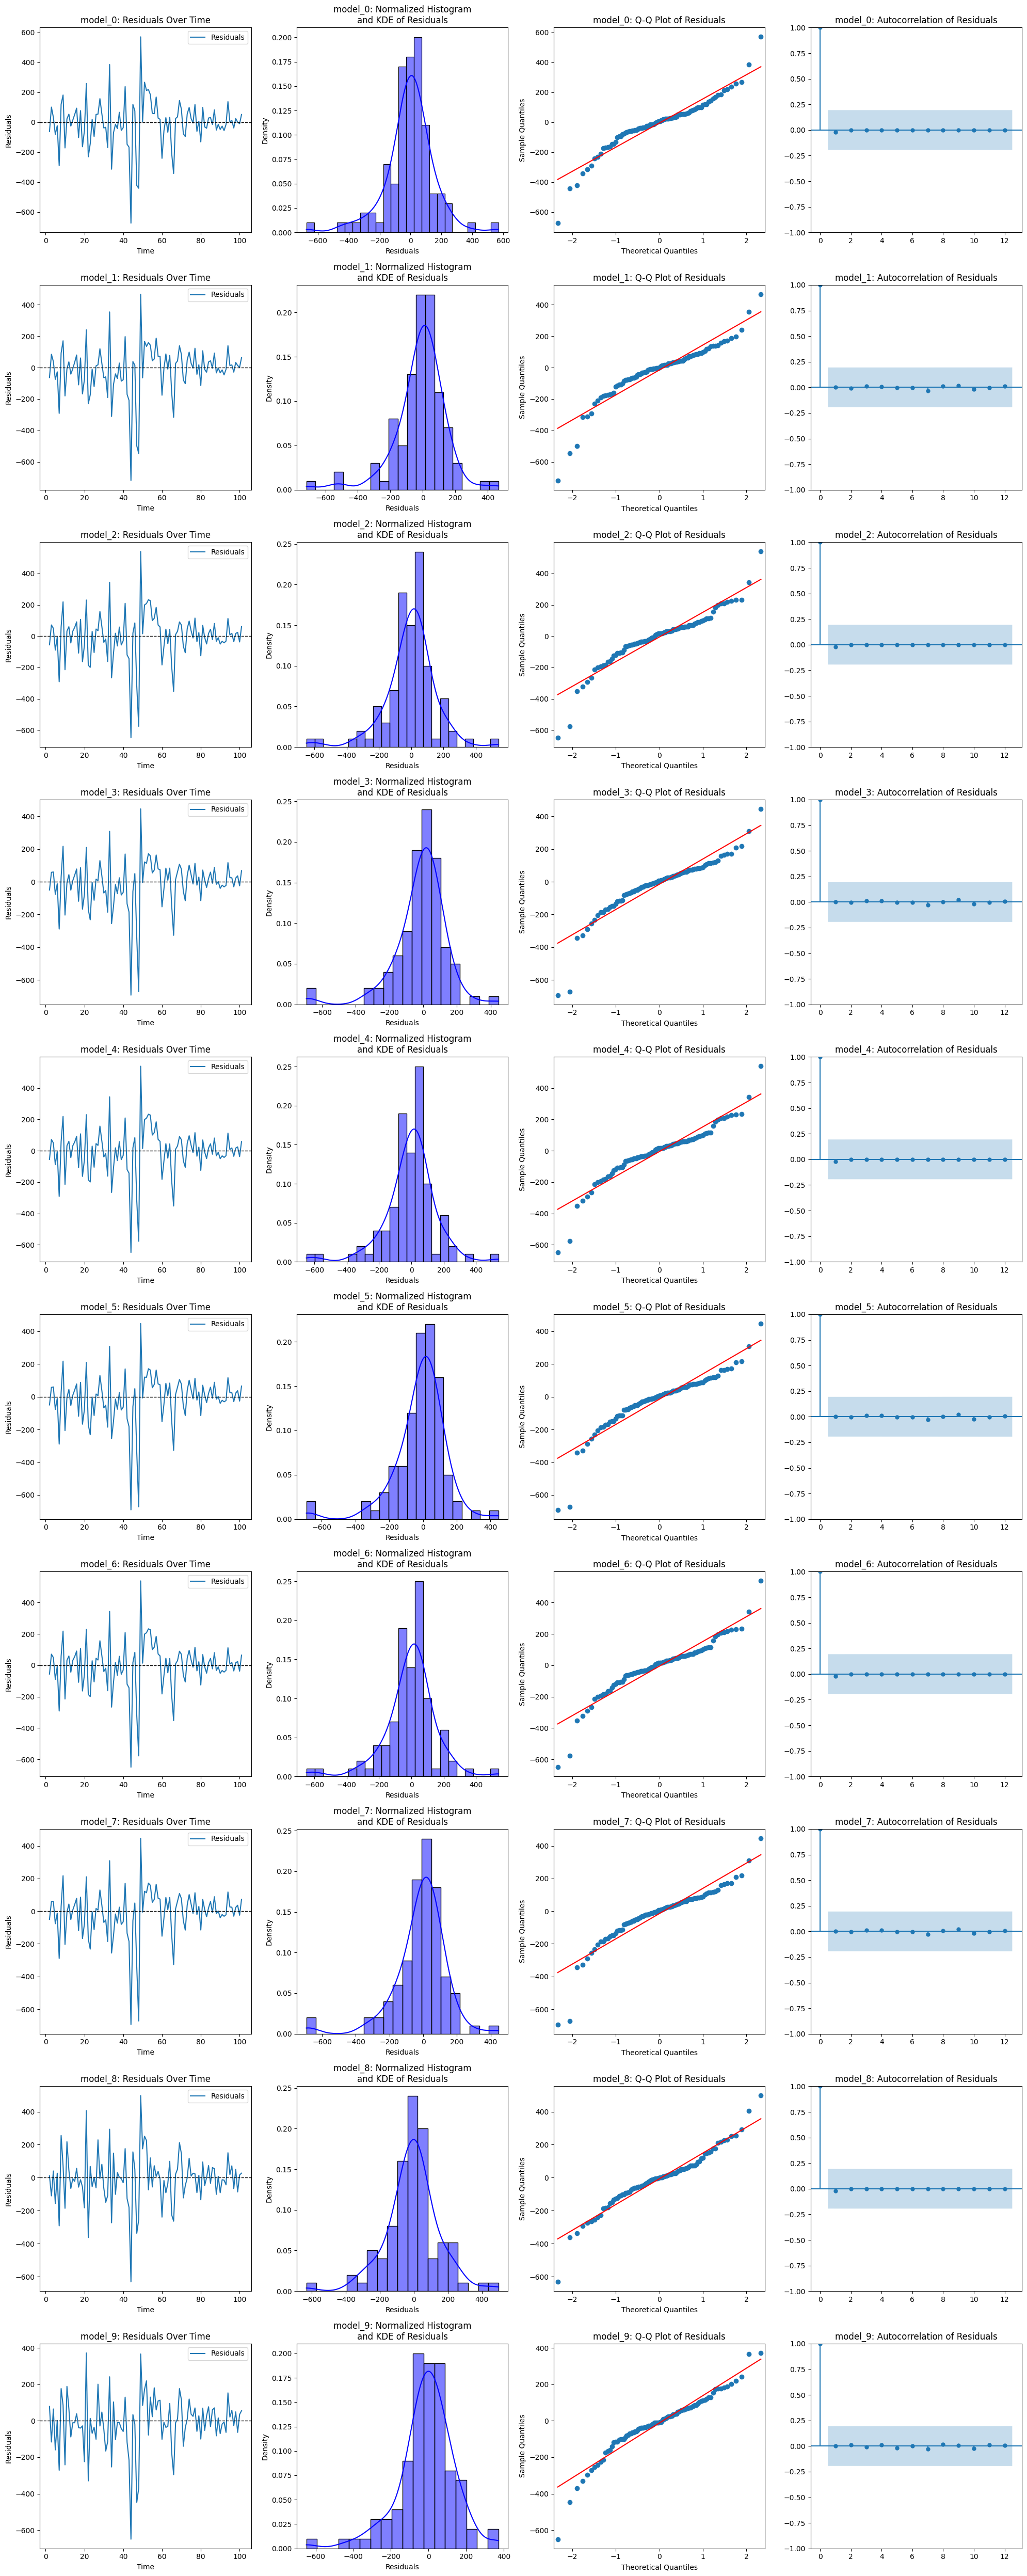

In [98]:
#plot residuals diagnostics
fig, axs = plt.subplots(len(list(adp_cv_results.keys())), 4, figsize=(20, 5 * len(list(adp_cv_results.keys()))))

data = joined_df['ADP'].dropna()
y = log_transform(data)

for i, (model_nm,model_params) in enumerate(adp_cv_results.items()):
    
    exog_vars = model_params['exog_vars']
    if exog_vars is None:
        exog = None
    else:
        exog = model_params['exog_signal']
    # elif exog_vars == 'admission_count' and (model_nm == 'model_1' or model_nm == 'model_2'):
    #     exog = exog_1
    # elif exog_vars == 'admission_count' and (model_nm == 'model_3' or model_nm == 'model_4'):
    #     exog = exog_2
    # else:
    #     exog = joined_df[exog_vars].dropna()
    #     # See how many points we may need to add to the exog signal
    #     diff_n = len(y) - len(exog)
    #     missing_data = pd.DataFrame(columns=exog.columns)
    #     for var in exog_vars:
    #         missing_data[var] = arrest_cv_models[var]['predictions'][0:diff_n]
    #     exog = pd.concat([exog, missing_data], ignore_index=True)
    #     # Ensure the exog variable has the same index as the target variable
    #     exog = log_transform(exog.loc[y.index]) 

    order = adp_cv_results[model_nm]['model params'][0]
    seasonal_order = adp_cv_results[model_nm]['model params'][1]

    model = SARIMAX(y, exog = exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
        
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    # Calculate residuals
    residuals = data - y_pred

    #plot residual diagnostics
    print(f'Computed the residuals for {model_nm}')
    # Residuals over time
    axs[i, 0].plot(residuals.index[2:], residuals[2:], label='Residuals')
    axs[i, 0].axhline(0, linestyle='--', color='black', linewidth=1)
    axs[i, 0].set_title(f'{model_nm}: Residuals Over Time')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('Residuals')
    axs[i, 0].legend()
    
    # Histogram and KDE plot of residuals
    sns.histplot(residuals[2:], kde=True,stat='probability', ax=axs[i, 1], color='blue')
    axs[i, 1].set_title(f'{model_nm}: Normalized Histogram\nand KDE of Residuals')
    axs[i, 1].set_xlabel('Residuals')
    axs[i, 1].set_ylabel('Density')
    
    # Q-Q plot of residuals
    sm.qqplot(residuals[2:], line='s', ax=axs[i, 2])
    axs[i, 2].set_title(f'{model_nm}: Q-Q Plot of Residuals')
    
    # ACF plot of residuals
    sm.graphics.tsa.plot_acf(residuals, lags=12, ax=axs[i, 3])
    axs[i, 3].set_title(f'{model_nm}: Autocorrelation of Residuals')
    print(f'Done plotting subplots for {model_nm}')
# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

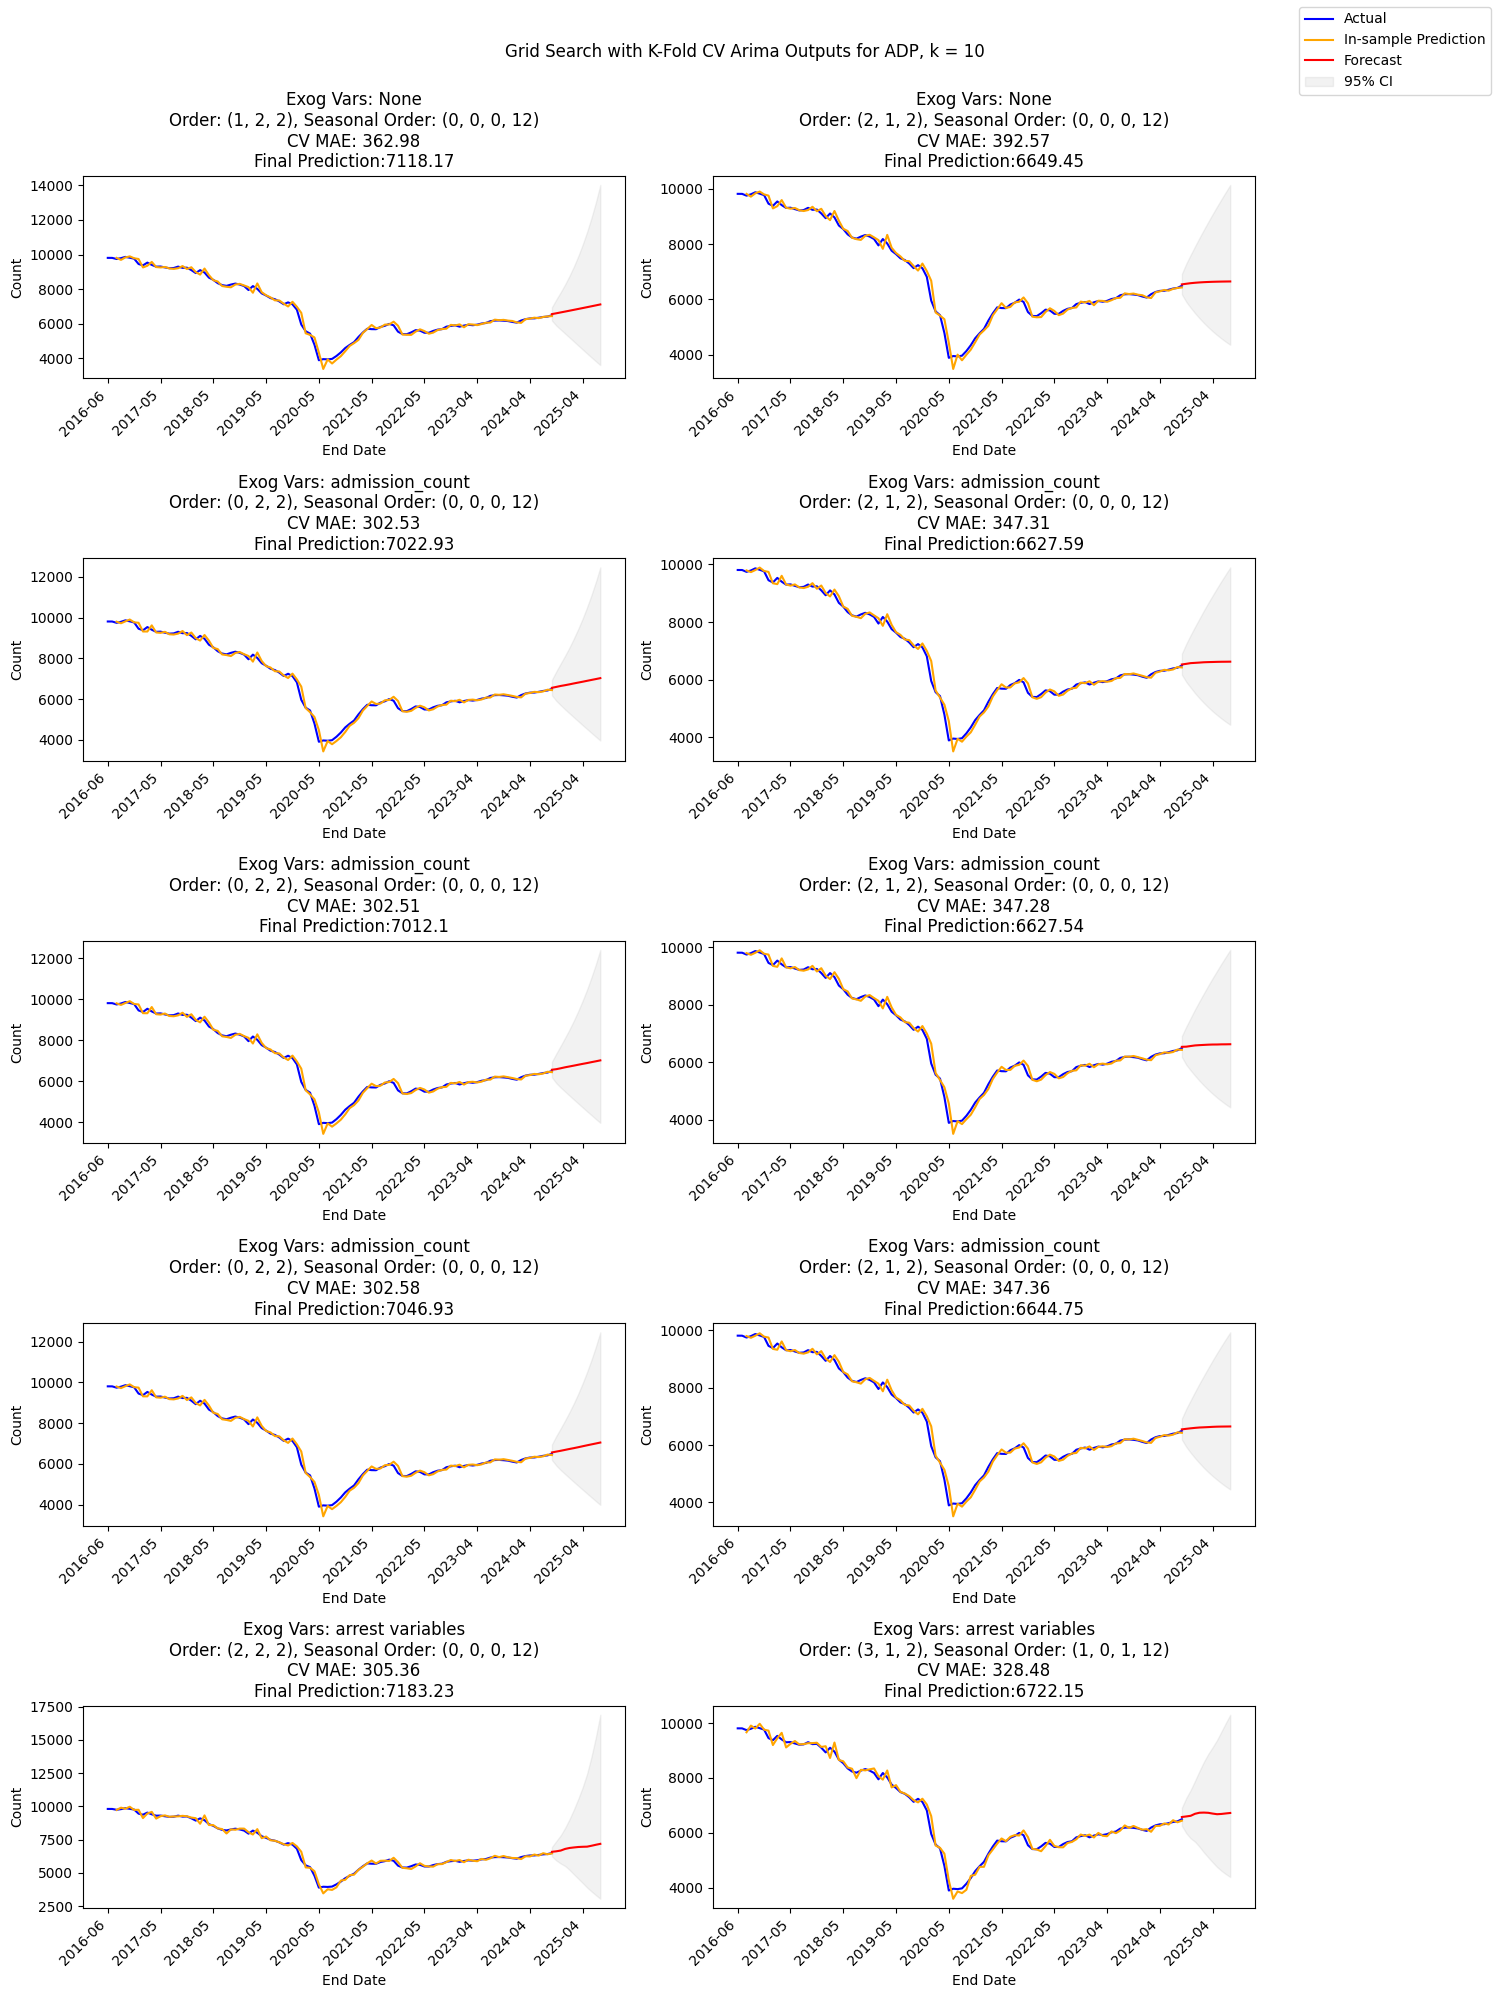

In [99]:
#plot the outputs
# Set up the subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

data = joined_df[['End Date','ADP']].dropna()
y = log_transform(data['ADP'])
diff_n_adm = len(y) - len(joined_df['admission_count'].dropna())
diff_n_arr = len(y) - len(joined_df['total_felony_arrest'].dropna())

for i, (model_nm,model_params) in enumerate(adp_cv_results.items()):
    ax = axes[i]

    exog_vars = model_params['exog_vars']

    if exog_vars is None:
        exog = None
        future_exog = None
    else:
        exog = model_params['exog_signal']

    if exog_vars == 'admission_count' and (model_nm == 'model_2' or model_nm == 'model_3'):
        future_exog = log_transform(adm_cv_models[f'model_0']['prediction'][diff_n_adm:])
    elif exog_vars == 'admission_count' and (model_nm == 'model_4' or model_nm == 'model_5'):
        future_exog = log_transform(adm_cv_models[f'model_3']['prediction'][diff_n_adm:])
    elif exog_vars == 'admission_count' and (model_nm == 'model_6' or model_nm == 'model_7'):
        future_exog = log_transform(adm_cv_models[f'model_1']['prediction'][diff_n_adm:])
    elif exog_vars != 'admission_count' and exog_vars is not None:
        future_exog = pd.DataFrame(columns = exog.columns, index = np.arange(len(exog),len(exog)+n_steps_adp))
        title_exog_str = 'arrest variables'
    
        for var in exog.columns:
            future_exog[var] = arrest_cv_models[var]['predictions'][diff_n_arr:]
        future_exog = log_transform(future_exog) 

    order = adp_cv_results[model_nm]['model params'][0]
    seasonal_order = adp_cv_results[model_nm]['model params'][1]
    cv_mae = adp_cv_results[model_nm]['mae']
    
    model = SARIMAX(y, exog = exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    #in sample
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    #predictions
    forecast_log = results.get_forecast(steps=n_steps_adp, exog=future_exog)
    forecast_mean_log = forecast_log.predicted_mean
    conf_int_log = forecast_log.conf_int()

    # Bias-adjusted mean forecast back-transformation
    forecast = inverse_log_transform(forecast_mean_log)
    adp_cv_results[model_nm]['prediction'] = forecast.values
    # Back-transform confidence intervals
    lower_bound = inverse_log_transform(conf_int_log.iloc[:, 0])
    upper_bound = inverse_log_transform(conf_int_log.iloc[:, 1])

    IS_mae = mean_absolute_error(data['ADP'].iloc[1:],y_pred.iloc[1:])

    # Plot the actual data
    ax.plot(data['End Date'], data['ADP'], label='Actual', color='blue')

    # Plot the in-sample prediction
    ax.plot(data['End Date'].iloc[2:], y_pred[2:], label='In-sample Prediction', color='orange')

    # Plot the forecast
    future_dates = pd.date_range(start=data['End Date'].iloc[-1], periods=n_steps_adp, freq='30D')
    ax.plot(future_dates, forecast, label='Forecast', color='red')

    # Plot the confidence intervals
    ax.fill_between(future_dates, lower_bound, upper_bound, color='grey', alpha=0.1, label='95% CI')
    
    # Set title and labels, including model parameters
    if exog_vars != 'admission_count' and exog_vars is not None:
        title = f"Exog Vars: {title_exog_str}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}\nFinal Prediction:{round(forecast.values[-1],2)}"
    else:
        title = f"Exog Vars: {exog_vars}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}\nFinal Prediction:{round(forecast.values[-1],2)}"
    ax.set_title(title)
    ax.set_xlabel('End Date')
    ax.set_ylabel('Count')

    # Set x-ticks and rotate labels
    dates = pd.date_range(start=data['End Date'].iloc[0], periods=len(data)+n_steps_adp, freq='30D')

    ax.set_xticks(dates[::12])
    ax.set_xticklabels(dates[::12].strftime('%Y-%m'), rotation=45, ha='right')

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle(f"Grid Search with K-Fold CV Arima Outputs for ADP, k = {n_splits}")

# Adjust layout
plt.tight_layout(rect=[0, 0, .85, .98])  # Leave space on the right for the legend
# plt.savefig("../Outputs/grid_search_kfold_cv_arrest_predictions.png", bbox_inches = 'tight')
plt.show()

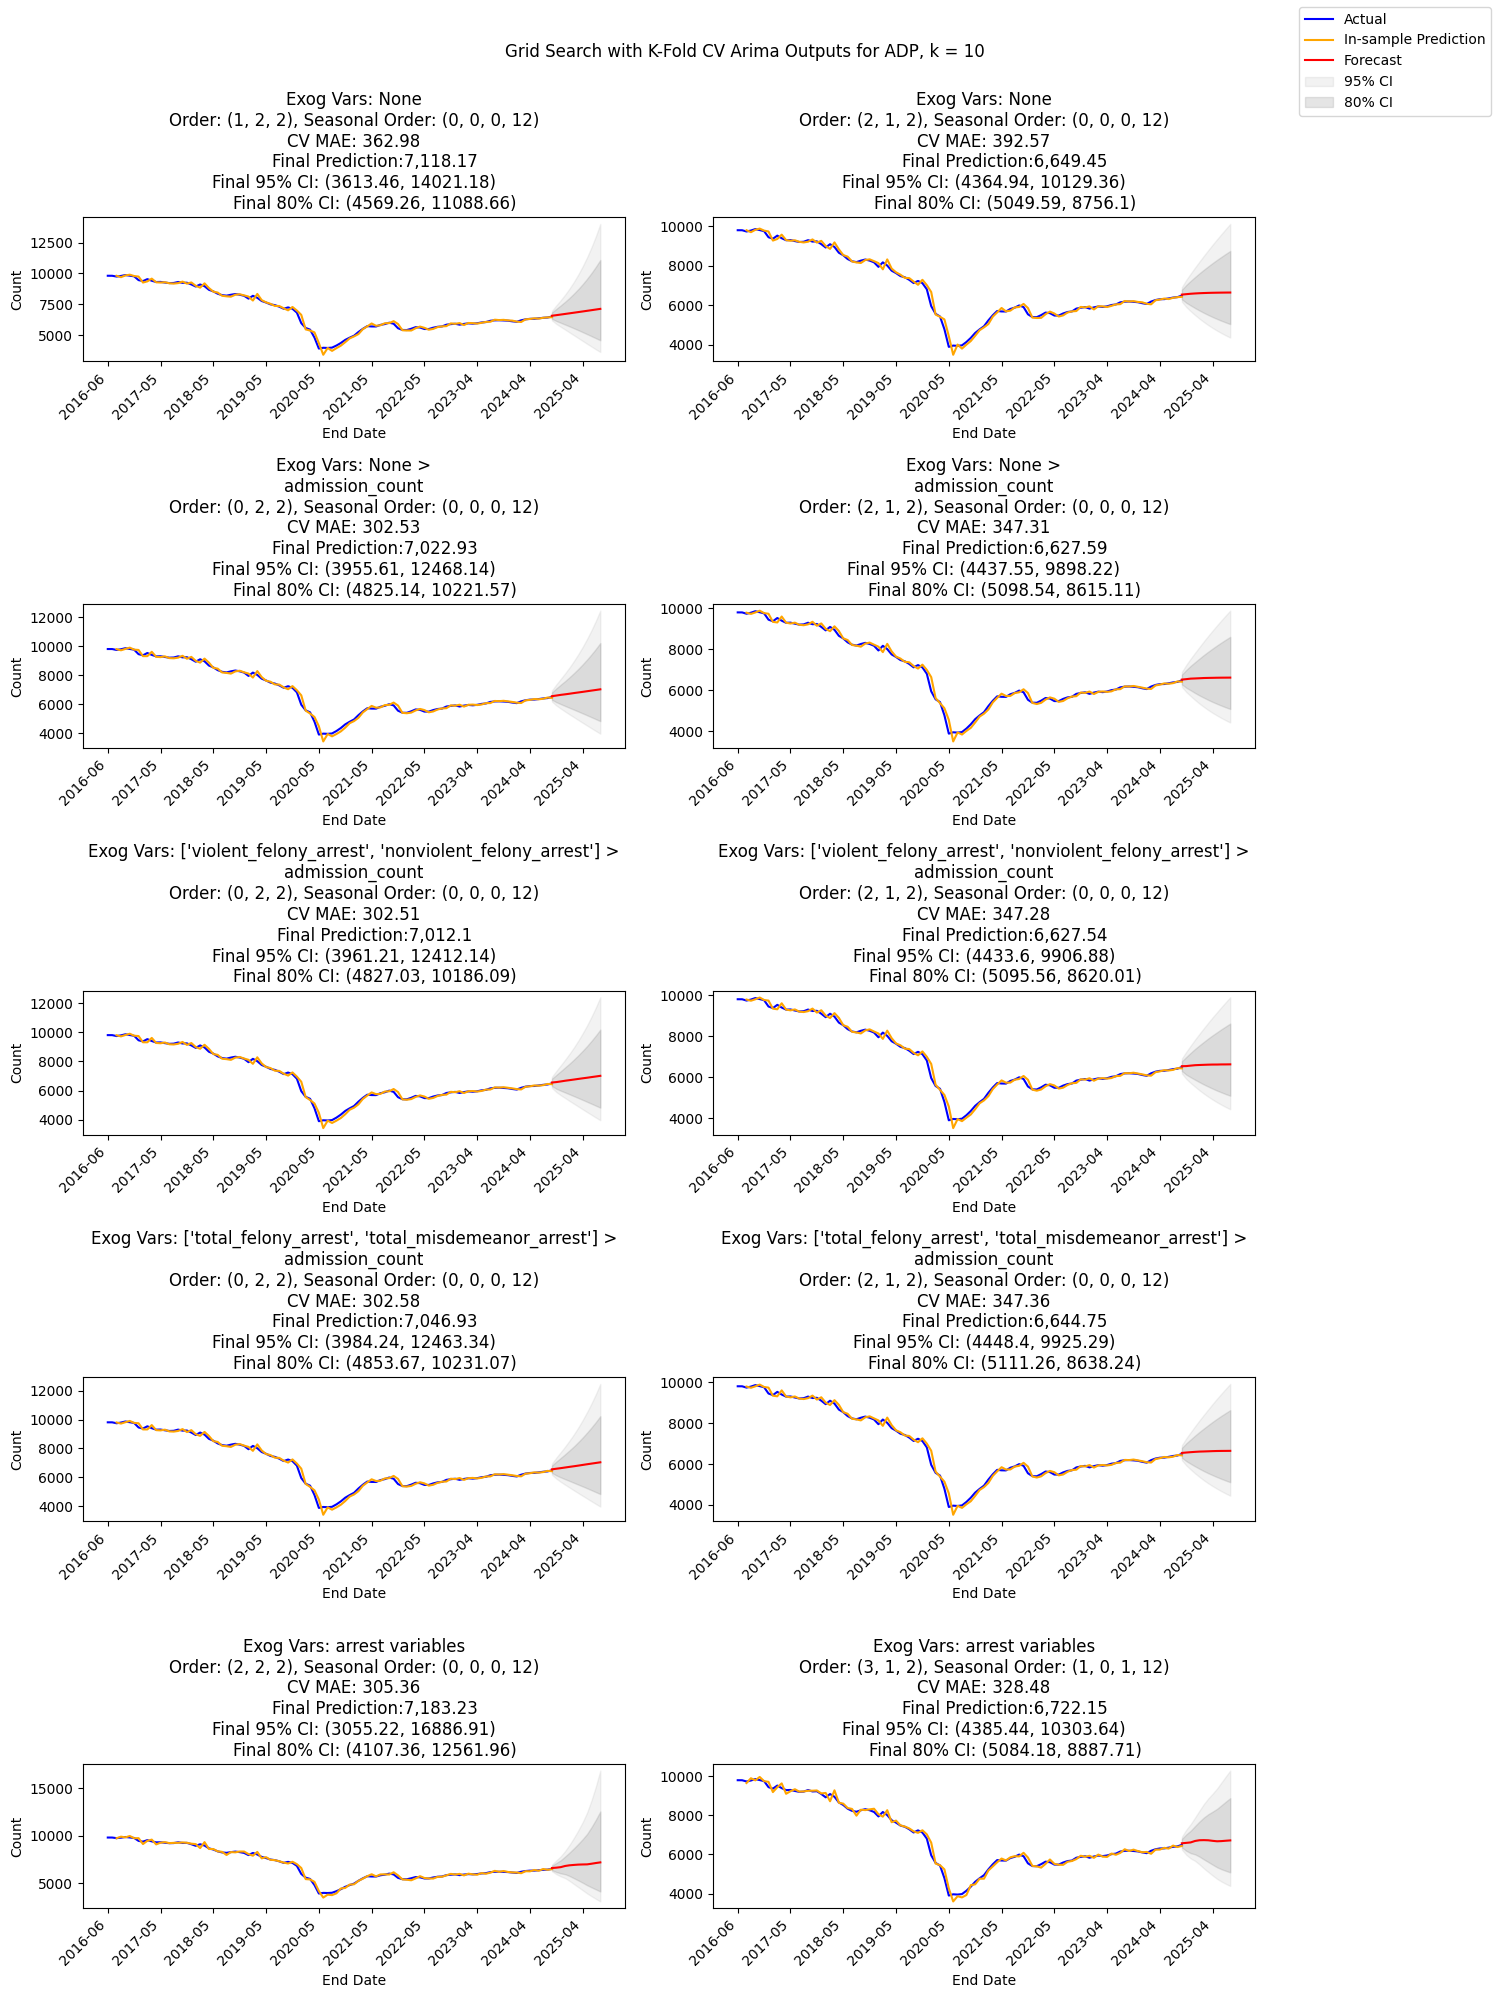

In [107]:
#plot with 80% CI
# Set up the subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

data = joined_df[['End Date','ADP']].dropna()
y = log_transform(data['ADP'])
diff_n_adm = len(y) - len(joined_df['admission_count'].dropna())
diff_n_arr = len(y) - len(joined_df['total_felony_arrest'].dropna())

for i, (model_nm,model_params) in enumerate(adp_cv_results.items()):
    ax = axes[i]

    exog_vars = model_params['exog_vars']

    if exog_vars is None:
        exog = None
        future_exog = None
    else:
        exog = model_params['exog_signal']

    if exog_vars == 'admission_count' and (model_nm == 'model_2' or model_nm == 'model_3'):
        future_exog = log_transform(adm_cv_models[f'model_0']['prediction'][diff_n_adm:])
        adm_exog_str = adm_cv_models[f'model_0']['exog_vars']
    elif exog_vars == 'admission_count' and (model_nm == 'model_4' or model_nm == 'model_5'):
        future_exog = log_transform(adm_cv_models[f'model_3']['prediction'][diff_n_adm:])
        adm_exog_str = adm_cv_models[f'model_3']['exog_vars']
    elif exog_vars == 'admission_count' and (model_nm == 'model_6' or model_nm == 'model_7'):
        future_exog = log_transform(adm_cv_models[f'model_1']['prediction'][diff_n_adm:])
        adm_exog_str = adm_cv_models[f'model_1']['exog_vars']
    elif exog_vars != 'admission_count' and exog_vars is not None:
        future_exog = pd.DataFrame(columns = exog.columns, index = np.arange(len(exog),len(exog)+n_steps_adp))
        title_exog_str = 'arrest variables'
        for var in exog.columns:
            future_exog[var] = arrest_cv_models[var]['predictions'][diff_n_arr:]
        future_exog = log_transform(future_exog) 

    order = adp_cv_results[model_nm]['model params'][0]
    seasonal_order = adp_cv_results[model_nm]['model params'][1]
    cv_mae = adp_cv_results[model_nm]['mae']
    
    model = SARIMAX(y, exog = exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    #in sample
    predictions = results.predict(start=y.index[0], end=y.index[-1])
    y_pred = inverse_log_transform(predictions)
    #predictions
    forecast_log = results.get_forecast(steps=n_steps_adp, exog=future_exog)
    forecast_mean_log = forecast_log.predicted_mean
    conf_int_95_log = forecast_log.conf_int(alpha=0.05)  # 95% CI
    conf_int_80_log = forecast_log.conf_int(alpha=0.20)  # 80% CI

    # Bias-adjusted mean forecast back-transformation
    forecast = inverse_log_transform(forecast_mean_log)
    adp_cv_results[model_nm]['prediction'] = forecast.values
    # Back-transform confidence intervals
    lower_bound_95 = inverse_log_transform(conf_int_95_log.iloc[:, 0])
    upper_bound_95 = inverse_log_transform(conf_int_95_log.iloc[:, 1])

    lower_bound_80 = inverse_log_transform(conf_int_80_log.iloc[:, 0])
    upper_bound_80 = inverse_log_transform(conf_int_80_log.iloc[:, 1])

    IS_mae = mean_absolute_error(data['ADP'].iloc[1:],y_pred.iloc[1:])

    # Plot the actual data
    ax.plot(data['End Date'], data['ADP'], label='Actual', color='blue')

    # Plot the in-sample prediction
    ax.plot(data['End Date'].iloc[2:], y_pred[2:], label='In-sample Prediction', color='orange')

    # Plot the forecast
    future_dates = pd.date_range(start=data['End Date'].iloc[-1], periods=n_steps_adp, freq='30D')
    ax.plot(future_dates, forecast, label='Forecast', color='red')

    # Plot the 95% confidence intervals
    ax.fill_between(future_dates, lower_bound_95, upper_bound_95, color='grey', alpha=0.1, label='95% CI')

    # Plot the 80% confidence intervals on top of the 95% CI
    ax.fill_between(future_dates, lower_bound_80, upper_bound_80, color='grey', alpha=0.2, label='80% CI')

    # Set title and labels, including model parameters
    if exog_vars == 'admission_count':
        title = f"""Exog Vars: {adm_exog_str} >\n{exog_vars}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}
        Final Prediction:{round(forecast.values[-1],2):,g}\nFinal 95% CI: {round(lower_bound_95.iloc[-1],2), round(upper_bound_95.iloc[-1],2)}
        Final 80% CI: {round(lower_bound_80.iloc[-1],2), round(upper_bound_80.iloc[-1],2)}"""
    elif exog_vars != 'admission_count' and exog_vars is not None:
        title = f"""Exog Vars: {title_exog_str}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}
        Final Prediction:{round(forecast.values[-1],2):,g}\nFinal 95% CI: {round(lower_bound_95.iloc[-1],2), round(upper_bound_95.iloc[-1],2)}
        Final 80% CI: {round(lower_bound_80.iloc[-1],2), round(upper_bound_80.iloc[-1],2)}"""
    else:
        title = f"""Exog Vars: {exog_vars}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}
        Final Prediction:{round(forecast.values[-1],2):,g}\nFinal 95% CI: {round(lower_bound_95.iloc[-1],2), round(upper_bound_95.iloc[-1],2)}
        Final 80% CI: {round(lower_bound_80.iloc[-1],2), round(upper_bound_80.iloc[-1],2)}"""
    ax.set_title(title)
    ax.set_xlabel('End Date')
    ax.set_ylabel('Count')

    # Set x-ticks and rotate labels
    dates = pd.date_range(start=data['End Date'].iloc[0], periods=len(data)+n_steps_adp, freq='30D')

    ax.set_xticks(dates[::12])
    ax.set_xticklabels(dates[::12].strftime('%Y-%m'), rotation=45, ha='right')

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle(f"Grid Search with K-Fold CV Arima Outputs for ADP, k = {n_splits}")

# Adjust layout
plt.tight_layout(rect=[0, 0, .85, .98])  # Leave space on the right for the legend
plt.show()

The final model that I am going to pick is the model with crime and arrest exogenous variables (row 5, column 2). Therefore the final SARIMAX parameters for the models needed are as follows:

total_misdemeanor_crimes: (0, 1, 3), (1, 0, 0, 12)

violent_felony_crimes: (1, 0, 0), (1, 0, 1, 12)

nonviolent_felony_crimes: (2, 1, 2), (1, 0, 0, 12)

total_misdemeanor_arrest: (2, 1, 2), (1, 0, 0, 12)

violent_felony_arrest: (3, 1, 0), (0, 0, 1, 12)

nonviolent_felony_arrest: (3, 1, 1), (1, 0, 1, 12)

ADP: (3,1,2)(1,0,1,12)


## Test Function to predict

In [10]:
#import packages for getting and saving data
import json
import boto3
from io import StringIO
import urllib.request
#import packages for anaylses
import pandas as pd
import numpy as np
from statsmodels.tsa.api import SARIMAX #for arima model of admission ts
from datetime import timedelta

# Ensure non-negative values by applying a log transformation
def log_transform(series):
    return np.log1p(series)

def inverse_log_transform(series):
    return np.expm1(series)

def get_crime_data(first_st_date_adp, sample_freq):
    """
    first_st_date_adp: datetime.date
        The date of the first start date 30-day period in the interval data
    sample_freq: int
        The frequency in which we want to resample the ts data. This should be an integer that represents the number of days to resample the
        daily timeseries data we query from the open portal.
    """
    historic_crime_url = 'https://data.cityofnewyork.us/resource/qgea-i56i.json'
    current_yr_crime_url = 'https://data.cityofnewyork.us/resource/5uac-w243.json'
    date_col = 'CMPLNT_FR_DT'

    # Define the SQL query separately
    sql_query_1 = ("SELECT "
                f"date_trunc_ymd({date_col}) as crime_date, "
                "COUNT(CASE WHEN LAW_CAT_CD = 'FELONY' THEN CMPLNT_NUM END) as total_felony_crimes, "
                """COUNT(CASE WHEN LAW_CAT_CD = 'FELONY' AND (OFNS_DESC LIKE '%MURDER & NON-NEGL. MANSLAUGHTER%' or OFNS_DESC = 'HOMICIDE-NEGLIGENT,UNCLASSIFIE'
                or OFNS_DESC LIKE '%ROBBERY%' or OFNS_DESC LIKE '%RAPE%' or OFNS_DESC = 'FELONY ASSAULT') THEN CMPLNT_NUM END) as violent_felony_crimes, """
                "COUNT(CASE WHEN LAW_CAT_CD = 'MISDEMEANOR' THEN CMPLNT_NUM END) as total_misdemeanor_crimes "
                f"WHERE {date_col} >= '{first_st_date_adp}' "
                f"GROUP BY crime_date "
                "ORDER BY crime_date "
                "LIMIT 10000")

    # Encode SQL query for URL
    encoded_query = urllib.parse.quote(sql_query_1)

    # Construct the full URL query
    final_query = f'{historic_crime_url}?$query={encoded_query}'

    # Send the request and load the response data
    response = urllib.request.urlopen(final_query)
    data = json.loads(response.read())
    df_historic = pd.json_normalize(data)

    #ytd data and then append
    latest_historic_date = pd.to_datetime(df_historic['crime_date']).max().date()

    sql_query_2 = ("SELECT "
                f"date_trunc_ymd({date_col}) as crime_date, "
                "COUNT(CASE WHEN LAW_CAT_CD = 'FELONY' THEN CMPLNT_NUM END) as total_felony_crimes, "
                """COUNT(CASE WHEN LAW_CAT_CD = 'FELONY' AND (OFNS_DESC LIKE '%MURDER & NON-NEGL. MANSLAUGHTER%' or OFNS_DESC = 'HOMICIDE-NEGLIGENT,UNCLASSIFIE'
                or OFNS_DESC LIKE '%ROBBERY%' or OFNS_DESC LIKE '%RAPE%' or OFNS_DESC = 'FELONY ASSAULT') THEN CMPLNT_NUM END) as violent_felony_crimes, """
                "COUNT(CASE WHEN LAW_CAT_CD = 'MISDEMEANOR' THEN CMPLNT_NUM END) as total_misdemeanor_crimes "
                f"WHERE {date_col} > '{latest_historic_date}' "
                f"GROUP BY crime_date "
                "ORDER BY crime_date "
                "LIMIT 10000")
    # Encode SQL query for URL
    encoded_query = urllib.parse.quote(sql_query_2)

    # Construct the full URL query
    final_query = f'{current_yr_crime_url}?$query={encoded_query}'

    # Send the request and load the response data
    response = urllib.request.urlopen(final_query)
    data = json.loads(response.read())
    df_current = pd.json_normalize(data)
    #append
    df = pd.concat([df_historic,df_current],ignore_index = True)
    #convert data types
    df['crime_date'] = pd.to_datetime(df['crime_date'])
    df[df.columns[1:]] = df[df.columns[1:]].astype(int)
    #aggregate to 30 day averages
    #define max and min dates for future calculations
    max_date = df['crime_date'].max()
    min_date = df['crime_date'].min()
    #aggregate to 30 day intervals
    # Resample the DataFrame to 30-day intervals
    interval_crime_counts = df.resample(f'{sample_freq}D', on='crime_date', origin= min_date, closed='left', label='left').sum().round().fillna(0).reset_index()
    interval_crime_counts = interval_crime_counts.rename(columns = {'crime_date':'Start Date'})
    interval_crime_counts['End Date'] = interval_crime_counts['Start Date'] + pd.to_timedelta(sample_freq-1, unit='D')

    #calculate the days between start period and last date in admission df
    interval_crime_counts['Days to Max Date'] = (max_date - interval_crime_counts['Start Date']).dt.days
    # Display just the date portion of the start/end date columns and localize to specific timezone
    interval_crime_counts['Start Date'] = interval_crime_counts['Start Date'].dt.tz_localize('America/New_York').dt.date
    interval_crime_counts['End Date'] = interval_crime_counts['End Date'].dt.tz_localize('America/New_York').dt.date
    
    # drop rows where Days to Max Date are less than the frequency intervals
    interval_crime_counts = interval_crime_counts[interval_crime_counts['Days to Max Date']>=sample_freq]

    return interval_crime_counts

def get__30_day_arrest_df(first_st_date_adp, sample_freq):
    """
    first_st_date_adp: datetime.date
        The date of the first start date 30-day period in the interval data
    sample_freq: int
        The frequency in which we want to resample the ts data. This should be an integer that represents the number of days to resample the
        daily timeseries data we query from the open portal.
    """
    historic_arrest_url = 'https://data.cityofnewyork.us/resource/8h9b-rp9u.json'
    current_yr_arrest_url = 'https://data.cityofnewyork.us/resource/uip8-fykc.json'
    date_col = 'ARREST_DATE'

    # Define the SQL query separately
    sql_query_1 = ("SELECT "
                f"date_trunc_ymd({date_col}) as {date_col}, "
                "COUNT(CASE WHEN LAW_CAT_CD = 'F' THEN ARREST_KEY END) as total_felony_arrest, "
                """COUNT(CASE WHEN LAW_CAT_CD = 'F' AND (OFNS_DESC LIKE '%MURDER & NON-NEGL. MANSLAUGHTER%' or OFNS_DESC = 'HOMICIDE-NEGLIGENT,UNCLASSIFIE'
                or OFNS_DESC LIKE '%ROBBERY%' or OFNS_DESC LIKE '%RAPE%' or OFNS_DESC = 'FELONY ASSAULT') THEN ARREST_KEY END) as violent_felony_arrest, """
                "COUNT(CASE WHEN LAW_CAT_CD = 'M' THEN ARREST_KEY END) as total_misdemeanor_arrest "
                f"WHERE {date_col} >= '{first_st_date_adp}' "
                f"GROUP BY {date_col} "
                f"ORDER BY {date_col} "
                "LIMIT 10000")

    # Encode SQL query for URL
    encoded_query = urllib.parse.quote(sql_query_1)

    # Construct the full URL query
    final_query = f'{historic_arrest_url}?$query={encoded_query}'

    # Send the request and load the response data
    response = urllib.request.urlopen(final_query)
    data = json.loads(response.read())
    df_historic = pd.json_normalize(data)

    #ytd data and then append
    latest_historic_date = pd.to_datetime(df_historic[date_col]).max().date()

    sql_query_2 = ("SELECT "
                f"date_trunc_ymd({date_col}) as {date_col}, "
                "COUNT(CASE WHEN LAW_CAT_CD = 'F' THEN ARREST_KEY END) as total_felony_arrest, "
                """COUNT(CASE WHEN LAW_CAT_CD = 'F' AND (OFNS_DESC LIKE '%MURDER & NON-NEGL. MANSLAUGHTER%' or OFNS_DESC = 'HOMICIDE-NEGLIGENT,UNCLASSIFIE'
                or OFNS_DESC LIKE '%ROBBERY%' or OFNS_DESC LIKE '%RAPE%' or OFNS_DESC = 'FELONY ASSAULT') THEN ARREST_KEY END) as violent_felony_arrest, """
                "COUNT(CASE WHEN LAW_CAT_CD = 'M' THEN ARREST_KEY END) as total_misdemeanor_arrest "
                f"WHERE {date_col} > '{latest_historic_date}' "
                f"GROUP BY {date_col} "
                f"ORDER BY {date_col} "
                "LIMIT 10000")
    # Encode SQL query for URL
    encoded_query = urllib.parse.quote(sql_query_2)

    # Construct the full URL query
    final_query = f'{current_yr_arrest_url}?$query={encoded_query}'

    # Send the request and load the response data
    response = urllib.request.urlopen(final_query)
    data = json.loads(response.read())
    df_current = pd.json_normalize(data)
    #append
    df = pd.concat([df_historic,df_current],ignore_index = True)
    #convert data types
    df[date_col] = pd.to_datetime(df[date_col])
    df[df.columns[1:]] = df[df.columns[1:]].astype(int)
    #aggregate to 30 day averages
    #define max and min dates for future calculations
    max_date = df[date_col].max()
    min_date = df[date_col].min()
    #aggregate to 30 day intervals
    # Resample the DataFrame to 30-day intervals
    interval_arrest_counts = df.resample(f'{sample_freq}D', on=date_col, origin= min_date, closed='left', label='left').sum().round().fillna(0).reset_index()
    interval_arrest_counts = interval_arrest_counts.rename(columns = {date_col:'Start Date'})
    interval_arrest_counts['End Date'] = interval_arrest_counts['Start Date'] + pd.to_timedelta(sample_freq-1, unit='D')

    #calculate the days between start period and last date in admission df
    interval_arrest_counts['Days to Max Date'] = (max_date - interval_arrest_counts['Start Date']).dt.days
    # Display just the date portion of the start/end date columns and localize to specific timezone
    interval_arrest_counts['Start Date'] = interval_arrest_counts['Start Date'].dt.tz_localize('America/New_York').dt.date
    interval_arrest_counts['End Date'] = interval_arrest_counts['End Date'].dt.tz_localize('America/New_York').dt.date

    # drop rows where Days to Max Date are less than the frequency intervals
    interval_arrest_counts = interval_arrest_counts[interval_arrest_counts['Days to Max Date']>=sample_freq]

    return interval_arrest_counts

def model_crime_arrest(first_st_date_adp,length_target_signal, model_dict):
    #re-define the model_dict to be arima_dict to store all the values needed to model ADP in the later function
    arima_dict = model_dict
    #prepare final dataframes
    final_crime_results = pd.DataFrame(columns = ['Start Date', 'End Date', 'Type', 'Variable','Total Population', 'Absolute Error','Standard Error',
                                     '95% CI Lower Bound', '95% CI Upper Bound', '80% CI Lower Bound', '80% CI Upper Bound'])
    final_arrest_results = pd.DataFrame(columns = ['Start Date', 'End Date', 'Type', 'Variable', 'Total Population', 'Absolute Error','Standard Error',
                                     '95% CI Lower Bound', '95% CI Upper Bound', '80% CI Lower Bound', '80% CI Upper Bound'])
    
    #step 1: retrieve crime and arrest data
    _30_day_crime_df = get_crime_data(first_st_date_adp,30)
    print('Successfully retrieved crime counts')
    _30_day_arrest_df = get__30_day_arrest_df(first_st_date_adp,30)
    print('Successfully retrieved arrest counts')

    #specify data types
    _30_day_crime_df['Start Date'] = _30_day_crime_df['Start Date'].astype('datetime64[ns, America/New_York]')
    _30_day_crime_df['End Date'] = _30_day_crime_df['End Date'].astype('datetime64[ns, America/New_York]')
    _30_day_arrest_df['Start Date'] = _30_day_arrest_df['Start Date'].astype('datetime64[ns, America/New_York]')
    _30_day_arrest_df['End Date'] = _30_day_arrest_df['End Date'].astype('datetime64[ns, America/New_York]')

    #compute nonviolent crime and arrest numbers
    _30_day_crime_df['nonviolent_felony_crimes'] = _30_day_crime_df['total_felony_crimes'] - _30_day_crime_df['violent_felony_crimes']
    _30_day_arrest_df['nonviolent_felony_arrest'] = _30_day_arrest_df['total_felony_arrest'] - _30_day_arrest_df['violent_felony_arrest']

    #determine prediction size for each consecutive iteration based on 12 mo future predicts plus any missing data
    missing_n_crime = 0 if length_target_signal < len(_30_day_crime_df) else length_target_signal - len(_30_day_crime_df)
    missing_n_arrest = 0 if length_target_signal < len(_30_day_arrest_df) else length_target_signal - len(_30_day_arrest_df)

    #step 2: fitting and predicting exogenous variables
    #step 2a: crimes
    crime_models = arima_dict['crime_vars']
    #first lets add the actual values for the crime variables into the pandas df so we can plot it in a graph later
    for var,model_params in crime_models.items():
        #initialize df to store actual signal in
        actual_crime = pd.DataFrame(columns = ['Start Date', 'End Date', 'Type', 'Variable','Total Population', 'Absolute Error','Standard Error',
                                     '95% CI Lower Bound', '95% CI Upper Bound', '80% CI Lower Bound', '80% CI Upper Bound'])
        #set result start and end data columns
        actual_crime['Start Date'] = _30_day_crime_df['Start Date']
        actual_crime['End Date'] = _30_day_crime_df['End Date']
        #set all other outputs
        actual_crime['Total Population'] = _30_day_crime_df[var].dropna()
        actual_crime['Type'] = 'Actual'
        actual_crime['Variable'] = var
        #concatenate to the final result df
        final_crime_results = pd.concat([final_crime_results,actual_crime], ignore_index=True)
        
        #initialize df to store in sample metrics in
        crime_results = pd.DataFrame(columns = ['Start Date', 'End Date', 'Type', 'Variable','Total Population', 'Absolute Error','Standard Error',
                                     '95% CI Lower Bound', '95% CI Upper Bound', '80% CI Lower Bound', '80% CI Upper Bound'])
        #grab params
        order = model_params['order']
        seasonal_order = model_params['seasonal_order']
        #define the signal
        y = _30_day_crime_df[var].dropna()
        #log transform to ensure all predictions are positive
        y_log = log_transform(y)
        #fit the model to the data
        model = SARIMAX(y_log, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        #print the summary for troubleshooting purposes
        print(model_fit.summary())
        #determine predictions lengths and save the output in dictionary
        n_steps = 12 + missing_n_crime
        # Generate in-sample predictions
        y_pred_log = model_fit.fittedvalues
        y_pred = inverse_log_transform(y_pred_log)
        #set result start and end data columns
        crime_results['Start Date'] = _30_day_crime_df['Start Date']
        crime_results['End Date'] = _30_day_crime_df['End Date']
        #set all other outputs
        crime_results['Total Population'] = y_pred
        crime_results['Type'] = 'Model'
        crime_results['Absolute Error'] = np.abs(y - y_pred)
        crime_results['Variable'] = var
        # Generate out-of-sample forecast_exog
        pred_log = model_fit.get_forecast(steps=n_steps)
        fc_series_log = pd.Series(pred_log.summary_frame()['mean'].values)
        fc_series = inverse_log_transform(fc_series_log)
        fc = pred_log.summary_frame()
        lower_series = inverse_log_transform(pd.Series(fc.mean_ci_lower, index=fc.index))
        upper_series = inverse_log_transform(pd.Series(fc.mean_ci_upper, index=fc.index))
        #inverse transform the standard error
        fc_error_log = pd.Series(pred_log.summary_frame()['mean_se'].values)
        # Calculate variance in the original space
        fc_var_original = np.expm1(fc_error_log**2) * np.exp(2 * fc_series_log + fc_error_log**2)
        # Calculate standard deviation in the original space
        fc_std_original = np.sqrt(fc_var_original)
        #compute 80% CI
        conf_int_80_log = pred_log.conf_int(alpha=0.20)  # 80% CI
        lower_bound_80 = inverse_log_transform(conf_int_80_log.iloc[:, 0])
        upper_bound_80 = inverse_log_transform(conf_int_80_log.iloc[:, 1])

        fc_crime_result = pd.DataFrame(columns = ['Start Date', 'End Date', 'Type', 'Variable', 'Total Population', 'Absolute Error','Standard Error',
                                            '95% CI Lower Bound', '95% CI Upper Bound', '80% CI Lower Bound', '80% CI Upper Bound'])
        
        last_start_date = _30_day_crime_df['Start Date'].iloc[-1]
        forecast_start_dates = pd.Series()

        for i in range(1, n_steps+1):
            forecast_start_dates.at[i-1] = last_start_date + timedelta(days=30 * i)

        fc_crime_result['Start Date'] = forecast_start_dates
        fc_crime_result['End Date'] = forecast_start_dates + pd.to_timedelta(29, unit='D')
        fc_crime_result['Type'] = 'Forecast'
        fc_crime_result['Variable'] = var
        fc_crime_result['Total Population'] = fc_series
        fc_crime_result['Standard Error'] = fc_std_original
        fc_crime_result['95% CI Lower Bound'] = lower_series.values
        fc_crime_result['95% CI Upper Bound'] = upper_series.values
        fc_crime_result['80% CI Lower Bound'] = lower_bound_80.values
        fc_crime_result['80% CI Upper Bound'] = upper_bound_80.values
        #concatenate the result and fc_result dataframes
        temp_results = pd.concat([crime_results,fc_crime_result], ignore_index=True)
        #concatenate to the final result df
        final_crime_results = pd.concat([final_crime_results,temp_results], ignore_index=True)
        #store forecast in the auto arima dictionary
        #however, we want to make sure the length of the crimes and arrest dataset are equal. If so we can just
        #save the y_forecast variable to the dictionary as is. However, if they differ in length we will want to 
        #adjust the length of the signal and the prediction
        if len(_30_day_crime_df) == len(_30_day_arrest_df):
            arima_dict['crime_vars'][var]['y'] = y.values
            arima_dict['crime_vars'][var]['prediction'] = fc_series
        elif len(_30_day_crime_df) < len(_30_day_arrest_df):
            diff_n = len(_30_day_arrest_df) - len(_30_day_crime_df)
            arima_dict['crime_vars'][var]['y'] = pd.concat([y,fc_series[0:diff_n]],ignore_index=True).values
            arima_dict['crime_vars'][var]['prediction'] = fc_series[diff_n:].values
        elif len(_30_day_crime_df) > len(_30_day_arrest_df):
            diff_n = len(_30_day_crime_df) - len(_30_day_arrest_df)
            #take away from the y in order to have same dimensions as the arrest data in the next step
            arima_dict['crime_vars'][var]['y'] = y[0:-diff_n].values
            #add actual values to the prediction
            arima_dict['crime_vars'][var]['prediction'] = pd.concat([y[-diff_n:],fc_series],ignore_index=True).values

    #step 2b: felony arrests
    arrest_models = arima_dict['arrest_vars']
    for var,model_params in arrest_models.items():
        #initialize df to store actual signal in
        actual_arrest = pd.DataFrame(columns = ['Start Date', 'End Date', 'Type', 'Variable','Total Population', 'Absolute Error','Standard Error',
                                     '95% CI Lower Bound', '95% CI Upper Bound', '80% CI Lower Bound', '80% CI Upper Bound'])
        #set result start and end data columns
        actual_arrest['Start Date'] = _30_day_arrest_df['Start Date']
        actual_arrest['End Date'] = _30_day_arrest_df['End Date']
        #set all other outputs
        actual_arrest['Total Population'] = _30_day_arrest_df[var].dropna()
        actual_arrest['Type'] = 'Actual'
        actual_arrest['Variable'] = var
        #concatenate to the final result df
        final_arrest_results = pd.concat([final_arrest_results,actual_arrest], ignore_index=True)
        
        #initialize arrest result df
        arrest_results = pd.DataFrame(columns = ['Start Date', 'End Date', 'Type', 'Variable', 'Total Population', 'Absolute Error','Standard Error',
                                     '95% CI Lower Bound', '95% CI Upper Bound', '80% CI Lower Bound', '80% CI Upper Bound'])
        #grab params
        order = model_params['order']
        seasonal_order = model_params['seasonal_order']
        #define the signal
        y = _30_day_arrest_df[var].dropna()
        #log transform to ensure all predictions are positive
        y_log = log_transform(y)
        #exog data from crime variables dictionary
        exog = crime_models[model_params['exog_vars']]['y']
        exog_pred = crime_models[model_params['exog_vars']]['prediction']
        #fit the model
        model = SARIMAX(y_log, order=order, seasonal_order=seasonal_order, exog = log_transform(exog))
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
        #determine predictions lengths and save the output in dictionary
        n_steps = 12 + missing_n_arrest
        # Generate in-sample predictions
        y_pred_log = model_fit.fittedvalues
        y_pred = inverse_log_transform(y_pred_log)
        #set result start and end data columns
        arrest_results['Start Date'] = _30_day_arrest_df['Start Date']
        arrest_results['End Date'] = _30_day_arrest_df['End Date']
        #set all other columns
        arrest_results['Total Population'] = y_pred
        arrest_results['Type'] = 'Model'
        arrest_results['Absolute Error'] = np.abs(y - y_pred)
        arrest_results['Variable'] = var
        # Generate out-of-sample forecast_exog
        pred_log = model_fit.get_forecast(steps=n_steps, exog = log_transform(exog_pred))
        fc_series_log = pd.Series(pred_log.summary_frame()['mean'].values)
        fc_series = inverse_log_transform(fc_series_log)
        fc = pred_log.summary_frame()
        lower_series = inverse_log_transform(pd.Series(fc.mean_ci_lower, index=fc.index))
        upper_series = inverse_log_transform(pd.Series(fc.mean_ci_upper, index=fc.index))
        #inverse transform the standard error
        fc_error_log = pd.Series(pred_log.summary_frame()['mean_se'].values)
        # Calculate variance in the original space
        fc_var_original = np.expm1(fc_error_log**2) * np.exp(2 * fc_series_log + fc_error_log**2)
        # Calculate standard deviation in the original space
        fc_std_original = np.sqrt(fc_var_original)
        #compute 80% CI
        conf_int_80_log = pred_log.conf_int(alpha=0.20)  # 80% CI
        lower_bound_80 = inverse_log_transform(conf_int_80_log.iloc[:, 0])
        upper_bound_80 = inverse_log_transform(conf_int_80_log.iloc[:, 1])


        fc_arrest_result = pd.DataFrame(columns = ['Start Date', 'End Date', 'Type', 'Variable', 'Total Population', 'Absolute Error','Standard Error',
                                            '95% CI Lower Bound', '95% CI Upper Bound', '80% CI Lower Bound', '80% CI Upper Bound'])
        
        last_start_date = _30_day_arrest_df['Start Date'].iloc[-1]
        forecast_start_dates = pd.Series()

        for i in range(1, n_steps+1):
            forecast_start_dates.at[i-1] = last_start_date + timedelta(days=30 * i)

        fc_arrest_result['Start Date'] = forecast_start_dates
        fc_arrest_result['End Date'] = forecast_start_dates + pd.to_timedelta(29, unit='D')
        fc_arrest_result['Type'] = 'Forecast'
        fc_arrest_result['Variable'] = var
        fc_arrest_result['Total Population'] = fc_series
        fc_arrest_result['Standard Error'] = fc_std_original
        fc_arrest_result['95% CI Lower Bound'] = lower_series.values
        fc_arrest_result['95% CI Upper Bound'] = upper_series.values
        fc_arrest_result['80% CI Lower Bound'] = lower_bound_80.values
        fc_arrest_result['80% CI Upper Bound'] = upper_bound_80.values
        #concatenate the result and fc_result dataframes
        temp_results = pd.concat([arrest_results,fc_arrest_result], ignore_index=True)
        #concatenate to the final result df
        final_arrest_results = pd.concat([final_arrest_results,temp_results], ignore_index=True)
        #store forecast in the auto arima dictionary
        #however, we want to make sure the length of the crimes and arrest dataset are equal. If so we can just
        #save the y_forecast variable to the dictionary as is. However, if they differ in length we will want to 
        #adjust the length of the signal and the prediction
        if len(_30_day_arrest_df) == length_target_signal:
            arima_dict['arrest_vars'][var]['y'] = y.values
            arima_dict['arrest_vars'][var]['prediction'] = fc_series
        elif len(_30_day_arrest_df) < length_target_signal:
            diff_n = length_target_signal - len(_30_day_arrest_df)
            arima_dict['arrest_vars'][var]['y'] = pd.concat([y,fc_series[0:diff_n]],ignore_index=True).values
            arima_dict['arrest_vars'][var]['prediction'] = fc_series[diff_n:].values
        elif len(_30_day_arrest_df) > length_target_signal:
            diff_n = len(_30_day_arrest_df) - length_target_signal
            #take away from the y in order to have same dimensions as the arrest data in the next step
            arima_dict['arrest_vars'][var]['y'] = y[0:-diff_n].values
            #add actual values to the prediction
            arima_dict['arrest_vars'][var]['prediction'] = pd.concat([y[-diff_n:],fc_series],ignore_index=True).values
    
    return final_crime_results, final_arrest_results, arima_dict

def model_ADP(data,arima_dict):
    """
    This function will model 30-day ADP in DOC Custody using an ARIMAX model using 
    crime and arrest exogenous variables.
    -----
    Parameters - 
    data: Pandas Dataframe
        Must have columns 'Start Date', 'End Date', and 'Total Population'
    arima_dict: Dictionary

    Returns - 
    forecast_df: Pandas DataFrame
        Dataframe with columns: Start Date, End Date, Type, Total Population, Absolute Error, CI lower bound, CI upper bound
        
        Type: Indictates whether the data points are the model (in sample) or forecast
        
        If the Type is 'Model': Absolute Error column will be non null and represent
        the absolute difference between the actual data and the in sample model predictions
        
        If the Type is 'Forecast': Confidence interval columns will be non null and represent
        the 95% CI as computed
    """
    #prepare final dataframe
    result = pd.DataFrame(columns = ['Start Date', 'End Date', 'Type', 'Total Population', 'Absolute Error','Standard Error',
                                     '95% CI Lower Bound', '95% CI Upper Bound', '80% CI Lower Bound', '80% CI Upper Bound'])
    result['Start Date'] = data['Start Date']
    result['End Date'] = data['End Date']
    
    #step 3: fitting and predicting ADP for 12 mos
    order = arima_dict['target_var']['Total Population']['order']
    seasonal_order = arima_dict['target_var']['Total Population']['seasonal_order']
    y = data['Total Population'].dropna()
    y_log = log_transform(y)

    exog_vars_ls = arima_dict['target_var']['Total Population']['exog_vars']
    exog = pd.DataFrame(columns = exog_vars_ls)
    #define exog df with column labels and correct index values
    for var in exog_vars_ls:
        exog[var] = arima_dict['arrest_vars'][var]['y']
    #define future exog df with column labels and correct index values   
    future_exog = pd.DataFrame(columns = exog.columns, index = np.arange(len(exog),len(exog)+12))
    for var in exog_vars_ls:
        future_exog[var] = arima_dict['arrest_vars'][var]['prediction']
    print(exog.head())
    print(future_exog.head())
    #log transform
    exog = log_transform(exog)
    future_exog = log_transform(future_exog) 
    #predict
    model = SARIMAX(y_log,
                    order=order,
                    seasonal_order=seasonal_order,
                    exog = exog
                    )
    model_fit = model.fit()
    print(model_fit.summary())
    IS_pred_log = model_fit.predict()
    IS_pred = inverse_log_transform(IS_pred_log)
    print(IS_pred)
    #store to result df
    result['Total Population'] = IS_pred
    result['Type'] = 'Model'
    result['Absolute Error'] = np.abs(y - IS_pred)

    pred_log = model_fit.get_forecast(steps=12, exog = future_exog)
    fc_series_log = pd.Series(pred_log.summary_frame()['mean'].values)
    fc_series = inverse_log_transform(fc_series_log)
    print(fc_series)
    fc = pred_log.summary_frame()
    lower_series = inverse_log_transform(pd.Series(fc.mean_ci_lower, index=fc.index))
    upper_series = inverse_log_transform(pd.Series(fc.mean_ci_upper, index=fc.index))
    #inverse transform the standard error
    fc_error_log = pd.Series(pred_log.summary_frame()['mean_se'].values)
    # Calculate variance in the original space
    fc_var_original = np.expm1(fc_error_log**2) * np.exp(2 * fc_series_log + fc_error_log**2)
    # Calculate standard deviation in the original space
    fc_std_original = np.sqrt(fc_var_original)
    print(fc_var_original,fc_std_original)
    #compute 80% CI
    conf_int_80_log = pred_log.conf_int(alpha=0.20)  # 80% CI
    lower_bound_80 = inverse_log_transform(conf_int_80_log.iloc[:, 0])
    upper_bound_80 = inverse_log_transform(conf_int_80_log.iloc[:, 1])

    fc_result = pd.DataFrame(columns = ['Start Date', 'End Date', 'Type', 'Total Population', 'Absolute Error','Standard Error',
                                        '95% CI Lower Bound', '95% CI Upper Bound', '80% CI Lower Bound', '80% CI Upper Bound'])
    
    last_start_date = data['Start Date'].iloc[-1]
    forecast_start_dates = pd.Series()

    for i in range(1, 13):
        forecast_start_dates.at[i-1] = last_start_date + timedelta(days=30 * i)

    fc_result['Start Date'] = forecast_start_dates
    fc_result['End Date'] = forecast_start_dates + pd.to_timedelta(29, unit='D')
    fc_result['Type'] = 'Forecast'
    fc_result['Total Population'] = fc_series
    fc_result['Standard Error'] = fc_std_original
    fc_result['95% CI Lower Bound'] = lower_series.values
    fc_result['95% CI Upper Bound'] = upper_series.values
    fc_result['80% CI Lower Bound'] = lower_bound_80.values
    fc_result['80% CI Upper Bound'] = upper_bound_80.values
    print(fc_result)
    #concatenate the result and fc_result dataframes
    result = pd.concat([result,fc_result], ignore_index=True)
    
    return result

    
def check_file_existence(bucket_name,folder_name,file_name):
    """
    Function checks whether or not a specified file exists in its 
    designated location. Returns True if the file exists, otherwise False. 
    """
    try:
        s3_client = boto3.client('s3')
        s3_client.head_object(Bucket=bucket_name, Key=folder_name + file_name)
        return True
    except:
        return False

def get_file(bucket_name,folder_name,file_name): 
    """
    Function checks whether or not a specified file exists in its 
    designated location. If the file exists, the function retreives it from the 
    designated s3 bucket. 
    """
    if check_file_existence(bucket_name,folder_name,file_name):
        try:
            #get the merged file and save as df
            print('Trying to get object from bucket')
            s3_client = boto3.client('s3')
            file_content = s3_client.get_object(Bucket = bucket_name, Key = folder_name + file_name)['Body'].read().decode('utf-8')
            print('Got file contents from AWS S3')
            file_df = pd.read_csv(StringIO(file_content))
            print('Saved file contents as seriesframe')
            return file_df
        except Exception as e:
            return e

In [11]:
#see what this returns
result = {}
try:
    #STEP 1: Get daily data and aggregate to the rolling 30 day averages
    #get file
    daily_pop_df = get_file('doc-daily-inmates-in-custody', 'data/merged_files/', 'agg_daily_pop.csv')
    #specify data type
    daily_pop_df['snapshot_date'] = pd.to_datetime(daily_pop_df['snapshot_date'])

    #get latest snapshot date
    max_date = daily_pop_df['snapshot_date'].max()
    print('Lastest data retrieved for: ', max_date)
    #aggregate to 30 day periods
    interval_data = daily_pop_df.resample('30D', on='snapshot_date',origin = max_date,closed='right',label = 'right').agg({
        'Total Population': 'mean'}).round().fillna(0).reset_index()
    interval_data = interval_data.rename(columns = {'snapshot_date':'End Date'})
    interval_data['Start Date'] = interval_data['End Date'] - pd.to_timedelta(29, unit='D')
    
    #display just date of the start/end date columns localize to specific timezone or altar will assume UTC in graph
    interval_data['Start Date'] = interval_data['Start Date'].dt.tz_localize('America/New_York')
    interval_data['End Date'] = interval_data['End Date'].dt.tz_localize('America/New_York')
    
    #store success message in result json
    result['statusCode_1'] = 200
    result['body_1'] = "Successfully retrieved daily data and aggregated to 30-day averages"
    
except Exception as e:
    #store success message in result json
    result['statusCode_1'] = 500
    result['body_1'] = f"Error: {str(e)}"

try:
    #STEP 2: Fit model and forecast
    
    #define the model parameters based on our analysis
    model_dict = {
        'crime_vars': {'total_misdemeanor_crimes': {"order": [0, 1, 3], "seasonal_order": [1, 0, 0, 12],'exog_vars':None},
                       'violent_felony_crimes': {"order": [1, 0, 0], "seasonal_order": [1, 0, 1, 12],'exog_vars':None},
                       'nonviolent_felony_crimes': {"order": [2, 1, 2], "seasonal_order": [1, 0, 0, 12],'exog_vars':None}},
        'arrest_vars': {'total_misdemeanor_arrest': {"order": [2, 1, 2], "seasonal_order": [1, 0, 0, 12],'exog_vars':'total_misdemeanor_crimes'},
                        'violent_felony_arrest': {"order": [3, 1, 0], "seasonal_order": [0, 0, 1, 12],'exog_vars':'violent_felony_crimes'},
                        'nonviolent_felony_arrest': {"order": [3, 1, 1], "seasonal_order": [1, 0, 1, 12],'exog_vars':'nonviolent_felony_crimes'}},
        'target_var': {"Total Population": {"order": [3,1,2], "seasonal_order": [1,0,1,12],
                                            'exog_vars':['total_misdemeanor_arrest','violent_felony_arrest','nonviolent_felony_arrest']}}
    }
    #Step 2a: Run the model_crime_arrest(first_st_date_adp,length_target_signal, arima_dict) to get results
    first_st_date_adp = interval_data.iloc[0]['Start Date'].date()
    
    crime_results, arrest_results, arima_dict = model_crime_arrest(first_st_date_adp,len(interval_data), model_dict)
    fc_crime_start_dt = crime_results['Start Date'].iloc[-12].date().strftime("%Y%m%d")
    fc_crime_end_dt = crime_results['End Date'].iloc[-12].date().strftime("%Y%m%d")

    #get adp forecast results
    forecast_df = model_ADP(interval_data,arima_dict)
    fc_adp_start_dt = forecast_df['Start Date'].iloc[-12].date().strftime("%Y%m%d") 
    fc_adp_end_dt = forecast_df['End Date'].iloc[-1].date().strftime("%Y%m%d")
    
    #store success message in result json
    result['statusCode_2'] = 200
    result['body_2'] = "Successfully fit model and created confidence intervals"
    
except Exception as e:
    #store success message in result json
    result['statusCode_2'] = 500
    result['body_2'] = f"Error: {str(e)}"

try:
    #STEP 3: Store to S3 bucket
    # Save the DataFrame to a CSV file in-memory
    csv_buffer = StringIO()
    forecast_df.to_csv(csv_buffer, index=False)
    
    #initialize the s3_client
    s3_client = boto3.client('s3')
    # Upload the CSV file to the S3 bucket
    s3_client.put_object(Body=csv_buffer.getvalue(), Bucket='doc-daily-inmates-in-custody', Key='data/merged_files/' + 'model_forecast_output.csv')
    #store to archive as well
    s3_client.put_object(Body=csv_buffer.getvalue(), Bucket='doc-daily-inmates-in-custody', Key='archive/forecasts/' + f'model_forecast_output_{fc_adp_start_dt}_{fc_adp_end_dt}.csv')
    
    csv_buffer = StringIO()
    crime_results.to_csv(csv_buffer, index=False)

    # Upload the CSV file to the S3 bucket
    s3_client.put_object(Body=csv_buffer.getvalue(), Bucket='doc-daily-inmates-in-custody', Key='data/merged_files/' + 'crime_forecast_output.csv')
    #store to archive as well
    s3_client.put_object(Body=csv_buffer.getvalue(), Bucket='doc-daily-inmates-in-custody', Key='archive/forecasts/' + f'crime_forecast_output_{fc_crime_start_dt}_{fc_crime_end_dt}.csv')
    
    csv_buffer = StringIO()
    arrest_results.to_csv(csv_buffer, index=False)

    # Upload the CSV file to the S3 bucket
    s3_client.put_object(Body=csv_buffer.getvalue(), Bucket='doc-daily-inmates-in-custody', Key='data/merged_files/' + 'arrest_forecast_output.csv')
    #store to archive as well
    s3_client.put_object(Body=csv_buffer.getvalue(), Bucket='doc-daily-inmates-in-custody', Key='archive/forecasts/' + f'arrest_forecast_output_{fc_crime_start_dt}_{fc_crime_end_dt}.csv')
    
    #store success message in result json
    result['statusCode_3'] = 200
    result['body_3'] = "Successfully saved model outputs to desired location"
    
except Exception as e:
    #store success message in result json
    result['statusCode_3'] = 500
    result['body_3'] = f"Error: {str(e)}"

print(result)

Trying to get object from bucket
Got file contents from AWS S3
Saved file contents as seriesframe
Lastest data retrieved for:  2024-09-27 00:00:00
Successfully retrieved crime counts
Successfully retrieved arrest counts
                                      SARIMAX Results                                      
Dep. Variable:            total_misdemeanor_crimes   No. Observations:                   99
Model:             SARIMAX(0, 1, 3)x(1, 0, [], 12)   Log Likelihood                 137.155
Date:                             Sat, 28 Sep 2024   AIC                           -264.311
Time:                                     10:13:57   BIC                           -251.386
Sample:                                          0   HQIC                          -259.083
                                              - 99                                         
Covariance Type:                               opg                                         
                 coef    std err          z 

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using ze

                                      SARIMAX Results                                       
Dep. Variable:                violent_felony_crimes   No. Observations:                   99
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 118.057
Date:                              Sat, 28 Sep 2024   AIC                           -228.115
Time:                                      10:13:58   BIC                           -217.734
Sample:                                           0   HQIC                          -223.915
                                               - 99                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9982      0.007    136.203      0.000       0.984       1.013
ar.S.L12       0.99

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:            nonviolent_felony_crimes   No. Observations:                   99
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 12)   Log Likelihood                 134.399
Date:                             Sat, 28 Sep 2024   AIC                           -256.799
Time:                                     10:13:58   BIC                           -241.289
Sample:                                          0   HQIC                          -250.525
                                              - 99                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5212      0.131     -3.980      0.000      -0.778      -0.264
ar.L2         -0.8243      

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:            total_misdemeanor_arrest   No. Observations:                   99
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 12)   Log Likelihood                 100.047
Date:                             Sat, 28 Sep 2024   AIC                           -186.093
Time:                                     10:13:59   BIC                           -167.999
Sample:                                          0   HQIC                          -178.775
                                              - 99                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8574      0.183     10.170      0.000       1.499       2.215
ar.L1          1.7258      

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:           nonviolent_felony_arrest   No. Observations:                   99
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 12)   Log Likelihood                  75.869
Date:                            Sat, 28 Sep 2024   AIC                           -135.737
Time:                                    10:14:00   BIC                           -115.057
Sample:                                         0   HQIC                          -127.373
                                             - 99                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8153      0.101      8.064      0.000       0.617       1.013
ar.L1         -1.0095      0.436   

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                     Total Population   No. Observations:                  102
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                 234.158
Date:                              Sat, 28 Sep 2024   AIC                           -446.316
Time:                                      10:14:02   BIC                           -417.550
Sample:                                           0   HQIC                          -434.671
                                              - 102                                         
Covariance Type:                                opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
total_misdemeanor_arrest     0.1045      0.045      2.327      0.020  